<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### MS-SSIM FOR IMAGE-BASED MACHINE LEARNING MODEL CHECKING 
 

#### Blazej Ksiazek, Graduate Research Assistant, University of Texas at Austin 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin

#### Department of Geological Sciences, The University of Texas at Austin

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

## Executive Summary

We develop a workflow demonstrating the use of the multi-scale SSIM (MSSSIM) approach for image-based machine learning model checking. We compare the well-established SSIM metric and address the limitations of single-scale metric. By capturing the performance of the model at different scales, MSSSIM can provide a more comprehensive evaluation of model performance. We also demonstrate the validity and limitations of this method.     

### Structural Similarilty Index Measure (SSIM)

SSIM is a widely used quality assessment metric that is used to measure the similarity between two images. The SSIM metric takes into account the contrast, structure, and luminance information of the image (Wang et al 2004). 

The general SSIM function for two images $x$ and $y$: 

\begin{equation}
SSIM(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 +c_1)(\sigma_x^2 + \sigma_y^2 +c_2)}
\end{equation}

This formula is based on three comparison measurements: Luminance ($l$), contrast ($c$) and structure ($s$).

\begin{equation}
l(x,y) = \frac{2\mu_x\mu_y + c_1}{\mu_x^2 + \mu_y^2 +c_1}
\end{equation}

\begin{equation}
c(x,y) = \frac{2\sigma_{x}\sigma_{y} + c_2}{\sigma_x^2 + \sigma_y^2 +c_2}
\end{equation}

\begin{equation}
s(x,y) = \frac{\sigma_{xy} + c_3}{\sigma_{x}\sigma_{y} + c_3}
\end{equation}

By a weighted combination of these three metrics the SSIM is caclulated:

\begin{equation}
SSIM(x,y) = l(x,y)^\alpha \cdot c(x,y)^\beta \cdot s(x,y)^\gamma
\end{equation}

When each weight is assigned a vlaue of 1, you obtain the general SSIM function described above.

Some additional definitions are:

* $\mu_x$ : pixel sample mean of image $x$
* $\mu_y$ : pixel sample mean of image $y$
* $\sigma_x$ : variance of image $x$
* $\sigma_y$ : variance of image $y$
* $\sigma_{xy}$ : covariance of image $x$ andd $y$
* $c_1 = (k_1L)^2$, $c_2 = (k_2L)^2$, $c_3 = c_2 / 2$ : stabilazation variables
* $L$ : dynamic range of the pixel values 
* $k_1 = 0.01$, $k_2 = 0.03$ by default



#### Load the required libraries

The following code loads the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from skimage.metrics import structural_similarity, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage.transform import resize

#### Compare MSE to SSIM

Mean squared error (MSE) is a common measure of difference between two images. MSE is calculated by taking the squared differences between each pixel value of the reference image and the corresponding pixel value of the image being evaluated, and then averaging these squared differences across all pixels in the image. 

\begin{equation}
MSE(x,y) = \frac{1}{N} \sum_{\alpha=1}^{N} (x_i - y_i)^2
\end{equation}

* where $x_i$ is the pixel value of the reference image and $y_i$ the pixel value of image being evaluated and $N$ number of samples

While it is a useful metric, it should not be used for image-based models as it has some limitations. One limitation, is that small changes in pixel values that are not noticable to the human eye can result in a significant increase in the MSE value. Additionally, the MSE value can be affected by noise in the image, and images that have undergone different types of distortions such as shifts, rotations or scaling. Therefore, for image based models, MSE should be used with caution and in conjunction with other metrics, such as SSIM, to evaluate image quality.      

For example, we take a simple image of a checkerboard and compare it with another checkerboard that has a different pattern.

In [3]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

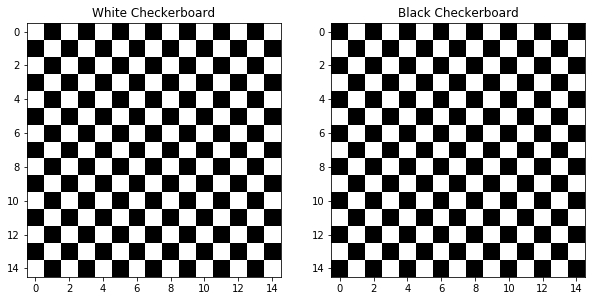

In [4]:
check_10_w = checkerboard((15,15))
check_10_b = np.logical_not(check_10_w).astype(int)

plt.figure(figsize=(10,8), facecolor='white')
plt.subplot(121)
plt.imshow(check_10_w, cmap='binary')
plt.title('White Checkerboard')
plt.subplot(122)
plt.imshow(check_10_b, cmap='binary')
plt.title('Black Checkerboard')
plt.show();

In [5]:
print('SKimage SSIM={:.3f}'.format(structural_similarity(check_10_w, check_10_b, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('SKimage MSE={:.2f}'.format(mean_squared_error(check_10_w, check_10_b)))

SKimage SSIM=1.000
SKimage MSE=1.00


When comparing the two checkerboards that are simply the inverse of each other, the Mean Squared Error (MSE) will result in a value of 1. However, this does not reflect that the two checkerboards are perfectly similar to each other. The Structural Similarity Index (SSIM) is able to capture this and therefore is a better metric to capture image quality in this case. 

We proceed to compare the MSE and SSIM metrics for scale and rotation distortions of the image.

In [6]:
from skimage.draw import disk

In [7]:
def make_circle(radius, dim=50):
    mask = np.zeros((dim,dim))
    row, col = int(dim/2), int(dim/2)
    rr, cc = disk((row,col),radius)
    mask[rr,cc]=1
    return mask

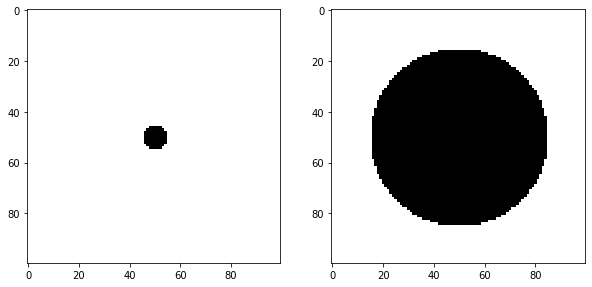

In [8]:
dot1 = make_circle(5, dim=100)
dot2 = make_circle(35, dim=100)

plt.figure(figsize=(10,5), facecolor='white')
plt.subplot(121)
plt.imshow(dot1, cmap='binary')
plt.subplot(122)
plt.imshow(dot2, cmap='binary')
plt.show();

In [12]:
sizes = [5, 10, 15, 20, 25, 50]

dot = {}
dot_ssim = {}
dot_mse = {}
for i in sizes:
    dot[i] = make_circle(i, dim=100)
    dot_ssim[i] = structural_similarity(dot[i], dot1, gaussian_weights=True, use_sample_covariance=False, sigma=1.5)
    dot_mse[i] = mean_squared_error(dot[i], dot1)

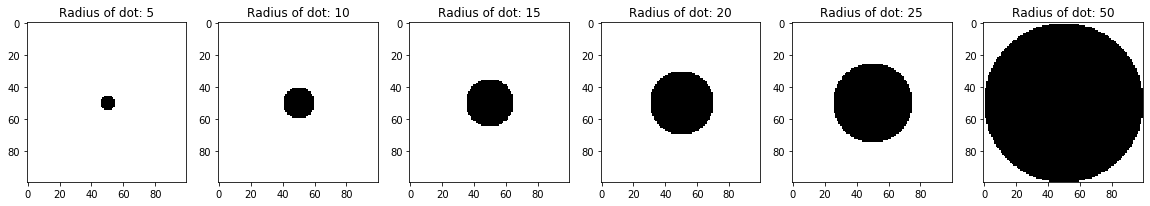

In [13]:
plt.figure(figsize=(20,5))
for i in range(len(sizes)):
    plt.subplot(1, len(sizes), i+1)
    plt.imshow(dot[sizes[i]], cmap='binary')
    plt.title('Radius of dot: {}'.format(sizes[i]))
plt.show();

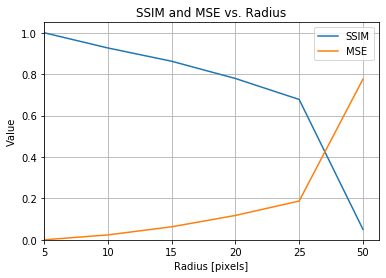

In [14]:
plt.figure()
plt.plot(list(dot_ssim.values()), label='SSIM')
plt.plot(list(dot_mse.values()), label='MSE')
plt.xticks(range(len(sizes)), sizes)

plt.title('SSIM and MSE vs. Radius')
plt.xlabel('Radius [pixels]')
plt.ylabel('Value')
plt.legend(); plt.grid('on')
plt.xlim(0)
plt.ylim(0)
plt.show();

In [15]:
from skimage.draw import ellipse

In [16]:
def make_ellipse(radius_maj, radius_min, dim=50, angle=0):
    mask = np.zeros((dim,dim))
    r_center, c_center = int(dim/2), int(dim/2)
    rr, cc = ellipse(r_center, c_center, radius_maj, radius_min, rotation=np.deg2rad(angle))
    mask[rr,cc]=1
    return mask

In [17]:
ellipse1 = make_ellipse(20, 5)
ellipse2 = np.rot90(ellipse1)

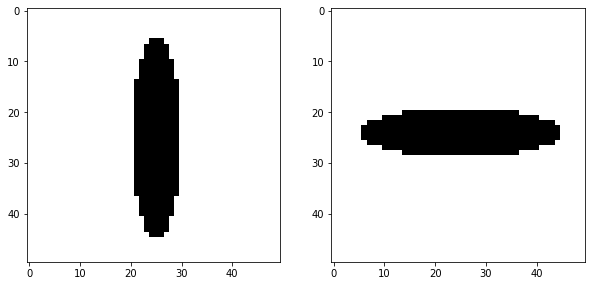

In [18]:
plt.figure(figsize=(10,5), facecolor='white')
plt.subplot(121)
plt.imshow(ellipse1, cmap='binary')
plt.subplot(122)
plt.imshow(ellipse2, cmap='binary')
plt.show();

In [19]:
rotations = [ 15, 30, 45, 60, 75, 90]

ell = {}
ell_ssim = {}
ell_mse = {}

for i in range(len(rotations)):
    ell[i]      = make_ellipse(20, 5, angle=rotations[i])
    ell_ssim[i] = structural_similarity(ell[i], ellipse1, gaussian_weights=True, use_sample_covariance=False, sigma=1.5)
    ell_mse[i] = mean_squared_error(ell[i], ellipse1)

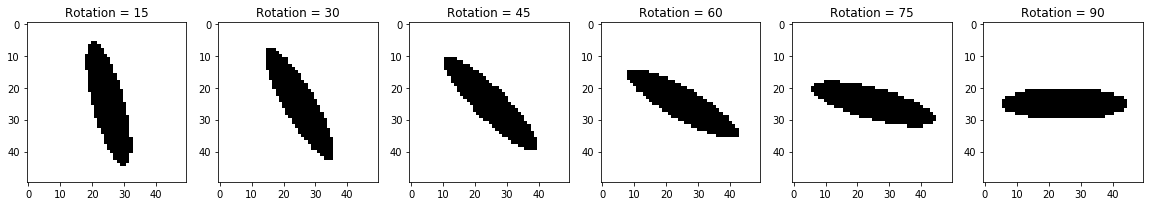

In [20]:
plt.figure(figsize=(20,5))
for i in range(len(rotations)):
    plt.subplot(1, len(rotations), i+1)
    plt.imshow(ell[i], cmap='binary')
    plt.title('Rotation = {}'.format(rotations[i]))
plt.show();

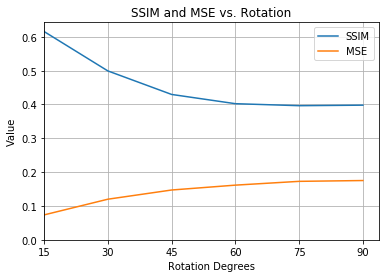

In [21]:
plt.figure()
plt.plot(list(ell_ssim.values()), label= 'SSIM')
plt.plot(list(ell_mse.values()), label= 'MSE')
plt.xlim(0)
plt.ylim(0)
plt.title('SSIM and MSE vs. Rotation')
plt.xlabel('Rotation Degrees')
plt.xticks(range(len(rotations)), rotations)

plt.ylabel('Value')
plt.legend(); plt.grid('on')
plt.show();


When comparing the performance of SSIM and MSE for rotation and scaling, both metrics showed similar results. SSIM performed better for larger rotation angles and scales. However, for smaller rotation angles and scales, the difference in performance between the two metrics wass not significant. This suggegsts that for cases where small rotation and scaling transformations are encountered, MSE may still be a viable option for determining image similarity. Nonetheless, given the beter performance of SSIM in some scenarios, it is worth considering as an alternative to MSE. Especially in image-based machine learning models, where images are often more complex and subtle variations in pixel values can have significant effects on model performance.

To test this, we simulate subsurface property maps and perform the same distortions and comparisons.

Below we recreate the original SSIM function introduced by Wang et al 2004

In [22]:
def gauss_kernel(size=11,sigma=1.5):
    center=(int)(size/2)
    kernel=np.zeros((size,size))
    for i in range(size):
       for j in range(size):
          diff=np.sqrt((i-center)**2+(j-center)**2)
          kernel[i,j]=np.exp(-(diff**2)/(2*sigma**2))
    return kernel/np.sum(kernel)

def SSIM_ww(data1, data2, winsize=11, show_map = False):

    dmin, dmax = dtype_range[data1.dtype.type]
    data_range = dmax-dmin
    L = data_range

    k1 = float(0.01)
    k2 = float(0.03)
    #L  = float(255)
    C1 = (k1*L) ** 2.0
    C2 = (k2*L) ** 2.0
    
    x = data1
    y = data2
    
    
    x2 = x * x
    y2 = y * y
    xy = x * y
    
    x_mean = ndimage.convolve(x, gauss_kernel(winsize))
    y_mean = ndimage.convolve(y, gauss_kernel(winsize))
    
    x_sq = x_mean * x_mean
    y_sq = y_mean * y_mean
    x_y = x_mean * y_mean
    
    sigma1_sq = ndimage.convolve(x2, gauss_kernel(winsize)) - x_sq
    sigma2_sq = ndimage.convolve(y2, gauss_kernel(winsize)) - y_sq
    sigma12 = ndimage.convolve(xy, gauss_kernel(winsize)) - x_y
    
    ssim_map = ((2 * x_y + C1) * (2 * sigma12 + C2)) / ((x_sq + y_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    pad_size = (winsize - 1) // 2
    
    if show_map:
        return ssim_map
    else:
        return crop(ssim_map, pad_size).mean()

We also develop functions to calculate the individual components of the SSIM function: luminance, contrast, structure. So that we may visualize how each componenet contributes to the SSIM metric.

In [23]:
#Luminance
def luminance(data1, data2, winsize=11, show_map = False):
    x = data1
    y = data2
    
    dmin, dmax = dtype_range[data1.dtype.type]
    data_range = dmax-dmin
    L = data_range
    
    k1 = float(0.01)
    k2 = float(0.03)
    #L  = float(255)
    C1 = (k1*L) ** 2.0
    C2 = (k2*L) ** 2.0
    
    x_mean = ndimage.convolve(x, gauss_kernel(winsize))
    y_mean = ndimage.convolve(y, gauss_kernel(winsize))
    
    x_sq = x_mean * x_mean
    y_sq = y_mean * y_mean
    x_y = x_mean * y_mean
    
    x2 = x * x
    y2 = y * y
    xy = x * y
    
    lum = (2 * x_y + C1) / (x_sq + y_sq + C1)
    
    pad_size = (winsize - 1) // 2
    
    lumin = crop(lum, pad_size).mean()
    
    if show_map:
        return lum
    else:
        return lumin

def contrast(data1, data2, winsize=11, show_map = False):
    x = data1
    y = data2
    
    dmin, dmax = dtype_range[data1.dtype.type]
    data_range = dmax-dmin
    L = data_range
    
    k1 = float(0.01)
    k2 = float(0.03)
    #L  = float(255)
    C1 = (k1*L) ** 2.0
    C2 = (k2*L) ** 2.0
    
    x2 = x * x
    y2 = y * y
    
    x_mean = ndimage.convolve(x, gauss_kernel(winsize))
    y_mean = ndimage.convolve(y, gauss_kernel(winsize))
    
    x_sq = x_mean * x_mean
    y_sq = y_mean * y_mean
    x_y = x_mean * y_mean
    
    sigmax = abs(ndimage.convolve(x2, gauss_kernel(winsize)) - x_sq) ** (1/2)
    sigmay = abs(ndimage.convolve(y2, gauss_kernel(winsize)) - y_sq) ** (1/2)
    
    sigma1_sq = ndimage.convolve(x2, gauss_kernel(winsize)) - x_sq
    sigma2_sq = ndimage.convolve(y2, gauss_kernel(winsize)) - y_sq
    
    con = (2 * sigmax * sigmay + C2) / (sigma1_sq + sigma2_sq + C2)

    pad_size = (winsize - 1) // 2
    
    cont = crop(con, pad_size).mean()
    
    if show_map:
        return con
    else:
        return cont

def structure(data1, data2, winsize=11, show_map = False):
    x = data1
    y = data2
    
    dmin, dmax = dtype_range[data1.dtype.type]
    data_range = dmax-dmin
    L = data_range
    
    k2 = float(0.03)
    #L  = float(255)
    C2 = (k2*L) ** 2.0
    C3 = C2 / 2
    
    x_mean = ndimage.convolve(x, gauss_kernel(winsize))
    y_mean = ndimage.convolve(y, gauss_kernel(winsize))
    
    x_sq = x_mean * x_mean
    y_sq = y_mean * y_mean
    x_y = x_mean * y_mean
    
    x2 = x * x
    y2 = y * y
    xy = x * y

    sigma12 = ndimage.convolve(xy, gauss_kernel(winsize)) - x_y
    sigmax = abs(ndimage.convolve(x2, gauss_kernel(winsize)) - x_sq) ** (1/2)
    sigmay = abs(ndimage.convolve(y2, gauss_kernel(winsize)) - y_sq) ** (1/2)
    
    struct = (sigma12  + C3) / (sigmax * sigmay + C3)

    pad_size = (winsize - 1) // 2
    
    st = crop(struct, pad_size).mean()
    
    if show_map:
        return struct
    else:
        return st
    
def SSIM_by_comp(data1, data2):
    l_val = luminance(data1, data2)
    c_val = contrast(data1, data2)
    s_val = structure(data1, data2)
    
    return l_val * c_val * s_val
    

In [24]:
def SSIM_unww(data1, data2, winsize=11):

    unit_kernel = np.ones((winsize,winsize))

    dmin, dmax = dtype_range[data1.dtype.type]
    data_range = dmax-dmin
    L = data_range
    
    k1 = float(0.01)
    k2 = float(0.03)
    #L  = float(255)
    C1 = (k1*L) ** 2.0
    C2 = (k2*L) ** 2.0
    
    x = data1
    y = data2
    
    
    x2 = x * x
    y2 = y * y
    xy = x * y
    
    x_mean = ndimage.convolve(x, unit_kernel)
    y_mean = ndimage.convolve(y, unit_kernel)
    
    x_sq = x_mean * x_mean
    y_sq = y_mean * y_mean
    x_y = x_mean * y_mean
    
    sigma1_sq = ndimage.convolve(x2, unit_kernel) - x_sq
    sigma2_sq = ndimage.convolve(y2, unit_kernel) - y_sq
    sigma12 = ndimage.convolve(xy, unit_kernel) - x_y
    
    ssim_map = ((2 * x_y + C1) * (2 * sigma12 + C2)) / ((x_sq + y_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    return np.mean(ssim_map)
    

Load the required libraries and functions for simulation of subsurface porosity images. 

In [25]:
from geostatspy.GSLIB import *
from geostatspy.geostats import *
import geostatspy.GSLIB as GSLIB
import random as rand
import geostatspy as geostats

In [26]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = rand.randint(7000,8000)                                   # random number seed  for stochastic simulation    
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

In [27]:
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny) 
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])


Functions to perform upscaling of the images and plot them.

In [28]:
def upscale(model,new_nx,new_ny):
    ny, nx = model.shape
    new_xsiz = nx/new_nx; new_xmn = new_xsiz * 0.5
    new_ysiz = ny/new_ny; new_ymn = new_ysiz * 0.5
    new_model = np.zeros((new_ny,new_nx)); count = np.zeros((new_ny,new_nx))
    for iy in range(0,ny):
        yloc = iy+0.5
        new_iy = getindex(new_ny,new_ymn,new_ysiz,yloc)
        for ix in range(0,nx):
            xloc = ix+0.5
            new_ix = getindex(new_nx,new_xmn,new_xsiz,xloc)
            new_model[new_iy,new_ix] = new_model[new_iy,new_ix] + model[iy,ix] 
            count[new_iy,new_ix] = count[new_iy,new_ix] + 1 
    for iny in range(0,new_ny):
        for inx in range(0,new_nx):
            if count[iny,inx] > 0:
                new_model[iny,inx] = new_model[iny,inx] / count[iny,inx]
    return new_model

def cellplt_st(array,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    im = plt.imshow(array,cmap,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20) 

Function to "unscale" the image so that we may calculate the SSIM metric for the images. This function allows us to retain the same number of pixels in both the reference and evaluating image.

In [29]:
def unscale(data1, scale_f, target_x, target_y):
    data1_unscaled = np.zeros((target_x,target_y))
    factor = int(1/scale_f)
    x_row = 0
    x_col = 0
    y_row = factor
    y_col = factor
    for i in range(len(data1)):
        x_col = 0
        y_col = factor
        for j in range(len(data1[i])):
            data1_unscaled[x_row:y_row, x_col:y_col] = data1[i,j]
            y_col +=factor
            x_col +=factor
        x_row +=factor
        y_row +=factor
        
    if np.all(data1_unscaled[:,-1]) == 0 and np.all(data1_unscaled[-1,:]) == 0:
        data1_unscaled = data1_unscaled[0:target_x-4,0:target_y-4] 
            
    return data1_unscaled

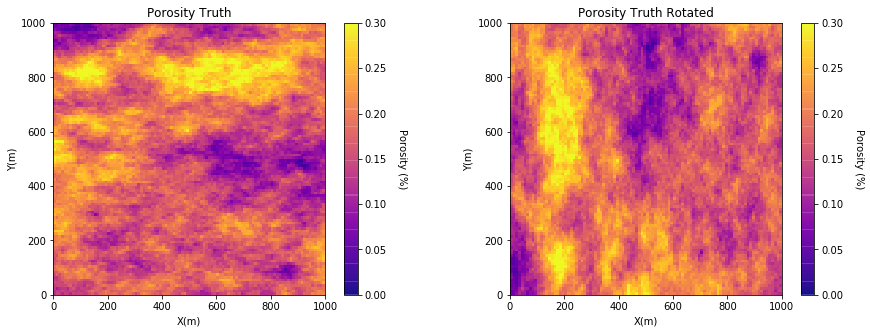

In [30]:
# Make a truth model / unconditional simulation
por_mean = 0.18; por_stdev = 0.05; por_cmin = 0.0; por_cmax = 0.3
var = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=500.0,hmin1=250.0)
porosity_truth = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed + 3,var,"Porosity")
porosity_truth = affine(porosity_truth,por_mean,por_stdev)

porosity_truth_rot = np.rot90(porosity_truth)

plt.figure(figsize=(15,5))

plt.subplot(122)
pixelplt_st(porosity_truth_rot,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Truth Rotated","X(m)","Y(m)","Porosity (%)",cmap)

plt.subplot(121)
pixelplt_st(porosity_truth,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Truth","X(m)","Y(m)","Porosity (%)",cmap)


In [33]:
y = SSIM_ww(porosity_truth, porosity_truth_rot)

In [34]:
lum = luminance(porosity_truth, porosity_truth_rot)
cont = contrast(porosity_truth, porosity_truth_rot)
struct = structure(porosity_truth, porosity_truth_rot)

print('Our Luminance={:.2f} | Contrast={:.2f} | Structure={:.2f}'.format(lum, cont, struct))
print('Our SSIM={:.3f}'.format(y))
print('Our SSIM by component={:.3f}'.format(SSIM_by_comp(porosity_truth, porosity_truth_rot)))
print('SKimage SSIM={:.3f}'.format(structural_similarity(porosity_truth, porosity_truth_rot, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('SKimage MSE={:.2f}'.format(mean_squared_error(porosity_truth, porosity_truth_rot)))

Our Luminance=0.94 | Contrast=0.99 | Structure=0.80
Our SSIM=0.746
Our SSIM by component=0.745
SKimage SSIM=0.746
SKimage MSE=0.01


After generating our subsurface property map, we rotate it 90 degrees and calculate the MSE and SSIM metric. Here we successfully recreated the original SSIM metric and our by-componenet metric also matches up with the original implementation from SKimage. We can see the similarities of the luminance, contrast and structure as well between the two. Below, we have visualized these plots. 

The calculated MSE between the original and the rotated image was found to be 0, suggesting that the two images are identical. However, the calculated value for the SSIM was 0.810. Indicating that there are significant structural differences between the two images. This makes SSIM more robust to calculate image similarity and therefore better suited for image-based machine learning model validation, where structural similarity is often more important than pixel-level difference.  

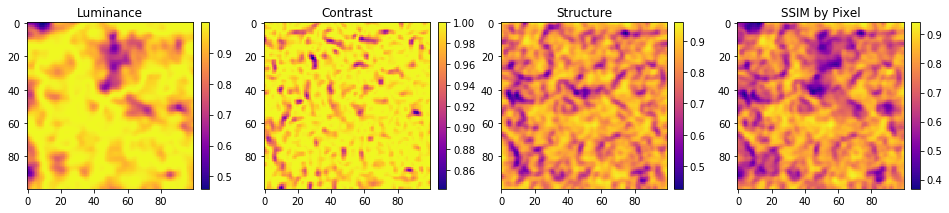

In [35]:
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.imshow(luminance(porosity_truth, porosity_truth_rot, show_map=True), cmap = cmap)
plt.title("Luminance")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(142)
plt.imshow(contrast(porosity_truth, porosity_truth_rot, show_map=True), cmap = cmap)
plt.title("Contrast")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(143)
plt.imshow(structure(porosity_truth, porosity_truth_rot, show_map=True), cmap = cmap)
plt.title("Structure")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(144)
plt.imshow(SSIM_ww(porosity_truth, porosity_truth_rot, show_map=True), cmap = cmap)
plt.title("SSIM by Pixel")
plt.colorbar(fraction=0.046, pad=0.04)



plt.subplots_adjust(wspace=0.3, hspace=0.3)

We proceed to make the same comparisons on the translation and upscaling of the original image.

## TRANSLATION

We begin by creating a new porosity map that is a large map (1000x1000). Then we create a function that selects a specific window of the larger image and the perform the similarity metric calculations.

In [36]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 1000; ny = 1000; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = rand.randint(7000,8000)                                   # random number seed  for stochastic simulation    
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
vmin = 4; vmax = 16; cmap = plt.cm.plasma             

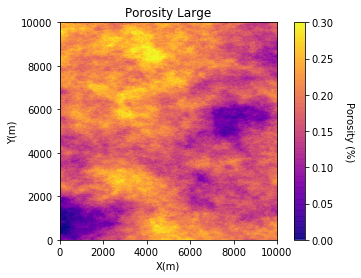

In [37]:
por_mean = 0.18; por_stdev = 0.05; por_cmin = 0.0; por_cmax = 0.3
var = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=5000.0,hmin1=2500.0)
porosity_large = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed + 3,var,"Porosity")
porosity_large = affine(porosity_large,por_mean,por_stdev)


pixelplt_st(porosity_large,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Large","X(m)","Y(m)","Porosity (%)",cmap)


In [38]:
# Function to extract a window from a larger image
def window(large_image, window_x, window_y, window_width, window_height):
    """
    Parameters:
        large_image (numpy.ndarray): The large image from which the window will be cropped. 
        window_x (int): The x-coordinate of the top-left corner of the window in the large image. 
        window_y (int): The y-coordinate of the top-left corner of the window in the large image. .
        window_width (int): The width of the window to be cropped. 
        window_height (int): The height of the window to be cropped. 
    
    Returns:
        The cropped window.
    """
    window = large_image[window_x:window_x+window_width, window_y:window_y+window_height]

    nx = 100
    ny = 100
    cell_size = 10                               
    xmin = 0.0
    ymin = 0.0                                          
    xmax = xmin + nx * cell_size
    ymax = ymin + ny * cell_size 

    pixelplt_st(window, xmin, xmax, ymin, ymax, cell_size, por_cmin, por_cmax, "Porosity Window", "X(m)", "Y(m)", "Porosity (%)", cmap)

    return window


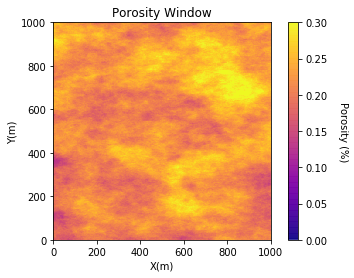

In [39]:
nw_corner = window(porosity_large,0,0,500,500)

Above is the northwest corner of our larger image. We use this image to calculate the similarity metrics from the original large image to this image. This simulates the effect of having a translated image. 

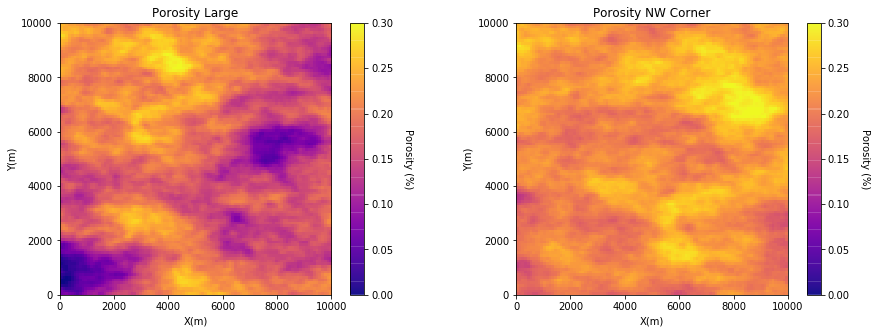

In [40]:
#Resize large image
por_large = resize(porosity_large, (100,100))
nw_corner = resize(nw_corner, (100,100))


plt.figure(figsize=(15,5))

#View large image with window image
plt.subplot(121)
pixelplt_st(por_large,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Large","X(m)","Y(m)","Porosity (%)",cmap)

plt.subplot(122)
pixelplt_st(nw_corner,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity NW Corner","X(m)","Y(m)","Porosity (%)",cmap)


In [41]:
y = SSIM_ww(por_large, nw_corner)
lum = luminance(por_large, nw_corner)
cont = contrast(por_large, nw_corner)
struct = structure(por_large, nw_corner)

print('Our Luminance={:.2f} | Contrast={:.2f} | Structure={:.2f}'.format(lum, cont, struct))
print('Our SSIM={:.3f}'.format(y))
print('Our SSIM by component={:.3f}'.format(SSIM_by_comp(por_large, nw_corner)))
print('SKimage SSIM={:.3f}'.format(structural_similarity(por_large, nw_corner, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('SKimage MSE={:.2f}'.format(mean_squared_error(por_large, nw_corner)))

Our Luminance=0.93 | Contrast=0.99 | Structure=0.93
Our SSIM=0.857
Our SSIM by component=0.858
SKimage SSIM=0.857
SKimage MSE=0.01


When comparing the performance of MSE and SSIM on the translated image, we find that MSE had a low value of 0.01 while SSIM had a higher value of 0.842. This indicates that SSIM is a better metric for evaluating image similarity in the case of translations as well.

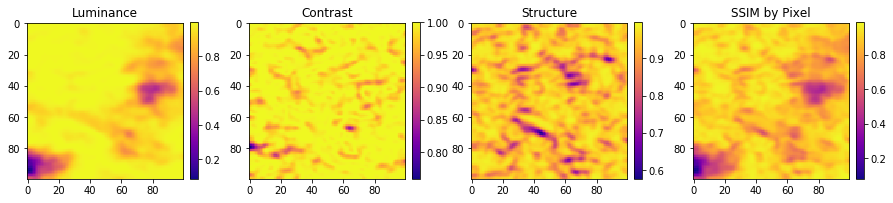

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.imshow(luminance(por_large, nw_corner, show_map=True), cmap = cmap)
plt.title("Luminance")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(142)
plt.imshow(contrast(por_large, nw_corner, show_map=True), cmap = cmap)
plt.title("Contrast")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(143)
plt.imshow(structure(por_large, nw_corner, show_map=True), cmap = cmap)
plt.title("Structure")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(144)
plt.imshow(SSIM_ww(por_large, nw_corner, show_map=True), cmap = cmap)
plt.title("SSIM by Pixel")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

## UPSCALING

We test the metrics on the effect of an upscaled image. This simulates a blurred distortion that is encountered in image processing.  

In [43]:
from skimage.transform import rescale

In [44]:
# Scale image by a factor of 10
porosity_truth_scale = rescale(porosity_truth,0.1 )

In [45]:
#Resize to calculate metrics
por_scale = resize(porosity_truth_scale, (100,100))
por_scale.shape

(100, 100)

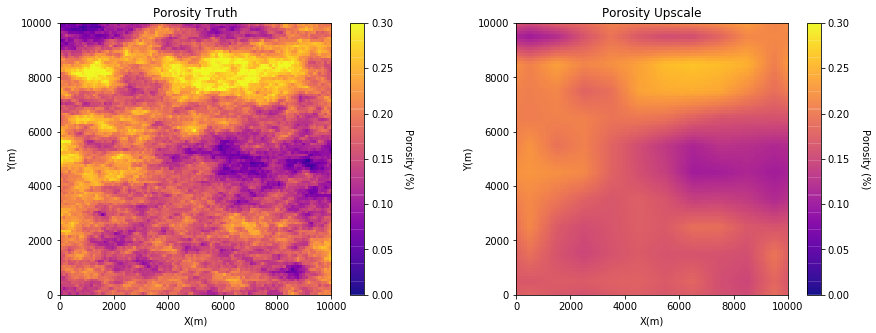

In [46]:
plt.figure(figsize=(15,5))

plt.subplot(121)
pixelplt_st(porosity_truth,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Truth","X(m)","Y(m)","Porosity (%)",cmap)

plt.subplot(122)
pixelplt_st(por_scale,xmin,xmax,ymin,ymax,cell_size,por_cmin,por_cmax,"Porosity Upscale","X(m)","Y(m)","Porosity (%)",cmap)




In [47]:
y = SSIM_ww(porosity_truth, por_scale)
lum = luminance(porosity_truth, por_scale)
cont = contrast(porosity_truth, por_scale)
struct = structure(porosity_truth, por_scale)

print('Our Luminance={:.2f} | Contrast={:.2f} | Structure={:.2f}'.format(lum, cont, struct))
print('Our SSIM={:.3f}'.format(y))
print('Our SSIM by component={:.3f}'.format(SSIM_by_comp(porosity_truth, por_scale)))
print('SKimage SSIM={:.3f}'.format(structural_similarity(porosity_truth, por_scale, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('SKimage MSE={:.2f}'.format(mean_squared_error(porosity_truth, por_scale)))

Our Luminance=0.99 | Contrast=0.93 | Structure=0.97
Our SSIM=0.895
Our SSIM by component=0.895
SKimage SSIM=0.895
SKimage MSE=0.00


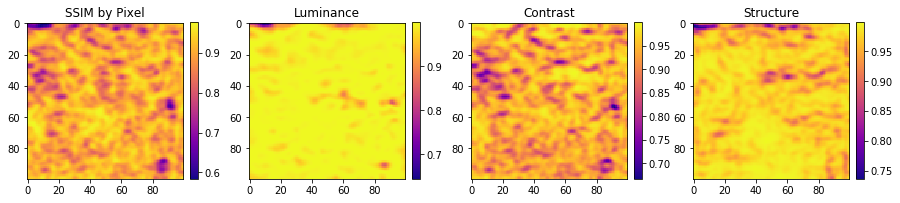

In [48]:
plt.figure(figsize=(15,5))

plt.subplot(141)
plt.imshow(SSIM_ww(porosity_truth, por_scale, show_map=True), cmap = cmap)
plt.title("SSIM by Pixel")
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(142)
plt.imshow(luminance(porosity_truth, por_scale, show_map=True), cmap = cmap)
plt.title("Luminance")
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(143)
plt.imshow(contrast(porosity_truth, por_scale, show_map=True), cmap = cmap)
plt.title("Contrast")
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(144)
plt.imshow(structure(porosity_truth, por_scale, show_map=True), cmap = cmap)
plt.title("Structure")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

We also evaluated the performance of MSE and SSIM on the upscaled image and found that MSE had a value of 0 while SSIM had a high value of 0.925. This also suggests that SSIM is a more appropriate metric for evaluating the similarity of upscaled images.  This is particularly important in image-based machine learning models where images may need to be upscaled or encounter unclear images. 



In [49]:
upscales = [i/10 for i in range(1,11)]  # Define a list of nugget values to loop through


[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [50]:
porosity_upscale = np.zeros((len(upscales),100,100))
for i in range(len(upscales)):
    porosity_upscale[i] = resize(rescale(porosity_truth,upscales[i]), (100,100))
porosity_upscale.shape

(10, 100, 100)

Text(0.5, 1.0, 'Upscale by a factor of 10')

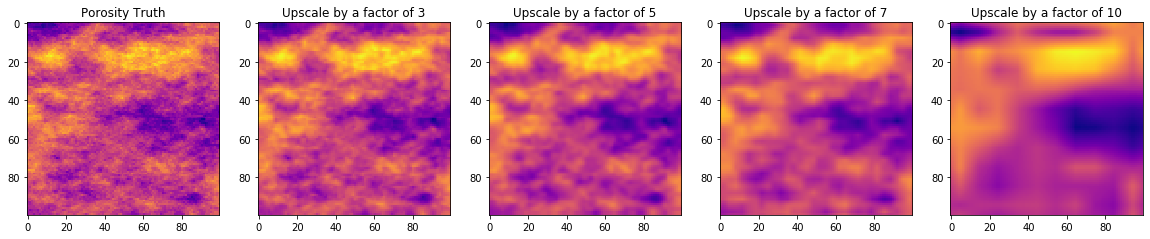

In [51]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(porosity_truth, cmap=cmap)
plt.title('Porosity Truth')

plt.subplot(152)
plt.imshow(porosity_upscale[7], cmap=cmap)
plt.title('Upscale by a factor of 3')

plt.subplot(153)
plt.imshow(porosity_upscale[4], cmap=cmap)
plt.title('Upscale by a factor of 5')
plt.subplot(154)
plt.imshow(porosity_upscale[2], cmap=cmap)
plt.title('Upscale by a factor of 7')

plt.subplot(155)
plt.imshow(porosity_upscale[0], cmap=cmap)
plt.title('Upscale by a factor of 10')

In [52]:
SSIM_scale = np.zeros(len(upscales))
mse_scale = np.zeros(len(upscales))
for i in range(len(upscales)):
    SSIM_scale[i] = SSIM_ww(porosity_truth,porosity_upscale[i])
    mse_scale[i] = mean_squared_error(porosity_truth, porosity_upscale[i])

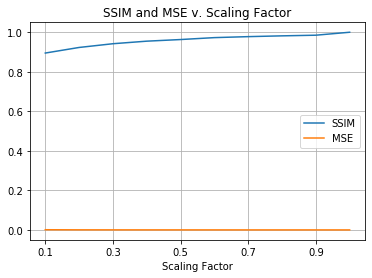

In [53]:
plt.figure()
plt.plot(SSIM_scale, label='SSIM')
plt.plot(mse_scale, label='MSE')
plt.xticks(range(0, len(upscales), 2), upscales[::2])
plt.xlabel('Scaling Factor')
plt.title('SSIM and MSE v. Scaling Factor')
plt.legend(); plt.grid('on')


## Multi-Scale SSIM

Multi-scale SSIM has been proposed as an extension to SSIM that is able to evaluate image quality at multiple scales, which is particularly useful when dealing with complex images. By considering the structural information at multiple scales, multi-scale SSIM can better capture the perceptual changes that occur when images are scaled, making it a valuable tool for evaluating the quality of images.

The multi-scale SSIM metric (MSSSIM), introduced by Wang et al (2003) is an extension of SSIM that incorporates the assessment of image quality at multiple scales. It calculates the SSIM value at different levels of image downscaling following the equation:


\begin{equation}
MS-SSIM(x,y) = [l_M(x,y)]^{\alpha_M} \cdot \prod_{j=1}^M [c_j(x,y)]^{\beta_j}[s_j(x,y)]^{\gamma_j}
\end{equation}

In the original implementation, the input image and evaluated image are downsampled by a factor of 2 up until scale $M$. The contrast ($c_j(x,y)$) and structure ($s_j(x,y)$) componenets are calculated after each $j$-th scale. The luminance componenet ($l_M(x,y)$) is only calculated at scale $M$.  


Below we have the implementation of the multi-scale SSIM metric with the weights used as weighting factors at each scale. 

In [54]:
def MSSSIM_ww(data1, data2):
    # Original implementation from Z. Wang's "Multi-scale structural similarity for image quality assessment" Invited Paper, IEEE Asilomar Conference on Signals, Systems and Computers, Nov. 2003 
    #Author's MATLAB implementation:-http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
    
    #Scales used for downsampling image. 5 downscaling by factor of 2
    scales = [0.5, 0.25, 0.125, 0.0625, 0.03125]
    #weights used in original paoer.
    weight = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]

    
    down_img = {}
    unscale_img = {}
    down_img2 = {}
    unscale_img2 = {}
    
    down_img[0] = downscale(data1)
    down_img2[0] = downscale(data2)
    
    #Downscale the images based on the scale
    for i in range(4):
        down_img[i+1] = downscale(down_img[i])
        down_img2[i+1] = downscale(down_img2[i])
    
    #Bring them back to proper dimensions to perform calculations
    for i in range(len(scales)):
        unscale_img[i] = unscale(down_img[i], scales[i], 100, 100)
        unscale_img2[i] = unscale(down_img2[i], scales[i], 100, 100)
        
    msim_struct = np.zeros(len(scales))
    msim_cont = np.zeros(len(scales))
    msim_cs = np.zeros(len(scales))
    msim_weight = np.zeros(len(scales))

    for i in range(len(unscale_img)):
        c_val = contrast(unscale_img[i], unscale_img2[i])
        s_val = structure(unscale_img[i], unscale_img2[i])
        msim_cont[i] = c_val
        msim_struct[i] = s_val
        msim_weight[i]= (msim_cont[i]**weight[i])*(msim_struct[i]**weight[i]) 
    
    mssim_scale = np.zeros(len(scales))
    lumen = np.zeros(len(scales))
    
    #MSSIM at each scale
    for i in range(len(unscale_img)):
        lumen[i]  = luminance(unscale_img[i], unscale_img2[i])**weight[i]
        mssim_scale[i] = msim_weight[i]*lumen[i]
    
    # MSSIM value                    
    mssim = np.prod(msim_weight)*lumen[-1]
    
    # Plots at each scale
    plt.figure(figsize=(20,5))
    for i in range(len(unscale_img)):
        plt.subplot(1, len(down_img), i+1)
        plt.imshow(unscale_img[i], cmap=cmap)
        plt.title('Unscaled image of factor of: {}'.format(scales[i]))
    plt.show();    
    
    plt.figure(figsize=(20,5))
    for i in range(len(unscale_img2)):
        plt.subplot(1, len(down_img2), i+1)
        plt.imshow(unscale_img2[i], cmap=cmap)
        plt.title('Unscaled image of factor of: {}'.format(scales[i]))
    plt.show();
    
    print('MS-SSIM={:.3f}'.format(mssim))

    
    return mssim
        

    
    
    

Downscale function that is called in the MSSSIM function above to downscale the image for structure and contrast calculations.

In [55]:
def downscale(data1):
    img1 = data1
 
    [m, n] = img1.shape
    plt.imshow(img1, cmap=cmap)
 
    f = 2
 
    img2 = np.zeros((m//f, n//f))
 
    for i in range(0, m, f):
        for j in range(0, n, f):
            try:
                img2[i//f][j//f] = img1[i][j]
            except IndexError:
                pass

    plt.imshow(img2, cmap=cmap)
    
    return img2

### Multi-scale SSIM for rotation

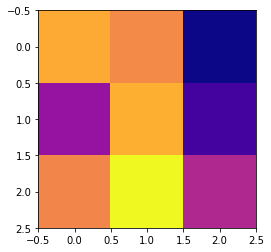

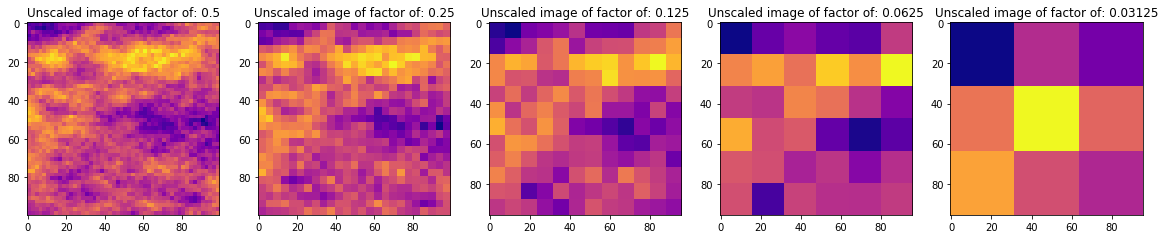

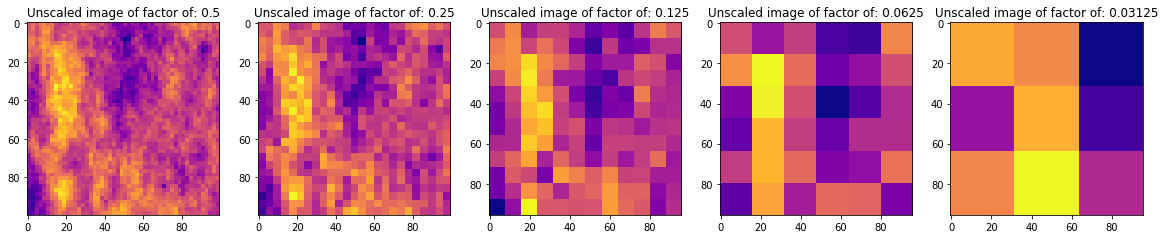

MS-SSIM=0.824


0.8240130443948535

In [56]:
MSSSIM_ww(porosity_truth,porosity_truth_rot)

In [57]:
print('SSIM={:.3f}'.format(structural_similarity(porosity_truth, porosity_truth_rot, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('MSE={:.2f}'.format(mean_squared_error(porosity_truth, porosity_truth_rot)))

SSIM=0.746
MSE=0.01


### Multi-scale SSIM for Translation

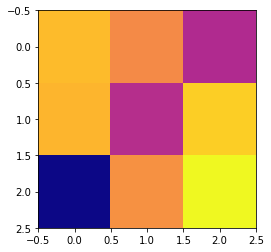

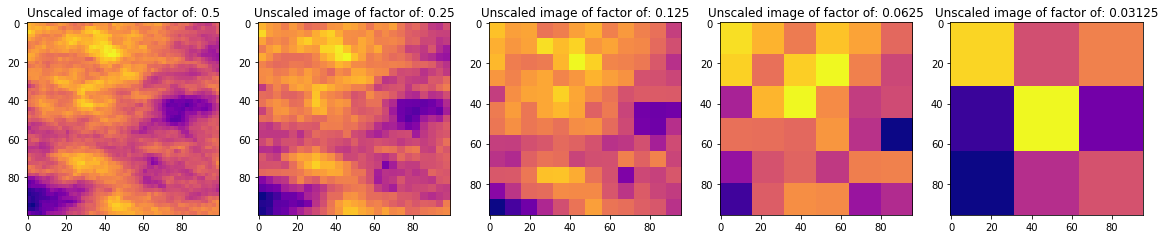

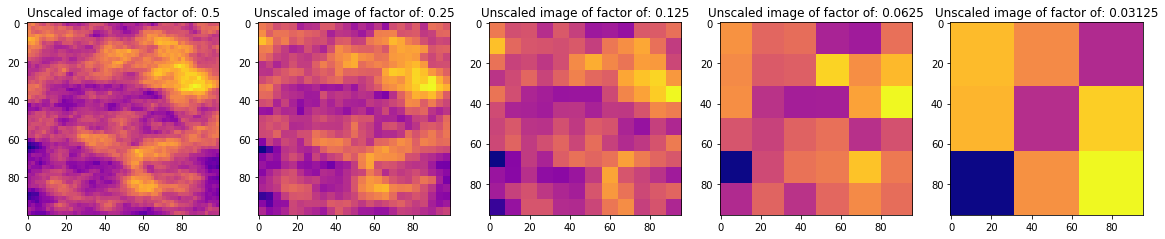

MS-SSIM=0.913


0.9134287255722667

In [58]:
MSSSIM_ww(por_large,nw_corner)

In [59]:
print('SSIM={:.3f}'.format(structural_similarity(por_large,nw_corner, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('MSE={:.2f}'.format(mean_squared_error(por_large,nw_corner)))

SSIM=0.857
MSE=0.01


### Multi-scale SSIM for Scale

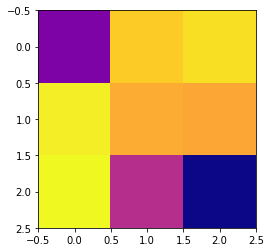

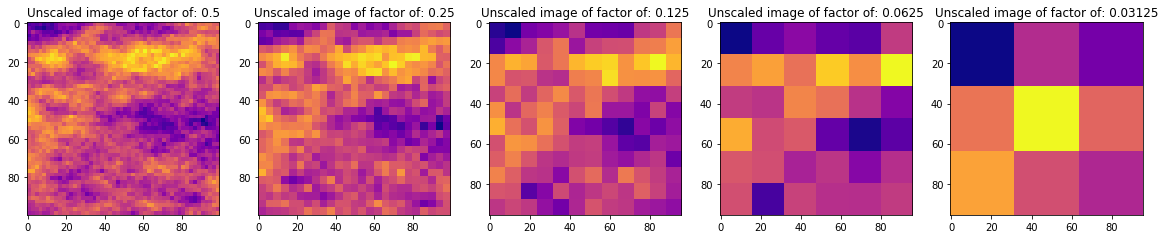

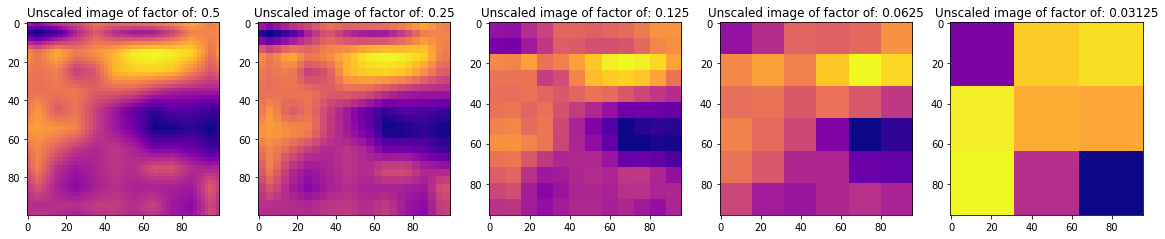

MS-SSIM=0.928


0.9280141386444579

In [60]:
MSSSIM_ww(porosity_truth,por_scale)

In [61]:
print('SSIM={:.3f}'.format(structural_similarity(porosity_truth, por_scale, 
                                                         gaussian_weights=True, use_sample_covariance=False, sigma=1.5)))
print('MSE={:.2f}'.format(mean_squared_error(porosity_truth, por_scale)))

SSIM=0.895
MSE=0.00


When comparing the results of multi-scale SSIM with the SSIM and MSE metrics for rotation, translation, and scale, the multi-scale SSIM metric outperformed both the SSIM and MSE metrics, particularly in the case of the rotation. (MS-SSIM: 0.85 compared to SSIM: 0.79). Becasue the MS-SSIM takes into account the similarity of pixel intensities and the spatial arrangements at different scales, it results in a more comprehensive assessment of image similarity and can better capture complex image transformations. This makes it a valuable metric for assessing the performance of image-based machine learning models especially for image classification and segmentation tasks. 

Below we analyze what the MS-SSIM value is at each downsampling of the original and transformed image for all three transformations.

## MS-SSIM, SSIM, MSE vs Scale

Function to calculate all metrics on each scaling step of the MS-SSIM function

In [62]:
def metric_comparison(reference_image, new_image):
    scales = [0.5, 0.25, 0.125, 0.0625, 0.03125]
    #weights used in original paoer.
    weight = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]

    
    down_img = {}
    unscale_img = {}
    down_img2 = {}
    unscale_img2 = {}
    
    down_img[0] = downscale(reference_image)
    down_img2[0] = downscale(new_image)
    
    #Downscale the images based on the scale
    for i in range(4):
        down_img[i+1] = downscale(down_img[i])
        down_img2[i+1] = downscale(down_img2[i])
    
    #Bring them back to proper dimensions to perform calculations
    for i in range(len(scales)):
        unscale_img[i] = unscale(down_img[i], scales[i], 100, 100)
        unscale_img2[i] = unscale(down_img2[i], scales[i], 100, 100)
    
    #Calculate the metrics at each scale
    ssim_scale = np.zeros(5)
    mse_scale = np.zeros(5)
    msim_struct = np.zeros(5)
    msim_cont = np.zeros(5)
    msim_weight = np.zeros(5)

    for i in range(len(unscale_img)):
        c_val = contrast(unscale_img[i], unscale_img2[i])
        s_val = structure(unscale_img[i], unscale_img2[i])
        msim_cont[i] = c_val
        msim_struct[i] = s_val
        msim_weight[i]= msim_cont[i]**weight[i]*msim_struct[i]**weight[i]
        ssim_scale[i] = SSIM_ww(unscale_img[i], unscale_img2[i])
        mse_scale[i] = mean_squared_error(unscale_img[i], unscale_img2[i])
    
    mssim_scale = np.zeros(5)
    lumen = np.zeros(5)

    for i in range(len(unscale_img)):
        lumen[i]  = luminance(unscale_img[i], unscale_img2[i])**weight[i]
        mssim_scale[i] = msim_weight[i]*lumen[i]
    
    return mssim_scale, msim_cont, msim_struct, lumen, ssim_scale
    

### For Translation:

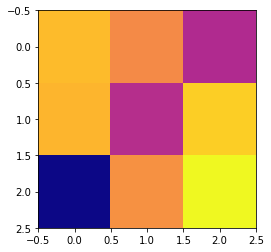

In [63]:
mssim_scale, msim_cont, msim_struct, lumen, ssim_scale = metric_comparison(por_large, nw_corner)

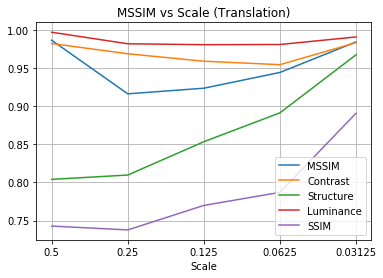

In [67]:
scales = [0.5, 0.25, 0.125, 0.0625, 0.03125]

plt.figure()
plt.plot(mssim_scale, label='MSSIM')
plt.plot(msim_cont, label='Contrast')
plt.plot(msim_struct, label='Structure')
plt.plot(lumen, label='Luminance')
plt.plot(ssim_scale, label='SSIM')
plt.xticks(range(len(scales)), scales)

plt.xlabel('Scale')
plt.title('MSSIM vs Scale (Translation)')
plt.legend(); plt.grid('on')


### For Rotation

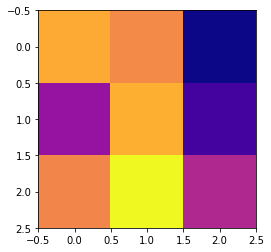

In [68]:
mssim_scale, msim_cont, msim_struct, lumen, ssim_scale = metric_comparison(porosity_truth, porosity_truth_rot)

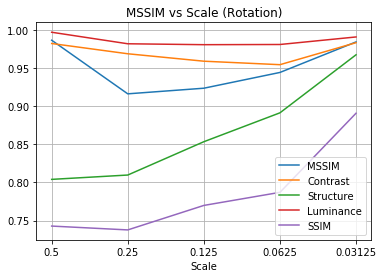

In [69]:
plt.figure()
plt.plot(mssim_scale, label='MSSIM')
plt.plot(msim_cont, label='Contrast')
plt.plot(msim_struct, label='Structure')
plt.plot(lumen, label='Luminance')
plt.plot(ssim_scale, label='SSIM')
plt.xticks(range(len(scales)), scales)

plt.xlabel('Scale')
plt.title('MSSIM vs Scale (Rotation)')
plt.legend(); plt.grid('on')


### For Upscaling

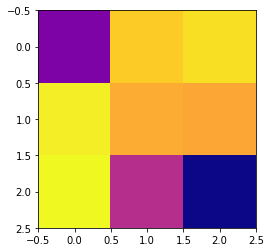

In [70]:
mssim_scale, msim_cont, msim_struct, lumen, ssim_scale = metric_comparison(porosity_truth, por_scale)

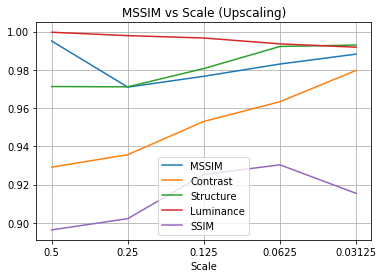

In [71]:
plt.figure()
plt.plot(mssim_scale, label='MSSIM')
plt.plot(msim_cont, label='Contrast')
plt.plot(msim_struct, label='Structure')
plt.plot(lumen, label='Luminance')
plt.plot(ssim_scale, label='SSIM')
plt.xticks(range(len(scales)), scales)

plt.xlabel('Scale')
plt.title('MSSIM vs Scale (Upscaling)')
plt.legend(); plt.grid('on')


When comparing the multi-scale SSIM value at each downsampling of the original image with the SSIM, we observed that the multi-scale SSIM metric consistently outperforms the standard SSIM metric at each scale.

### Multi-scale SSIM for Different Variograms

Below we analyze the behavior of MS-SSIM for different variogram ranges and how this metric behaves with a presence of a nugget effect in the variogram.

In [72]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = rand.randint(7000,8000)                                   # random number seed  for stochastic simulation    
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
vmin = 4; vmax = 16; cmap = plt.cm.plasma      

In [73]:
#Start with initial model.
model = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=500.0,hmin1=250.0)
                                                                                                  
#Set ranges to update model with
ranges_maj = list(range(5, 501,25))
ranges_min = list(range(5, 501,25)) 

print('Ranges Major: {} | Ranges Minor: {} '.format(len(ranges_maj), len(ranges_min)))
    

Ranges Major: 20 | Ranges Minor: 20 


In [74]:
sim = np.zeros((len(ranges_maj),100,100))
simulations = np.zeros((len(ranges_maj),100,100))

for i,j in zip(range(len(ranges_maj)),range(len(ranges_min))):
    model[i] = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=ranges_maj[i], hmin1=ranges_min[j])
    sim[i,:,:] = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed = 73073, var = model[i], output_file = "simulation")
    simulations[i,:,:] = GSLIB.affine(sim[i,:,:], por_mean, por_stdev)
print('Simulations shape:', simulations.shape)


Simulations shape: (20, 100, 100)


Text(0.5, 1.0, 'Variogram Range of: 480')

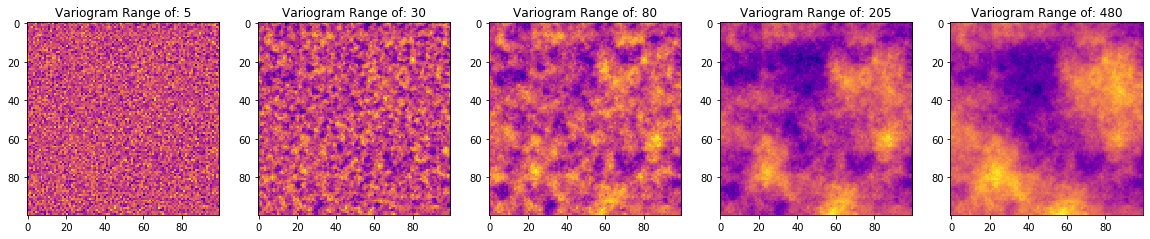

In [75]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(simulations[0], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[0]))

plt.subplot(152)
plt.imshow(simulations[1], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[1]))

plt.subplot(153)
plt.imshow(simulations[3], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[3]))

plt.subplot(154)
plt.imshow(simulations[8], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[8]))

plt.subplot(155)
plt.imshow(simulations[19], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[19]))

We choose 5 different variogram ranges that result in obvious differences to the visual eye in the subsurface propertry maps. We proceed to perform a rotation of each and test the MS-SSIM metric on the transformations at each variogram range.

## Variogram Range and Rotation

In [76]:
sim_rotated = np.zeros((len(simulations),100,100))
for i in range(len(simulations)):
    sim_rotated[i] = np.rot90(simulations[i])

Text(0.5, 1.0, 'Variogram Range of: 480')

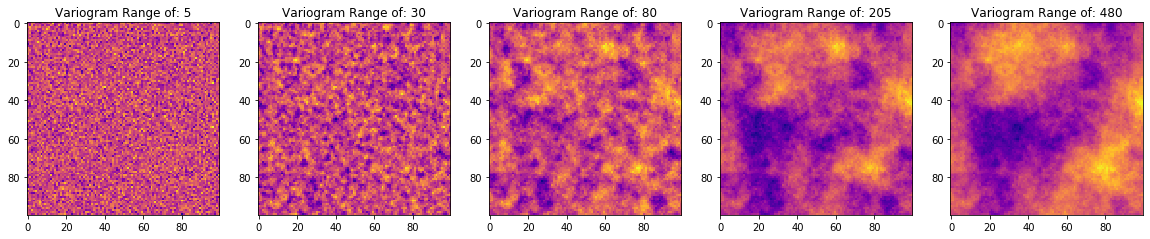

In [77]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(sim_rotated[0], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[0]))

plt.subplot(152)
plt.imshow(sim_rotated[1], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[1]))

plt.subplot(153)
plt.imshow(sim_rotated[3], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[3]))

plt.subplot(154)
plt.imshow(sim_rotated[8], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[8]))

plt.subplot(155)
plt.imshow(sim_rotated[19], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[19]))

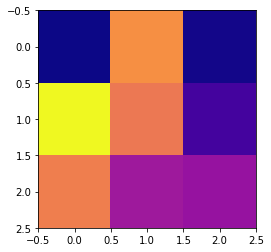

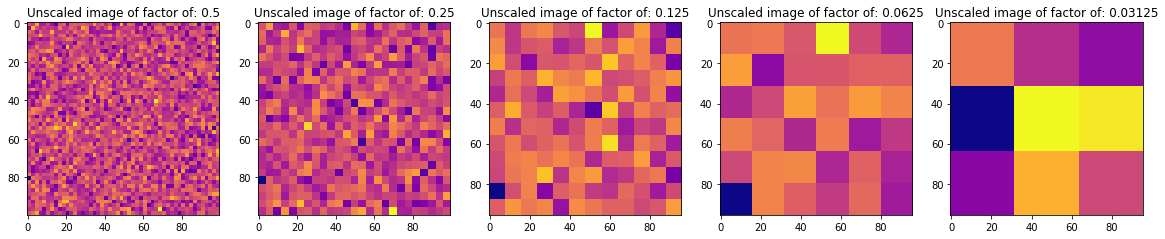

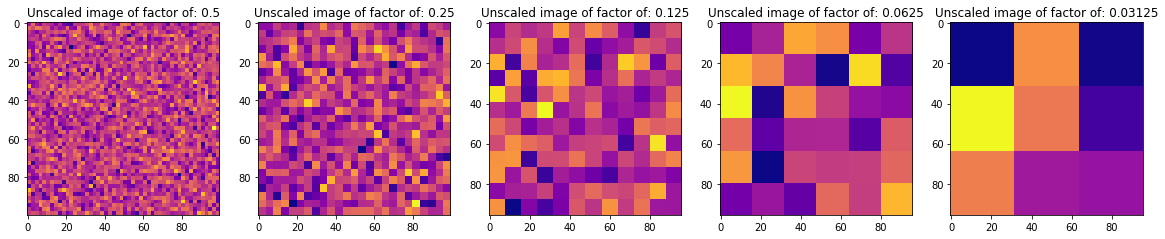

MS-SSIM=0.680


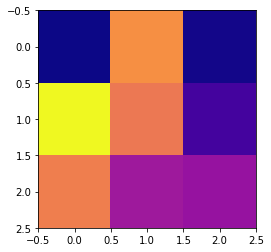

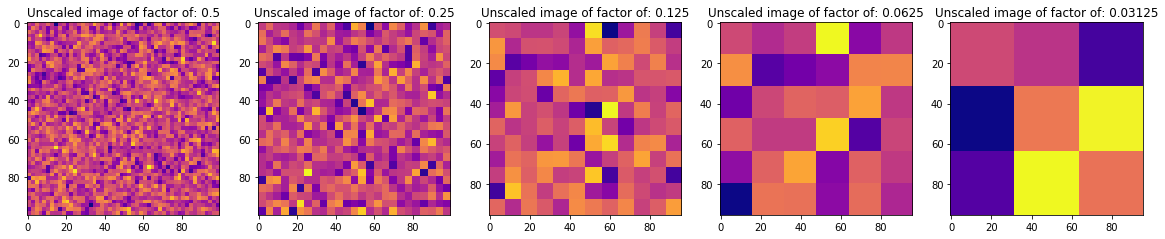

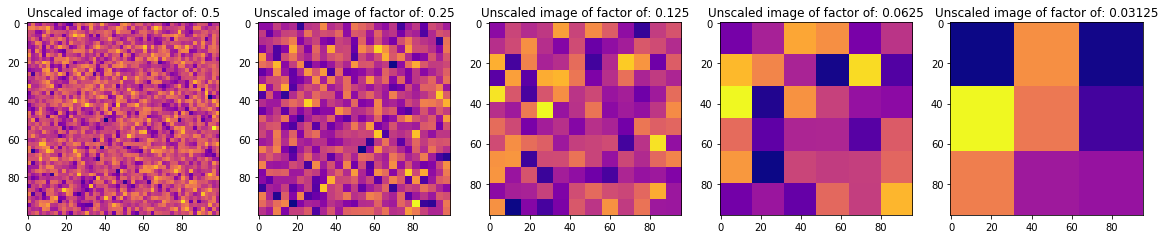

MS-SSIM=0.690


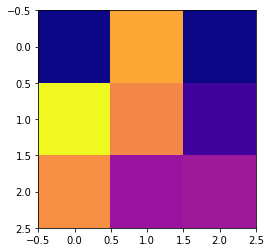

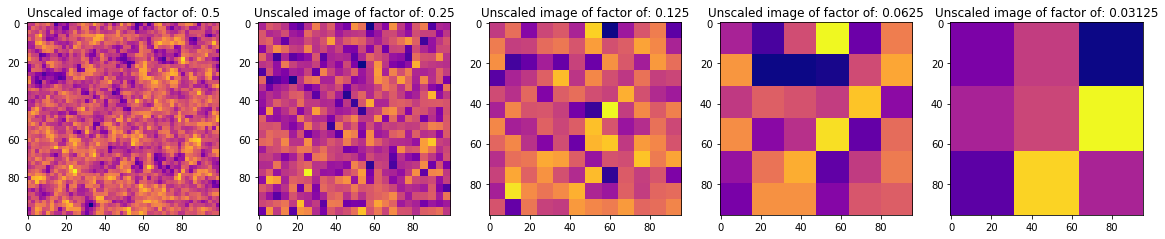

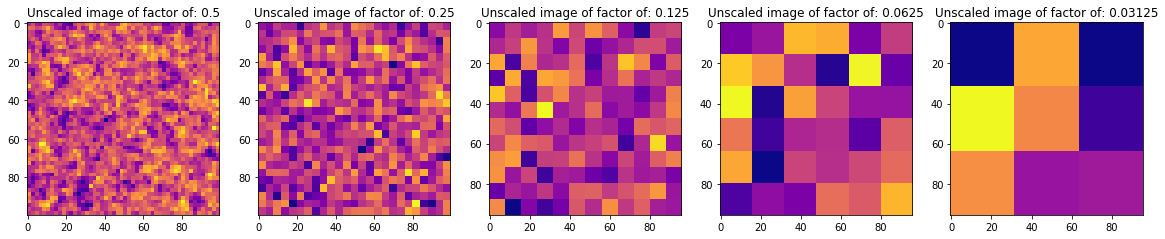

MS-SSIM=0.709


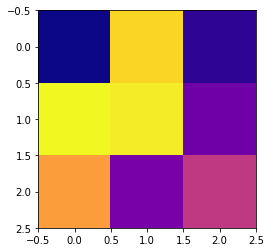

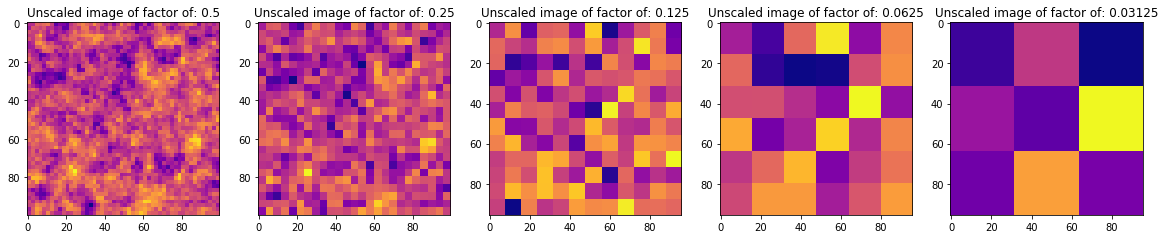

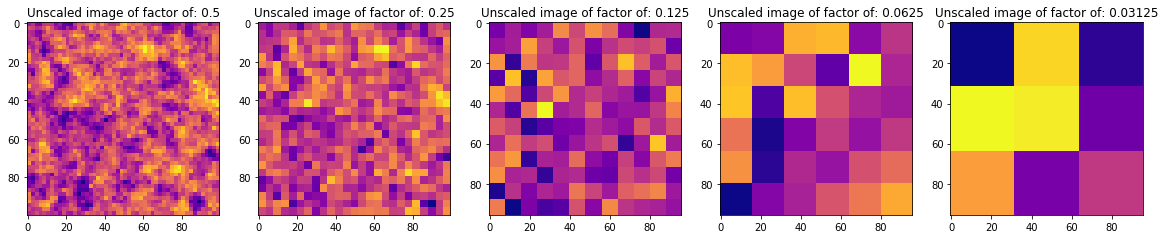

MS-SSIM=0.745


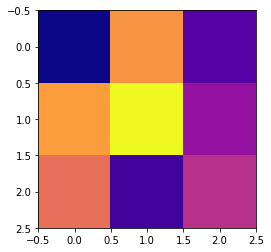

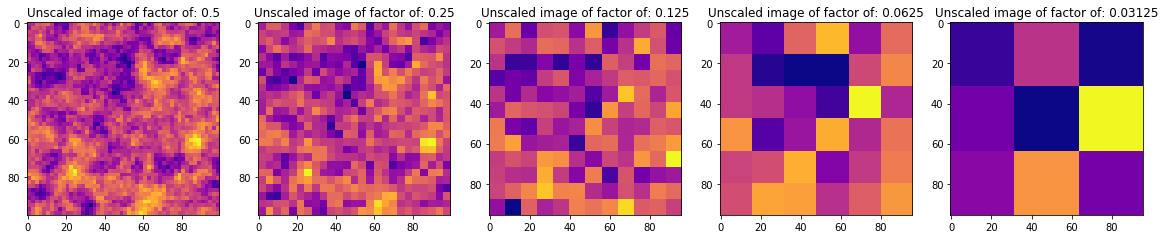

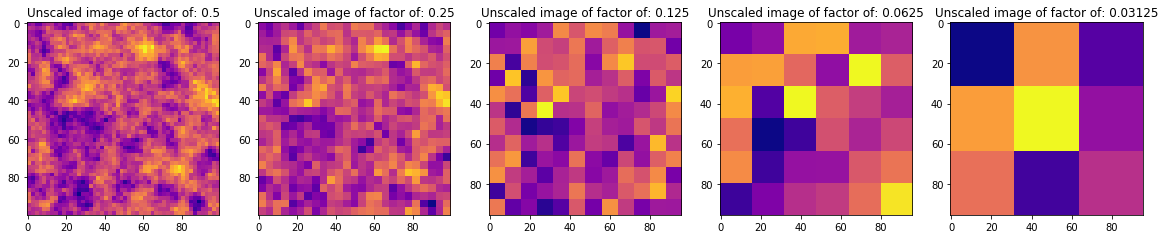

MS-SSIM=0.776


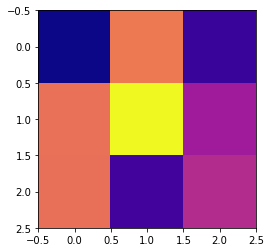

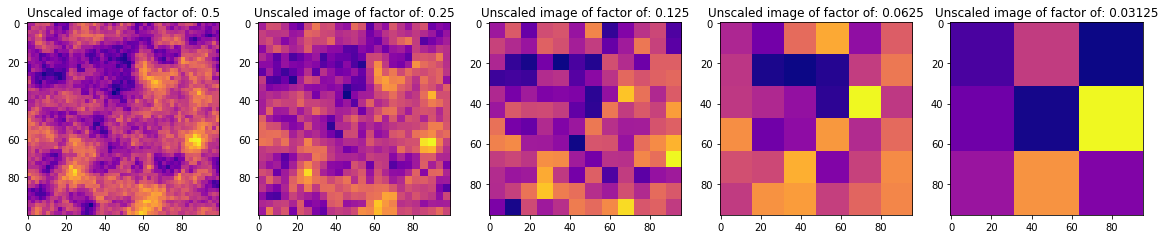

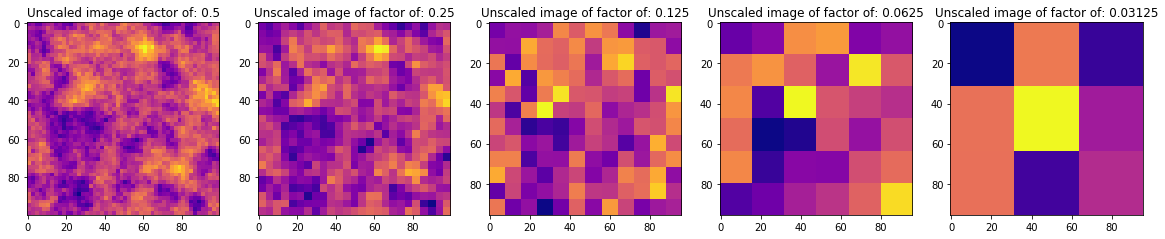

MS-SSIM=0.800


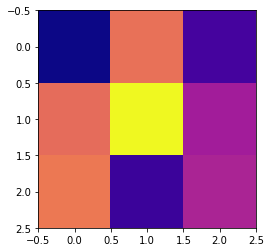

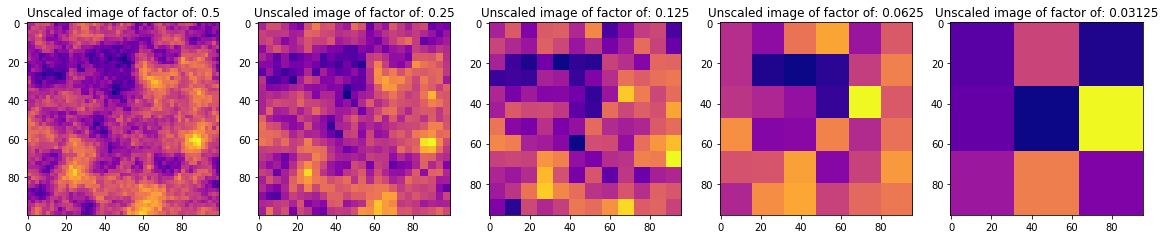

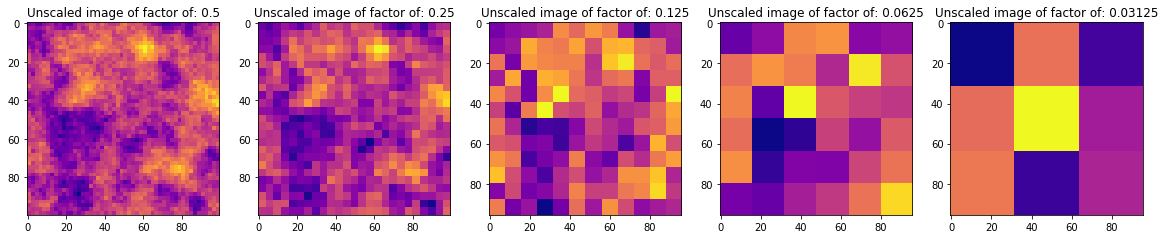

MS-SSIM=0.816


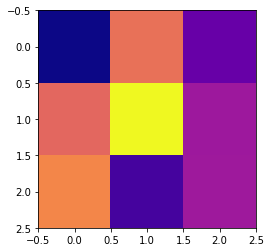

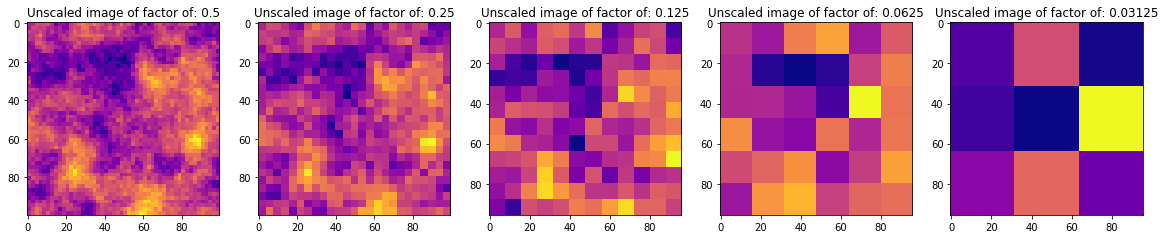

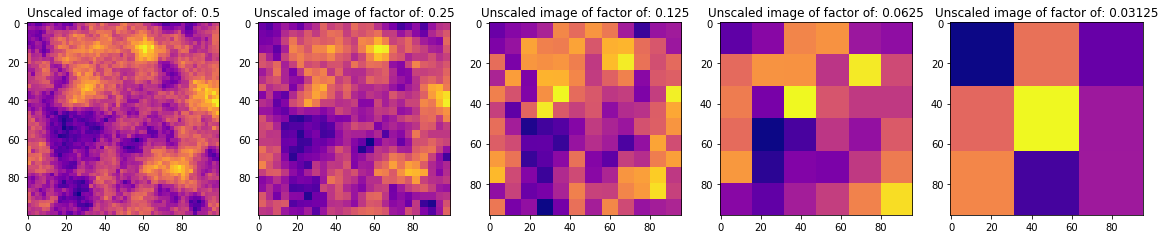

MS-SSIM=0.823


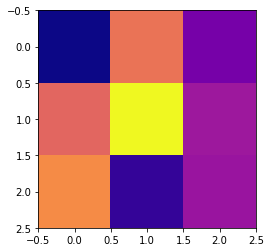

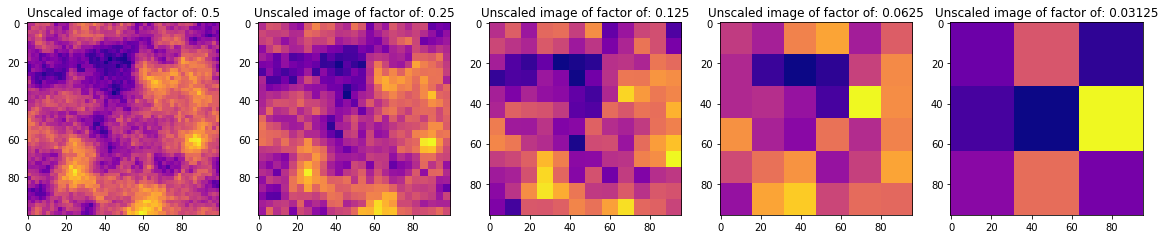

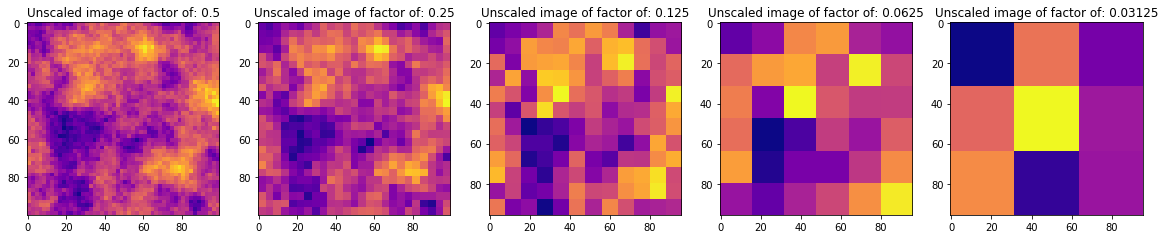

MS-SSIM=0.829


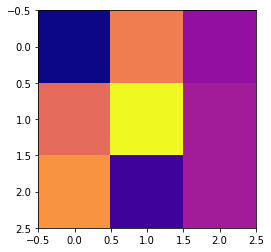

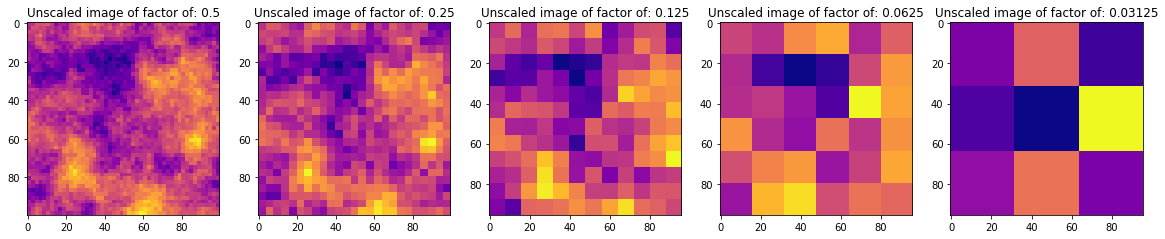

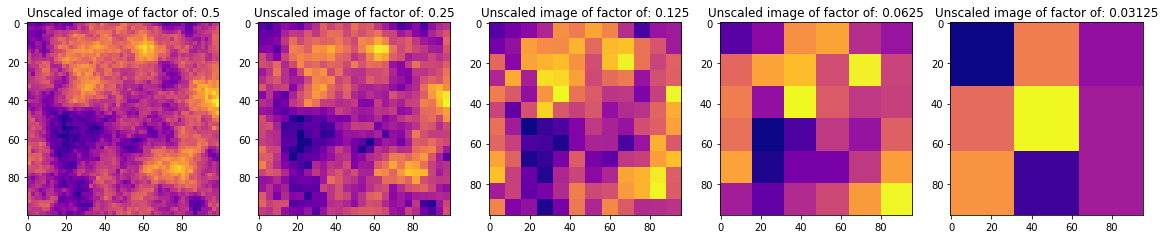

MS-SSIM=0.834


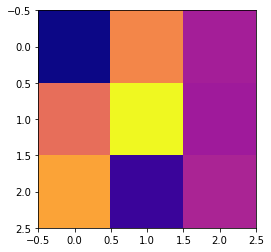

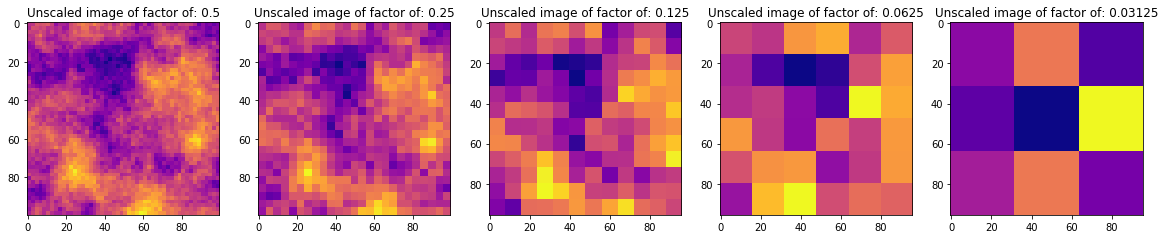

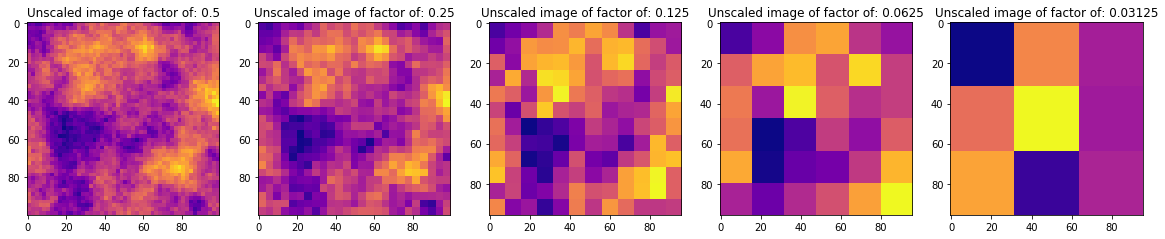

MS-SSIM=0.836


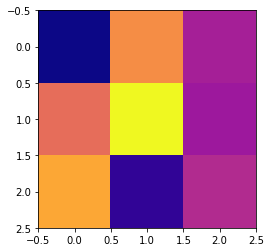

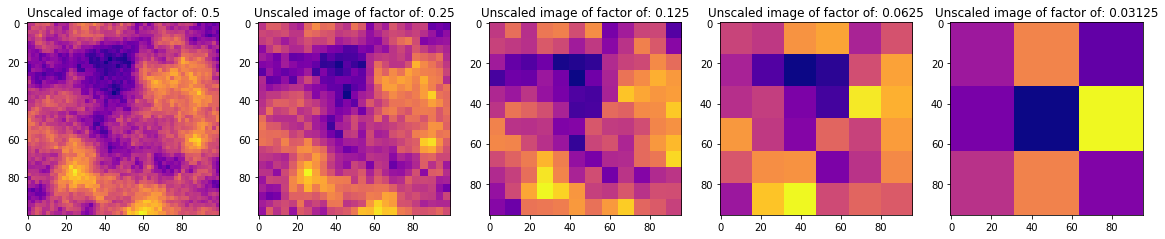

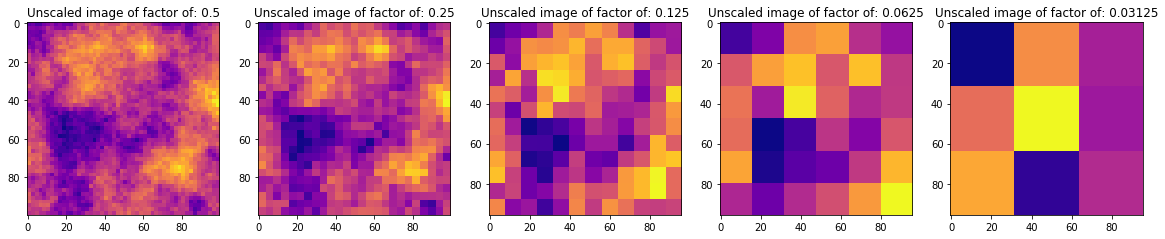

MS-SSIM=0.838


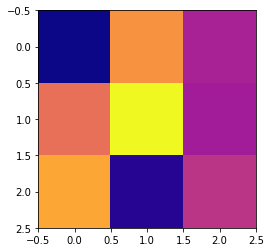

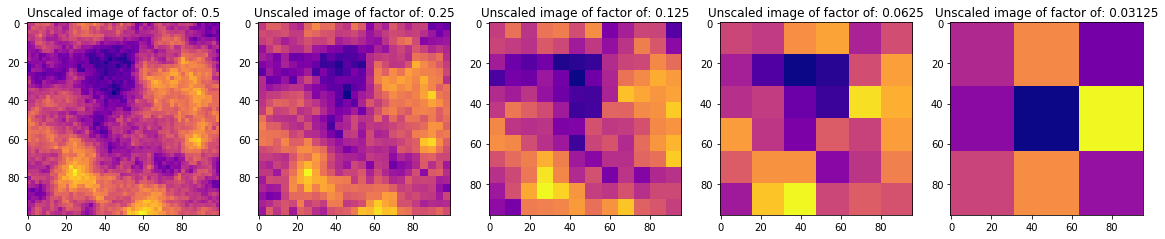

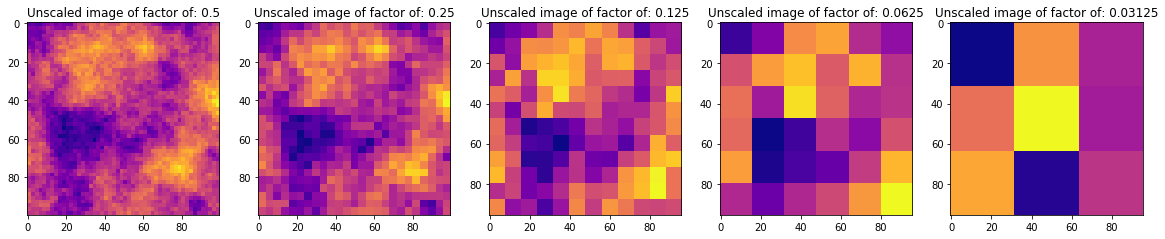

MS-SSIM=0.841


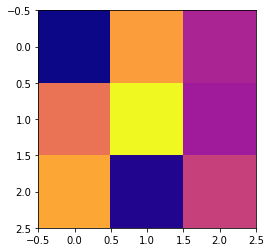

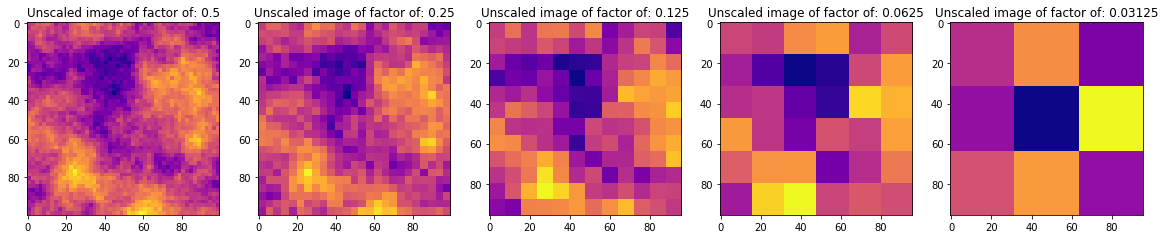

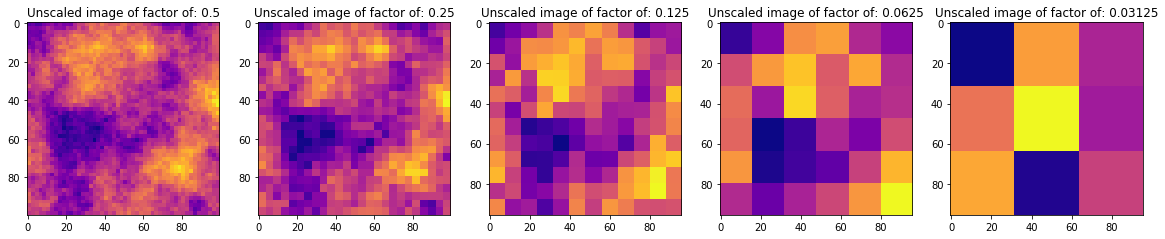

MS-SSIM=0.842


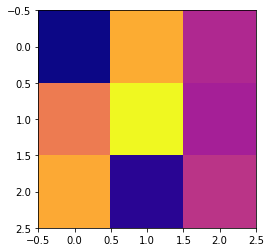

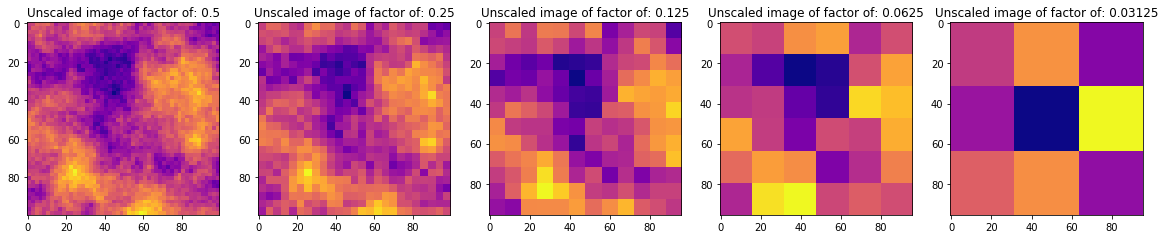

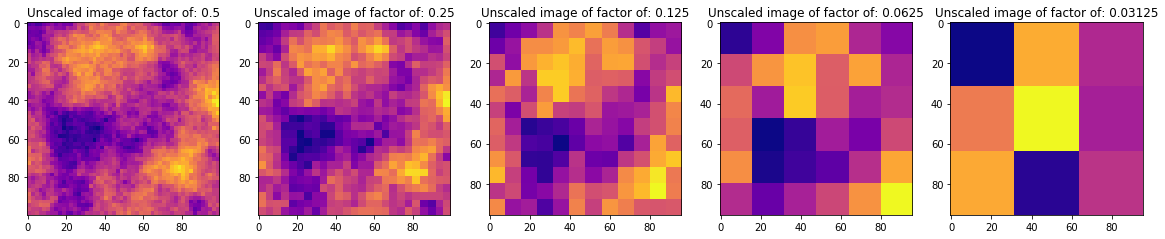

MS-SSIM=0.847


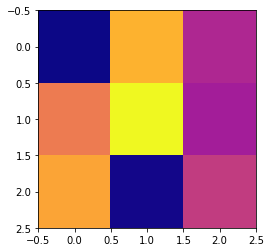

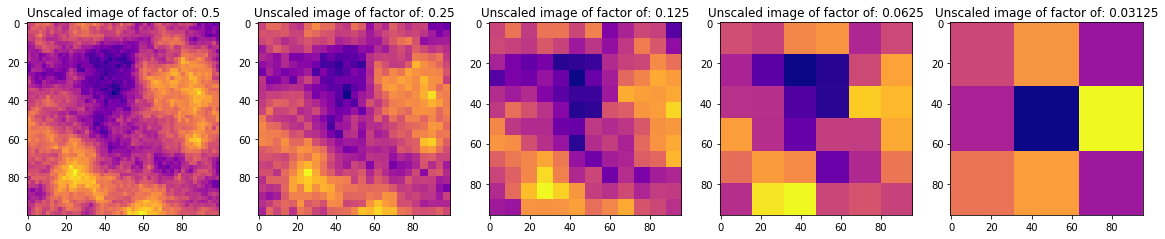

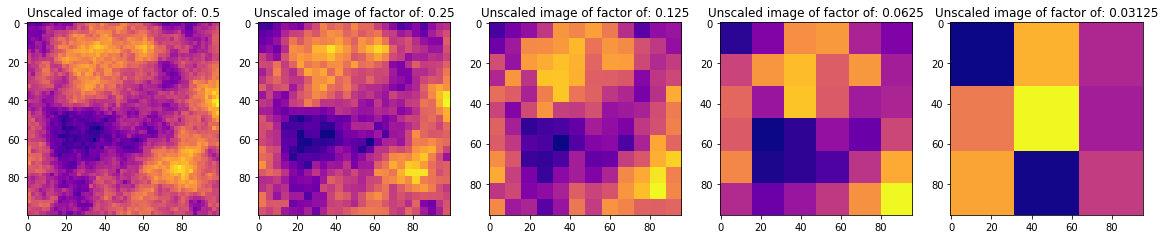

MS-SSIM=0.852


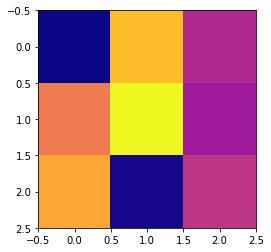

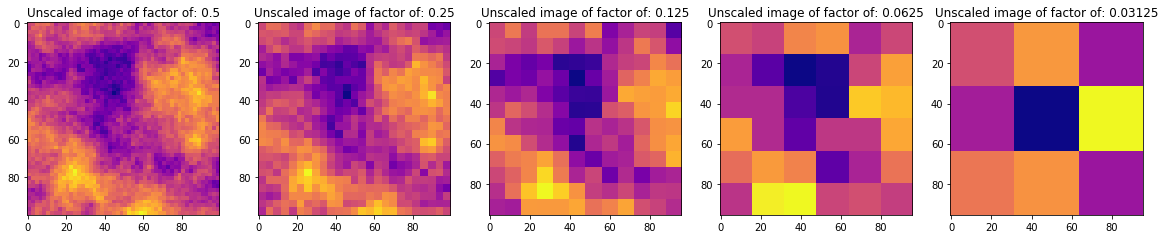

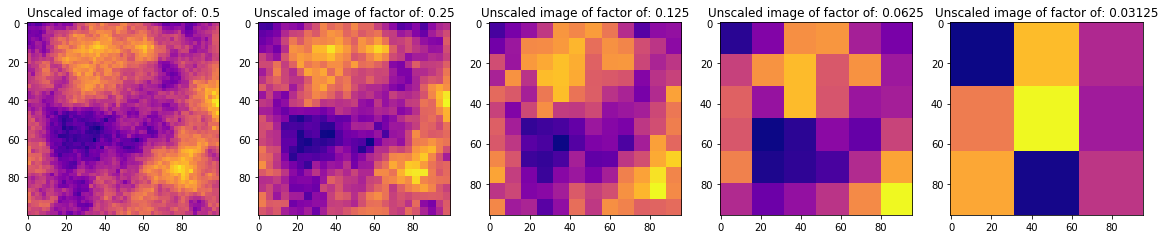

MS-SSIM=0.855


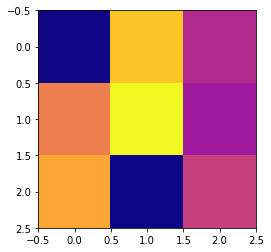

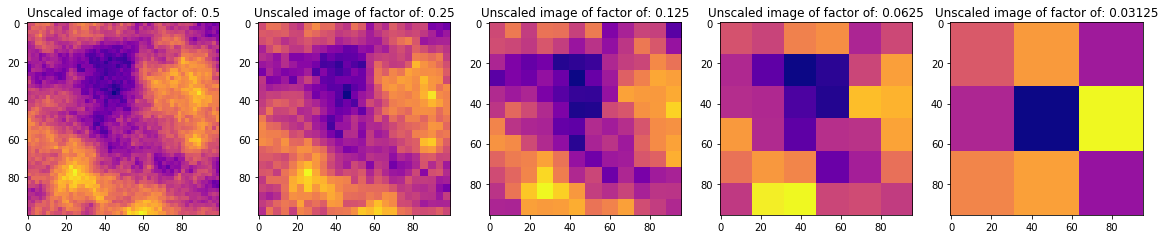

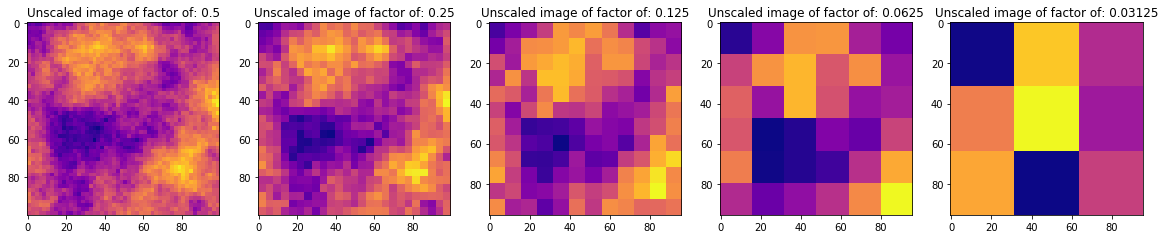

MS-SSIM=0.858


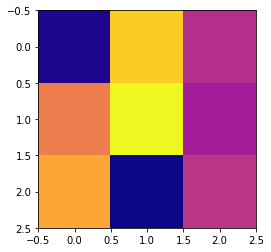

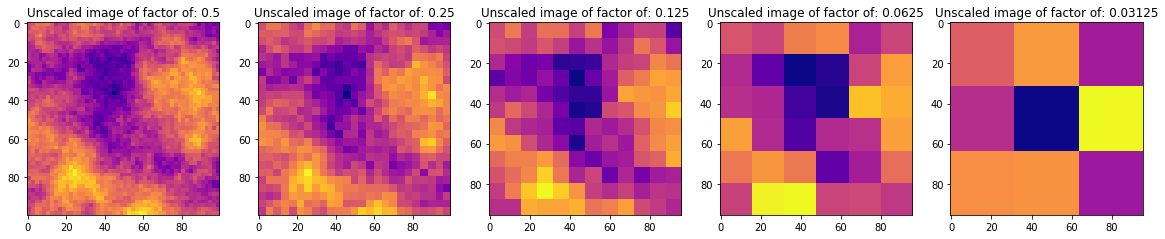

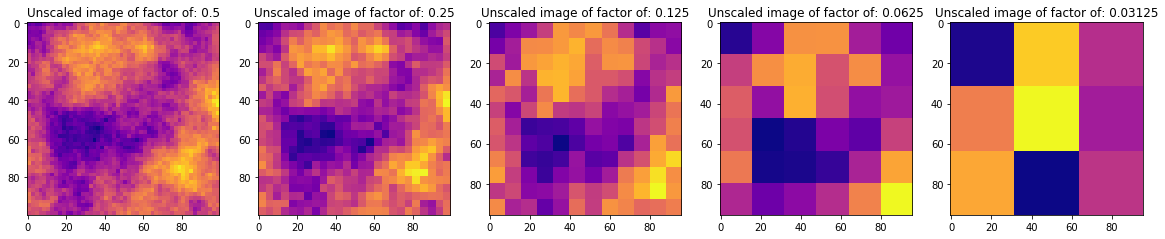

MS-SSIM=0.863


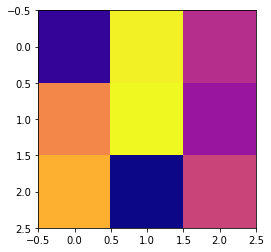

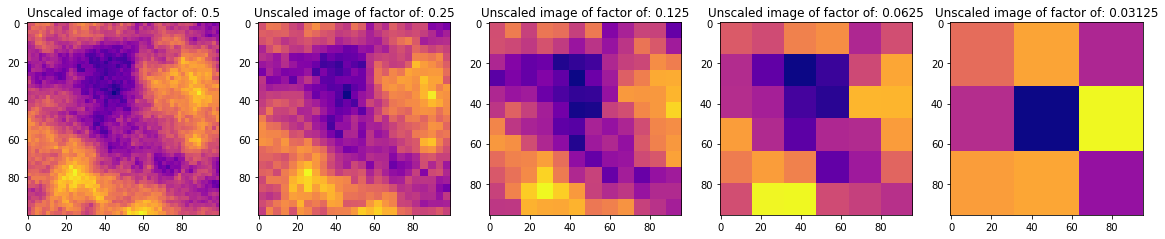

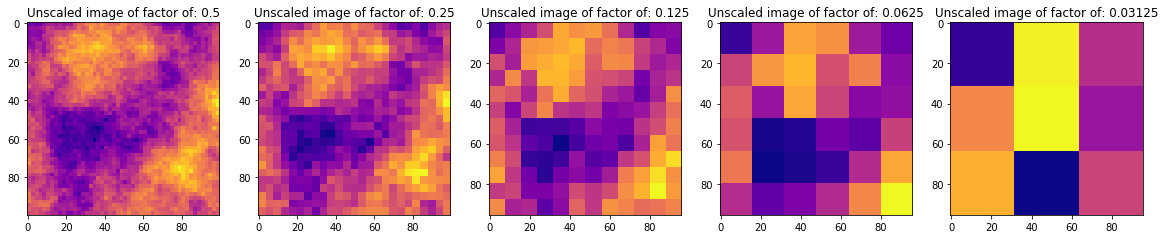

MS-SSIM=0.868


NameError: name 'MS_SSIM_var' is not defined

In [78]:
MS_SSIM_var_rot = np.zeros(len(simulations))
SSIM_var_rot = np.zeros(len(simulations))
mse_var_rot = np.zeros(len(simulations))
for i in range(len(simulations)):
    MS_SSIM_var_rot[i] = MSSSIM_ww(simulations[i], sim_rotated[i])
    SSIM_var_rot[i] = SSIM_ww(simulations[i],sim_rotated[i])
    mse_var_rot[i] = mean_squared_error(simulations[i], sim_rotated[i])
MS_SSIM_var
SSIM_var

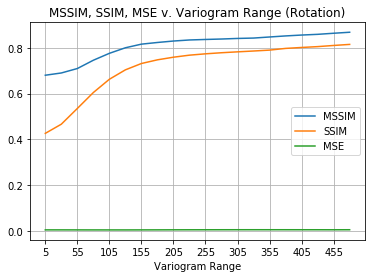

In [79]:
plt.figure()
plt.plot(MS_SSIM_var_rot, label='MSSIM')
plt.plot(SSIM_var_rot, label='SSIM')
plt.plot(mse_var_rot, label='MSE')
plt.xticks(range(0, len(ranges_maj),2), ranges_maj[::2])

plt.xlabel('Variogram Range')
plt.title('MSSIM, SSIM, MSE v. Variogram Range (Rotation)')
plt.legend(); plt.grid('on')


## Variogram Range and Translation

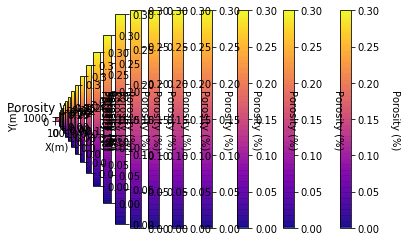

In [80]:
sim_translated = np.zeros((len(simulations),100,100))
for i in range(len(simulations)):
    sim_translated[i] = resize(window(simulations[i],25,25,50,50),(100,100))

Text(0.5, 1.0, 'Variogram Range of: 480')

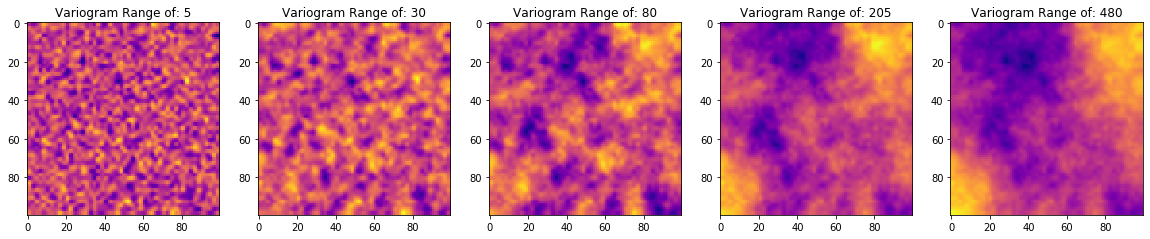

In [81]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(sim_translated[0], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[0]))

plt.subplot(152)
plt.imshow(sim_translated[1], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[1]))

plt.subplot(153)
plt.imshow(sim_translated[3], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[3]))

plt.subplot(154)
plt.imshow(sim_translated[8], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[8]))

plt.subplot(155)
plt.imshow(sim_translated[19], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[19]))

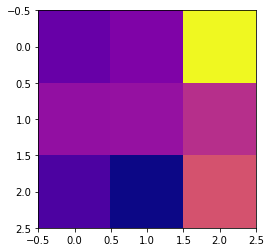

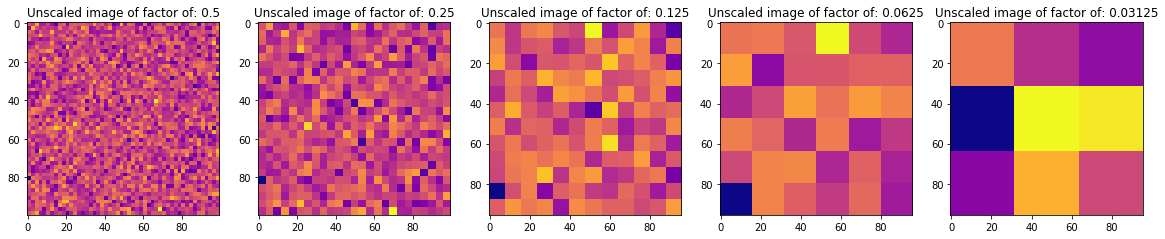

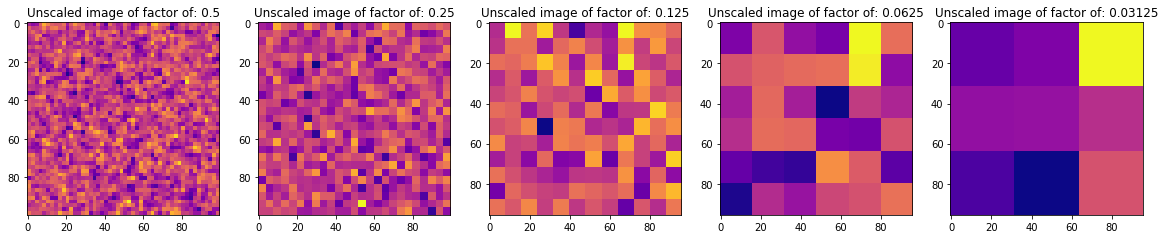

MS-SSIM=0.742


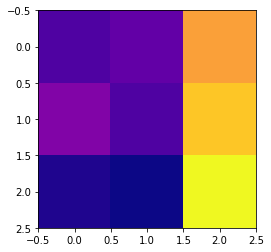

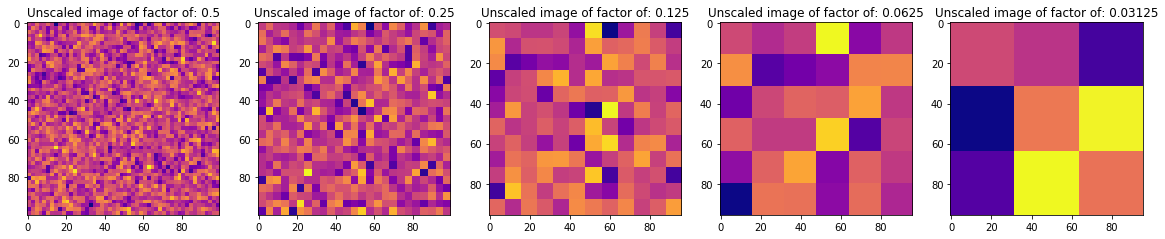

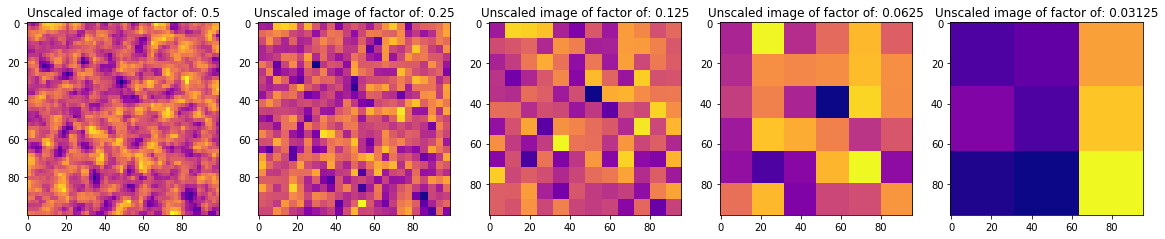

MS-SSIM=0.726


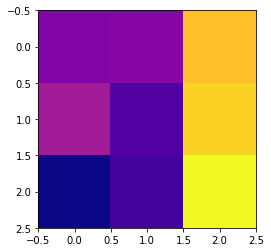

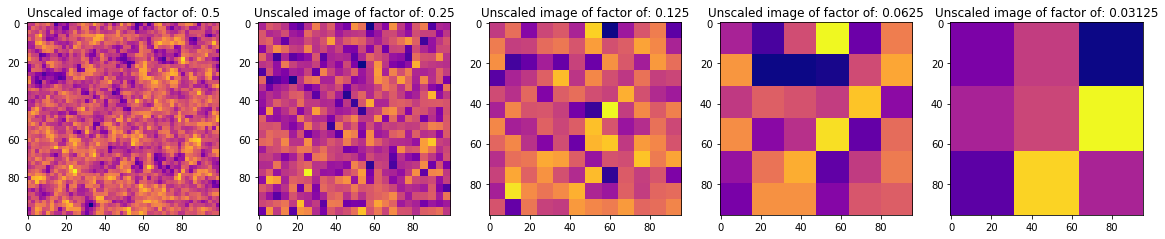

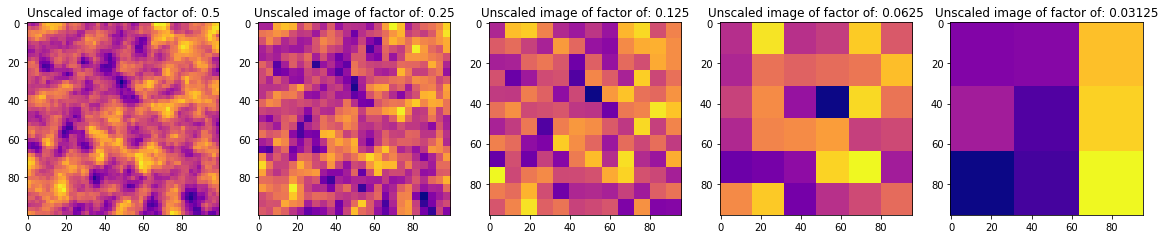

MS-SSIM=0.744


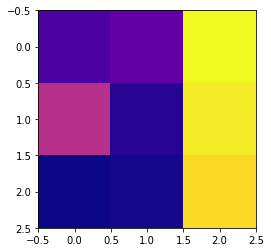

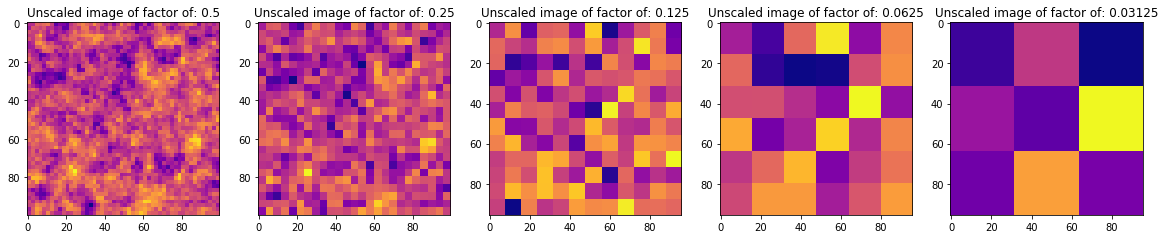

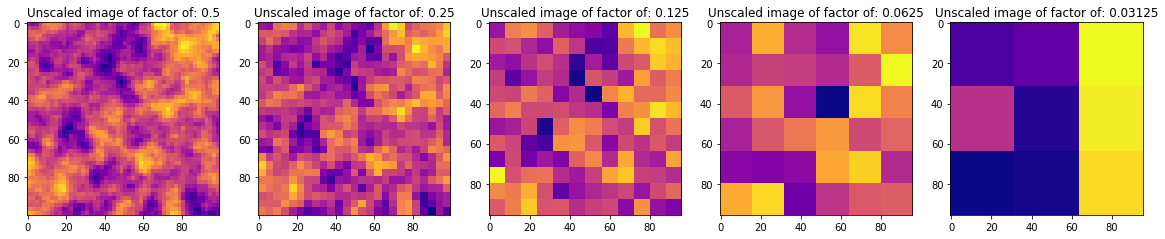

MS-SSIM=0.791


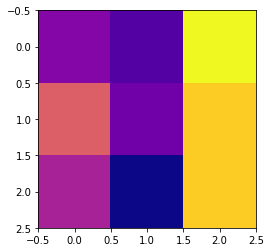

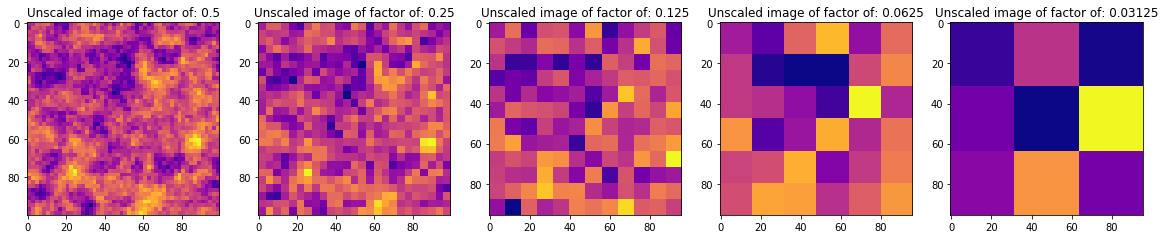

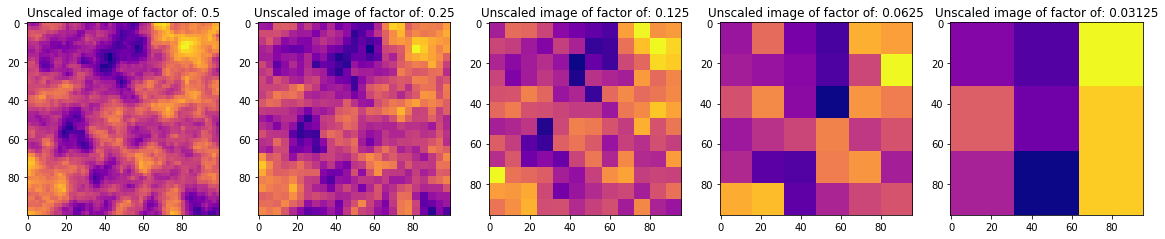

MS-SSIM=0.824


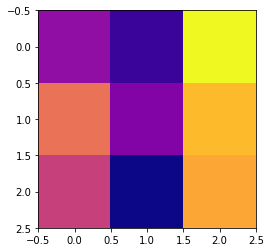

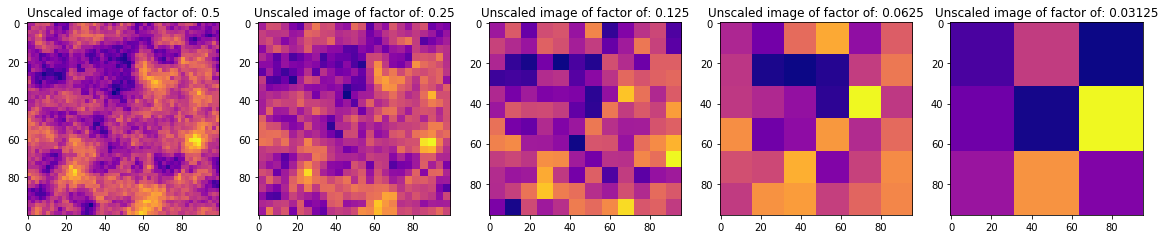

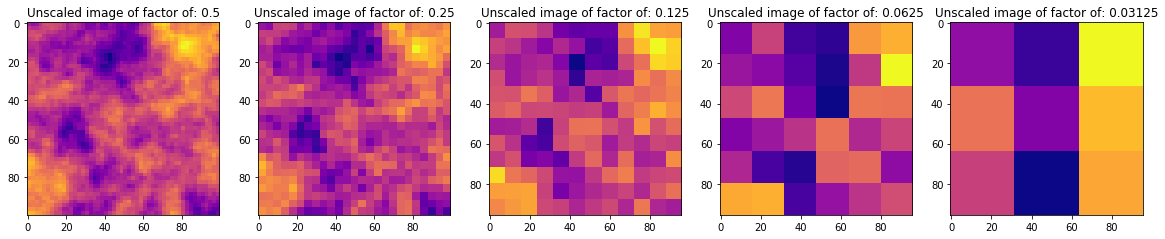

MS-SSIM=0.842


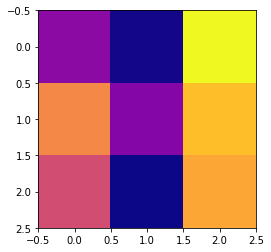

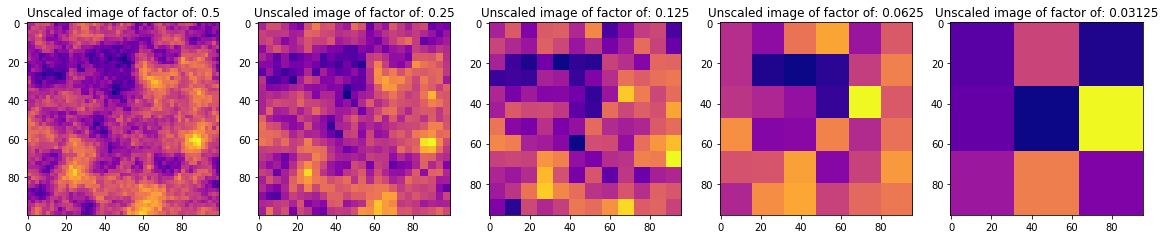

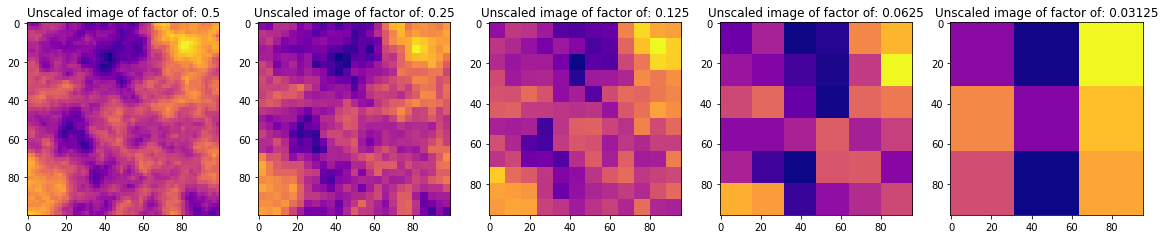

MS-SSIM=0.855


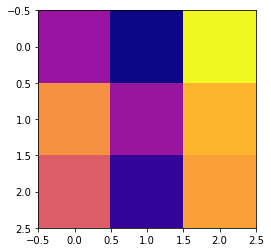

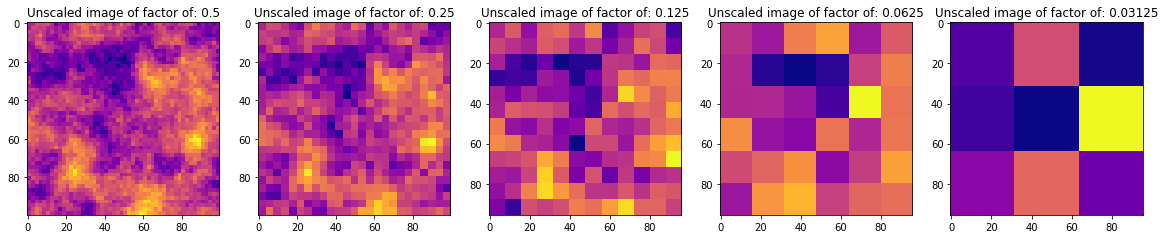

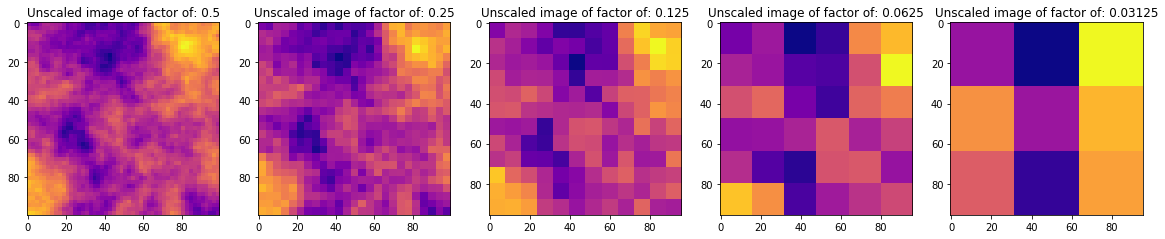

MS-SSIM=0.861


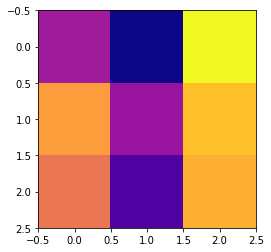

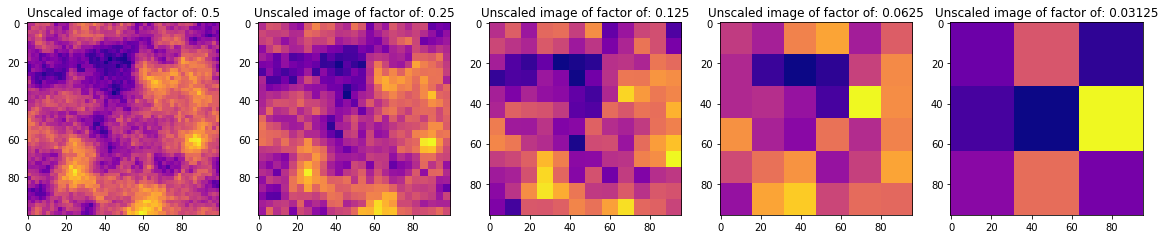

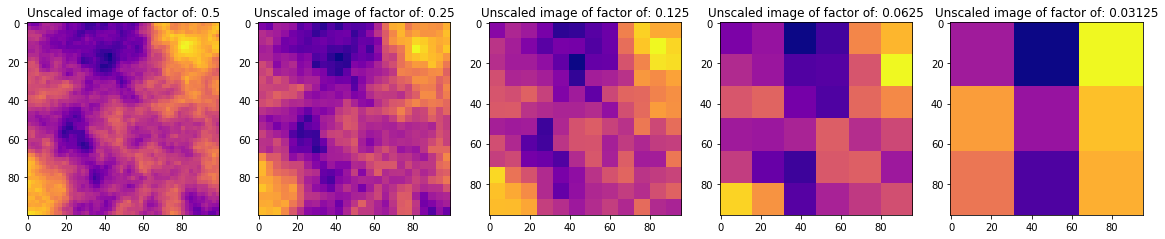

MS-SSIM=0.870


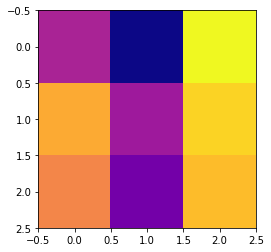

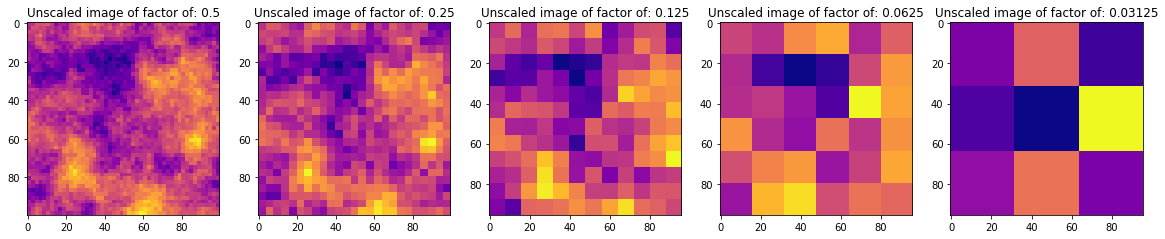

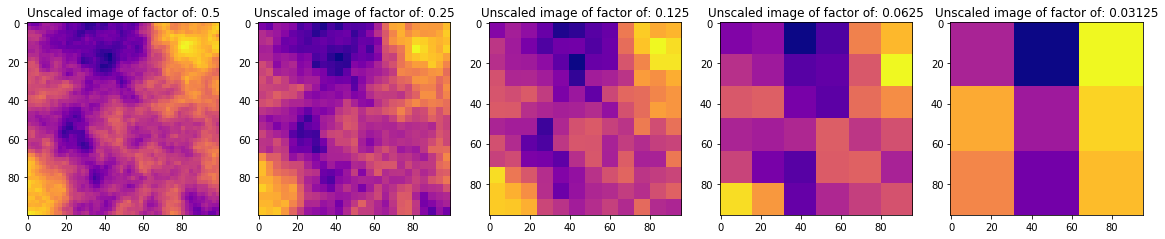

MS-SSIM=0.878


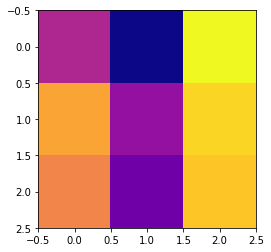

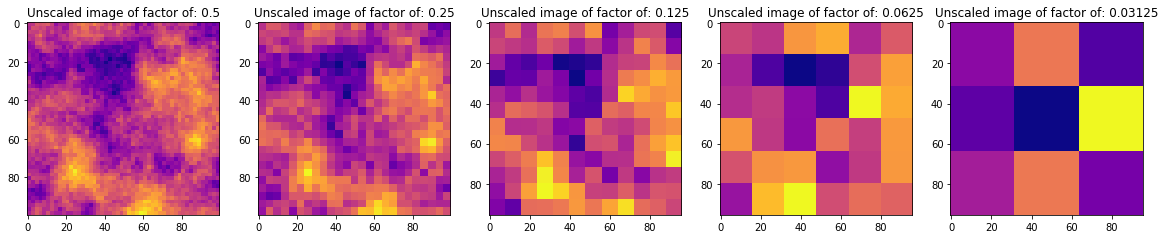

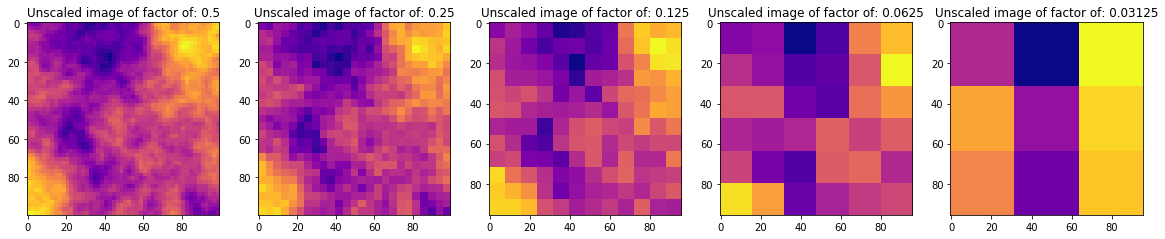

MS-SSIM=0.881


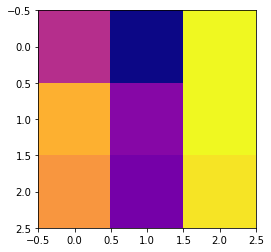

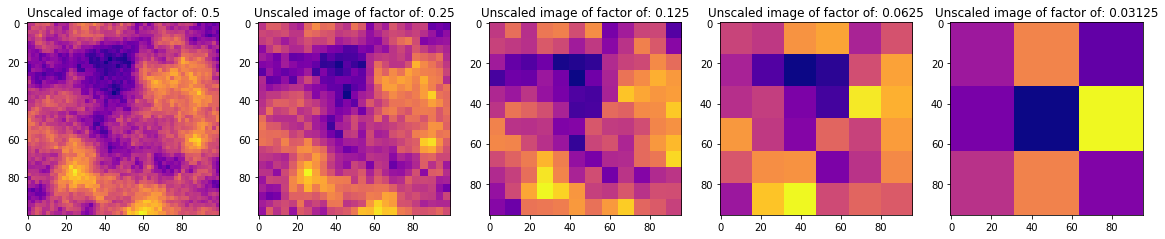

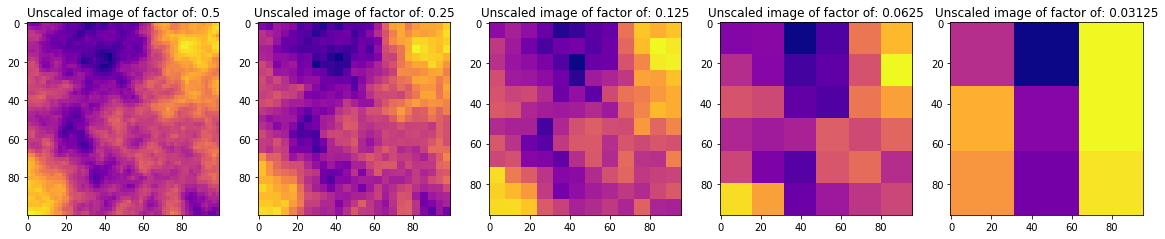

MS-SSIM=0.888


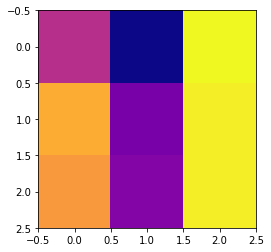

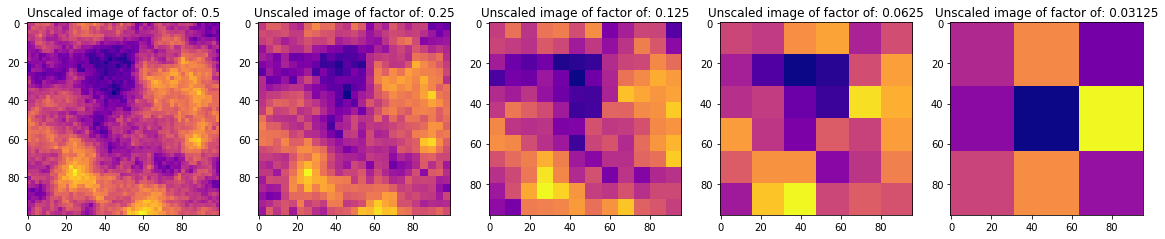

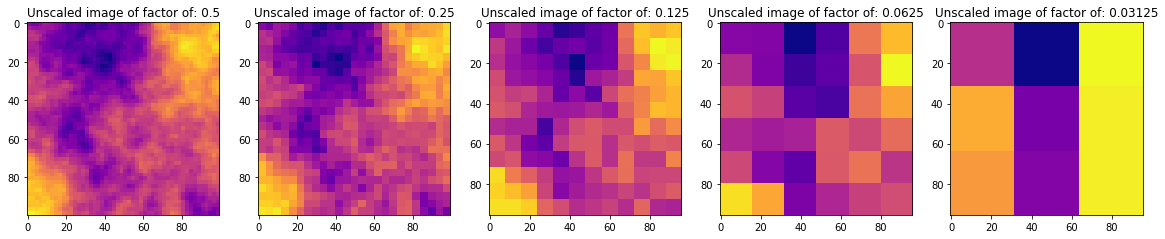

MS-SSIM=0.893


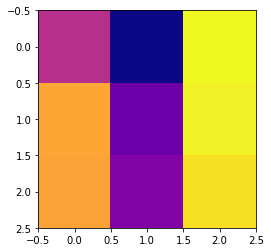

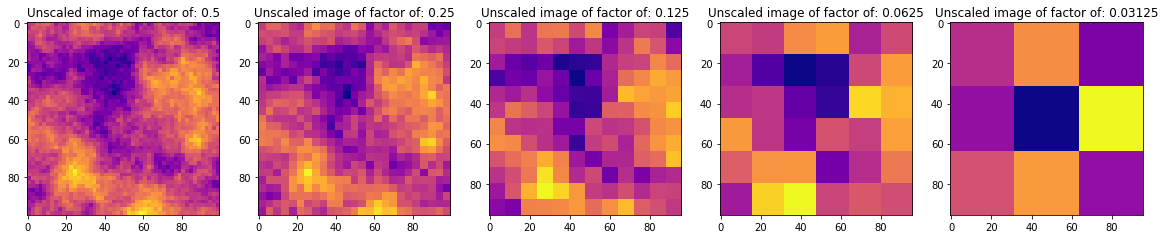

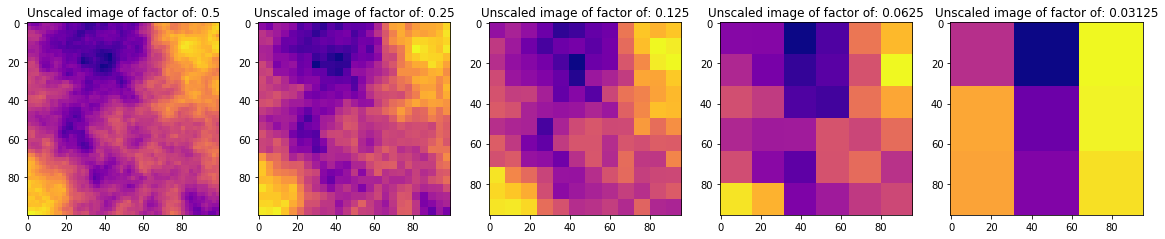

MS-SSIM=0.896


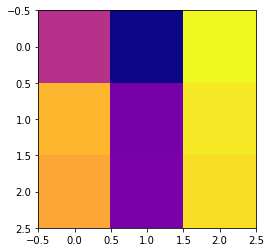

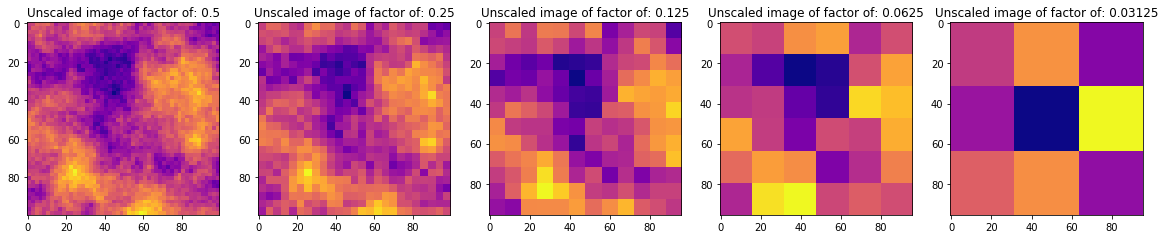

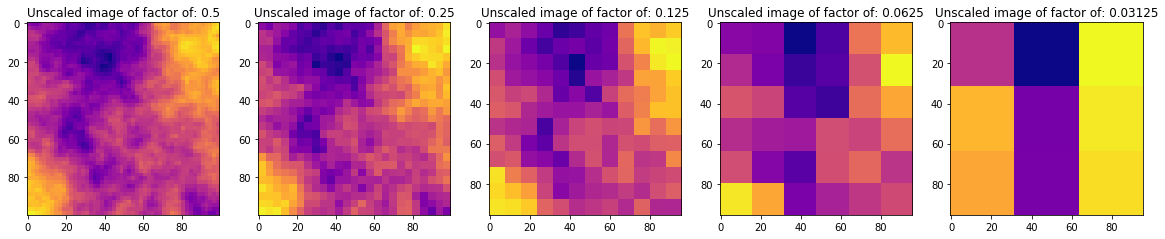

MS-SSIM=0.900


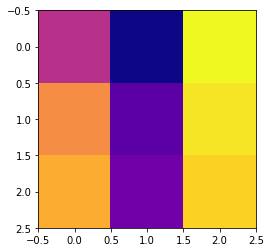

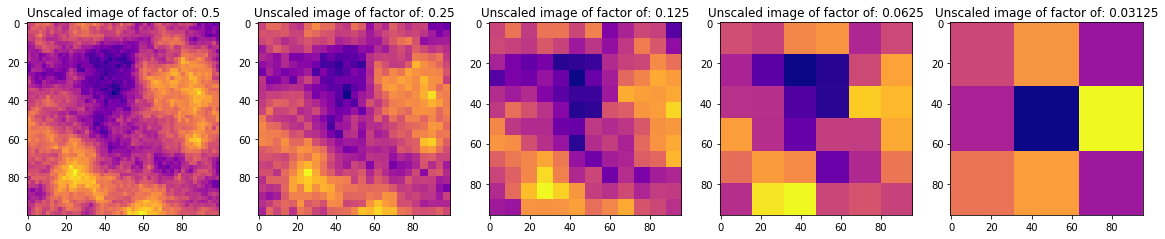

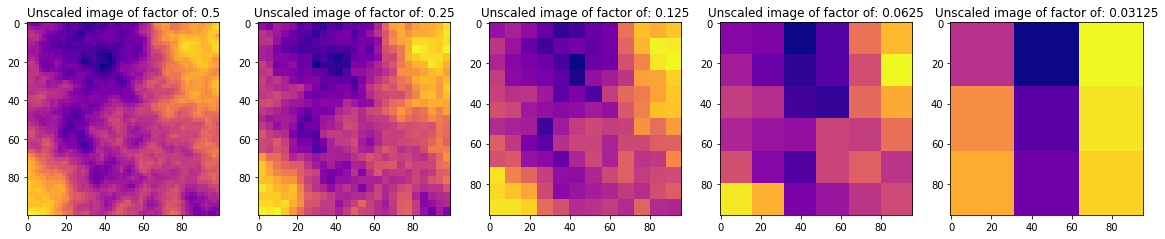

MS-SSIM=0.906


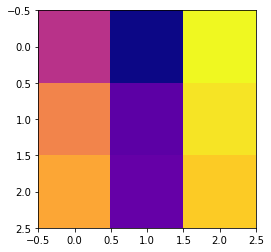

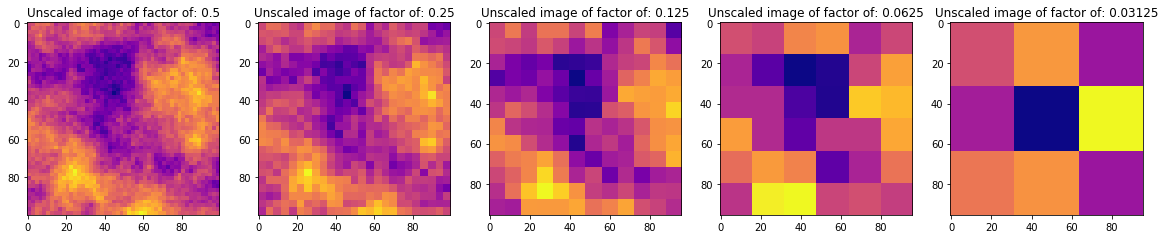

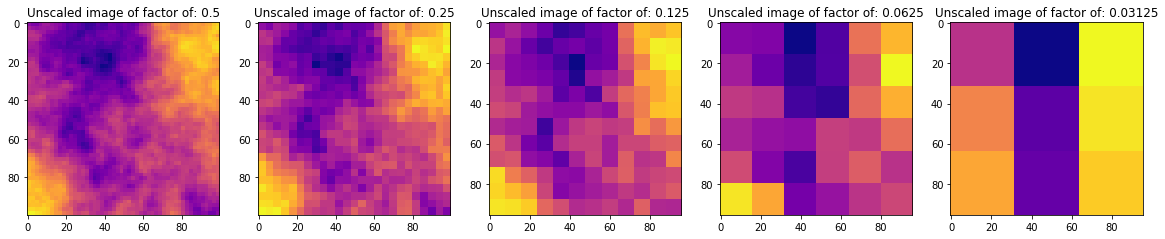

MS-SSIM=0.909


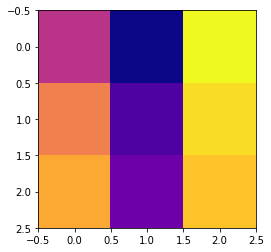

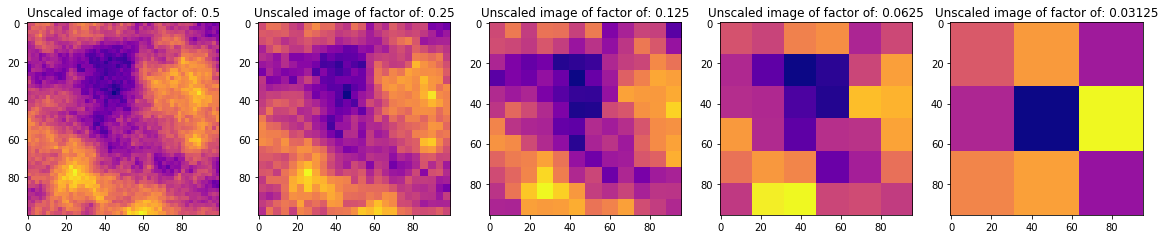

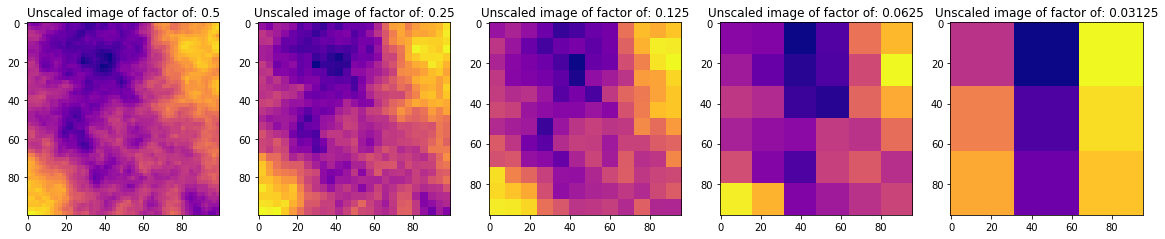

MS-SSIM=0.912


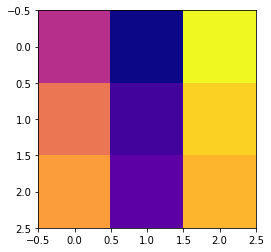

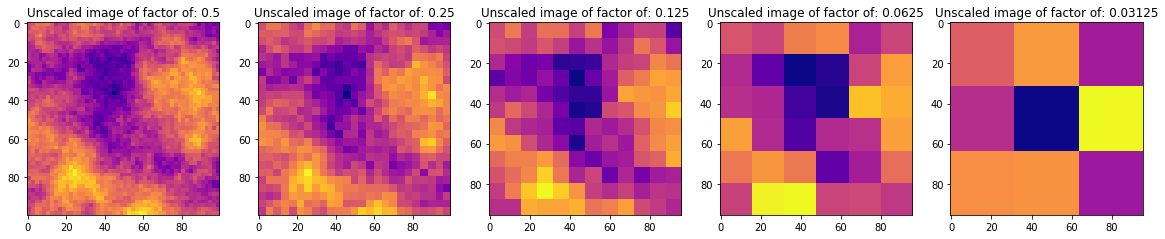

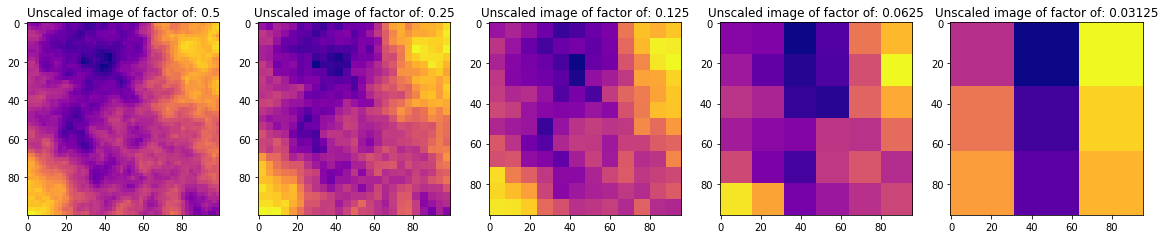

MS-SSIM=0.914


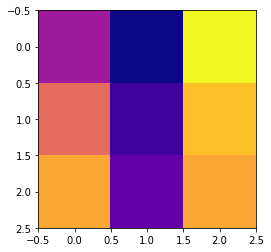

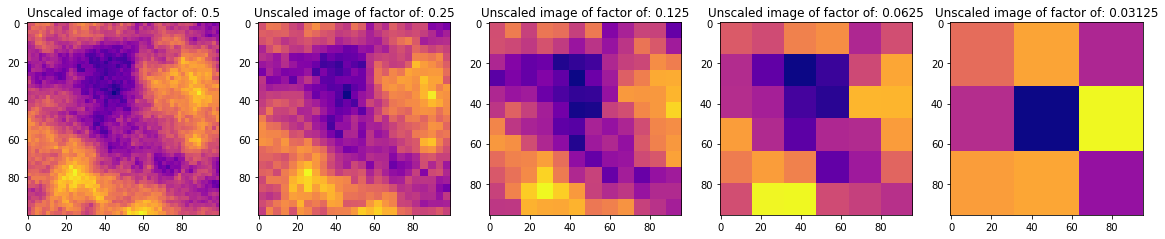

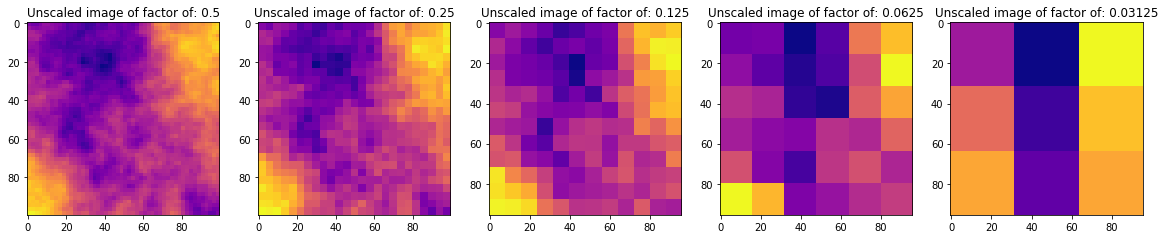

MS-SSIM=0.919


In [82]:
MS_SSIM_var_tran = np.zeros(len(simulations))
SSIM_var_tran = np.zeros(len(simulations))
mse_var_tran = np.zeros(len(simulations))
for i in range(len(simulations)):
    MS_SSIM_var_tran[i] = MSSSIM_ww(simulations[i], sim_translated[i])
    SSIM_var_tran[i] = SSIM_ww(simulations[i],sim_translated[i])
    mse_var_tran[i] = mean_squared_error(simulations[i], sim_translated[i])


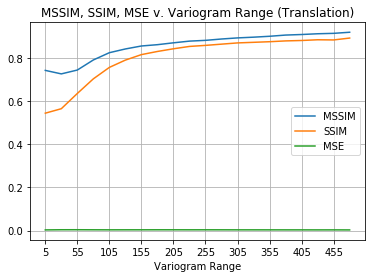

In [83]:
plt.figure()
plt.plot(MS_SSIM_var_tran, label='MSSIM')
plt.plot(SSIM_var_tran, label='SSIM')
plt.plot(mse_var_tran, label='MSE')
plt.xticks(range(0, len(ranges_maj),2), ranges_maj[::2])

plt.xlabel('Variogram Range')
plt.title('MSSIM, SSIM, MSE v. Variogram Range (Translation)')
plt.legend(); plt.grid('on')


## Variogram Range and Scale

In [84]:
sim_upscale = np.zeros((len(simulations),100,100))
for i in range(len(simulations)):
    sim_upscale[i] = resize(rescale(simulations[i],0.1), (100,100))
    

Text(0.5, 1.0, 'Variogram Range of: 480')

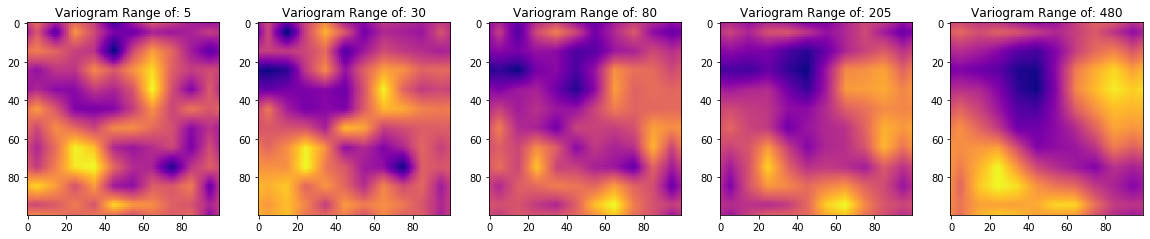

In [85]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(sim_upscale[0], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[0]))

plt.subplot(152)
plt.imshow(sim_upscale[1], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[1]))

plt.subplot(153)
plt.imshow(sim_upscale[3], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[3]))

plt.subplot(154)
plt.imshow(sim_upscale[8], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[8]))

plt.subplot(155)
plt.imshow(sim_upscale[19], cmap=cmap)
plt.title('Variogram Range of: {}'.format(ranges_maj[19]))

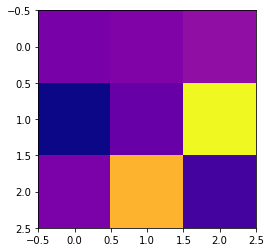

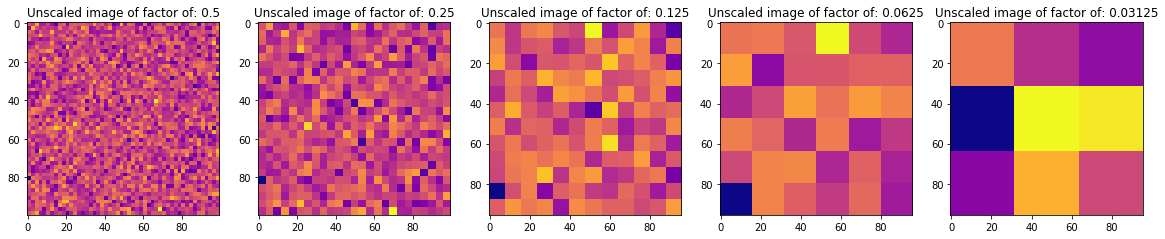

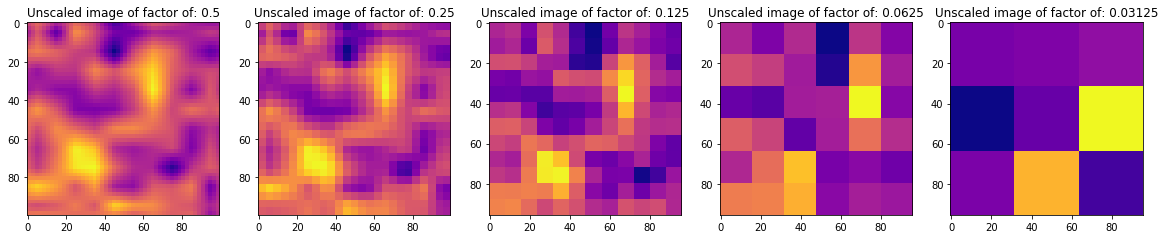

MS-SSIM=0.824


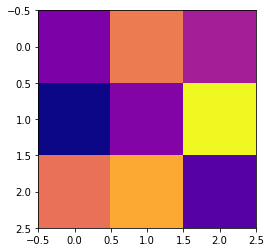

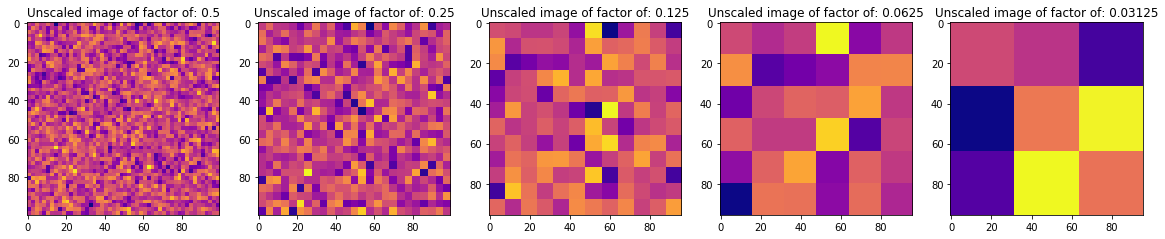

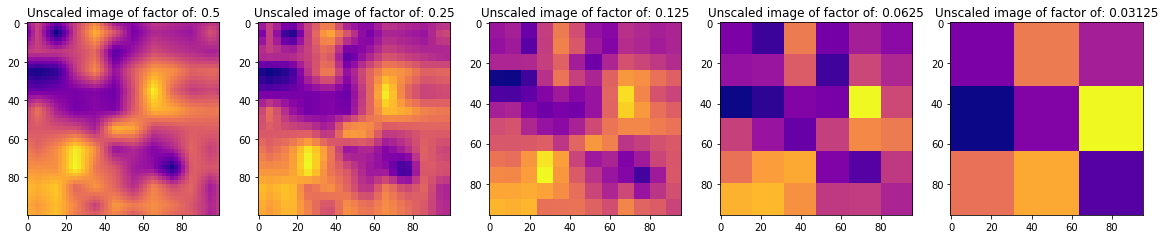

MS-SSIM=0.825


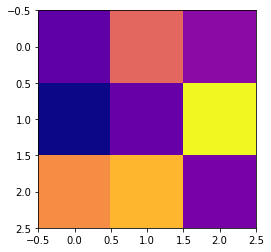

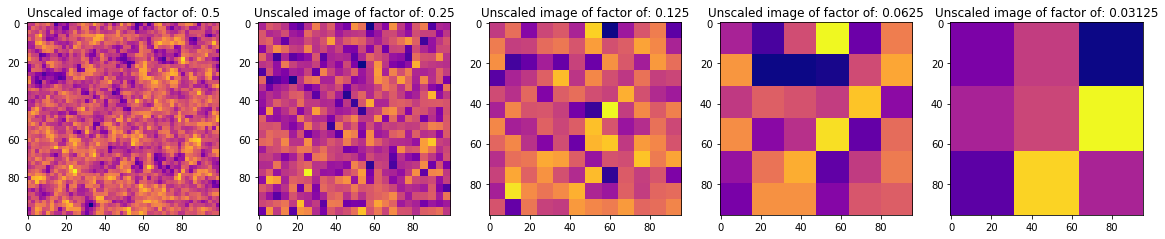

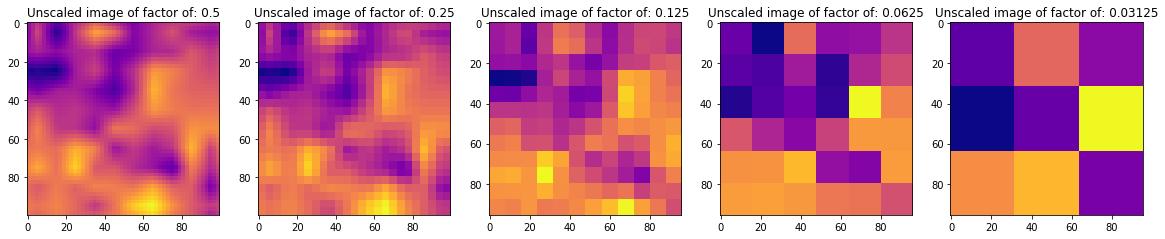

MS-SSIM=0.837


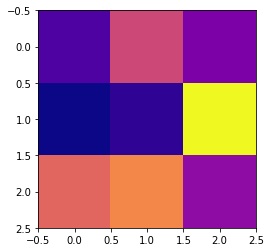

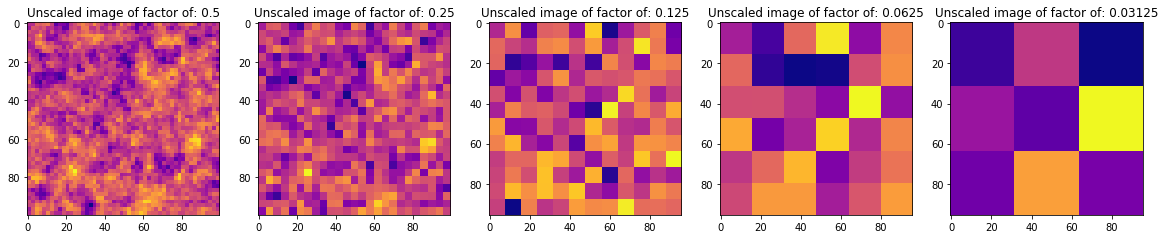

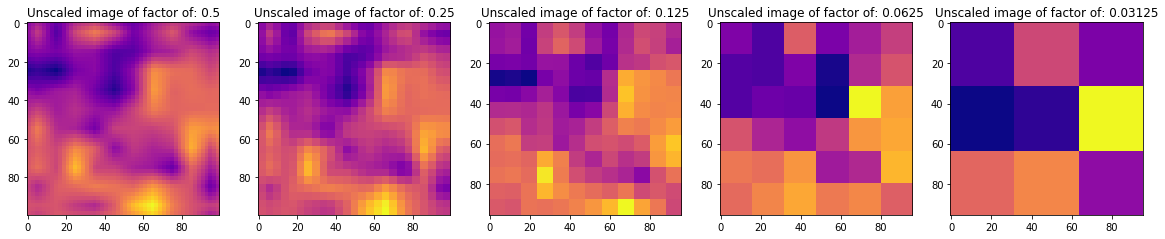

MS-SSIM=0.864


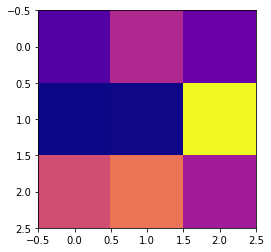

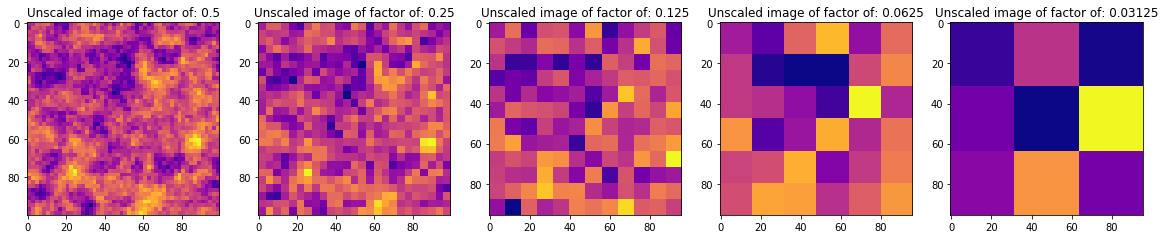

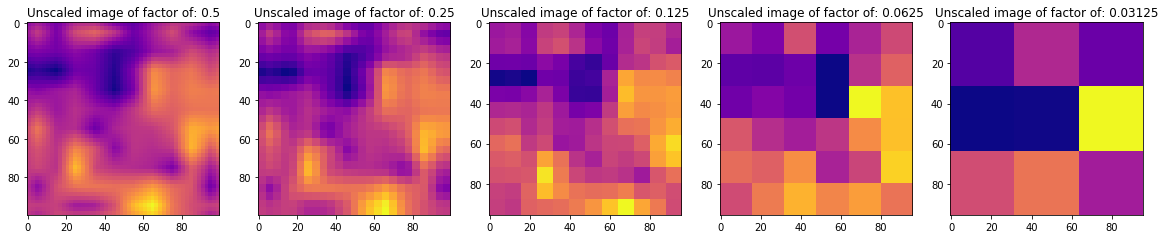

MS-SSIM=0.891


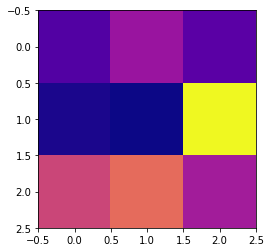

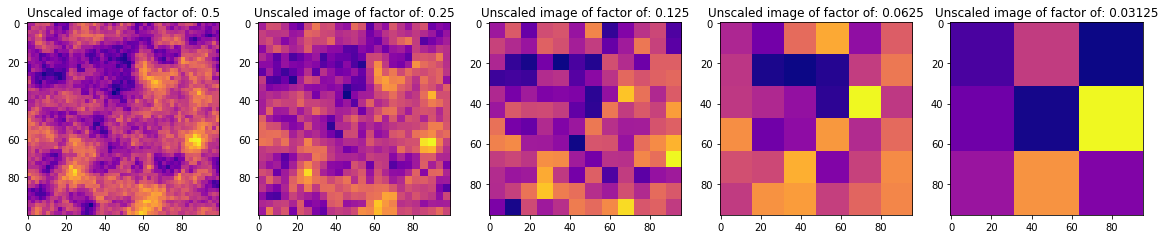

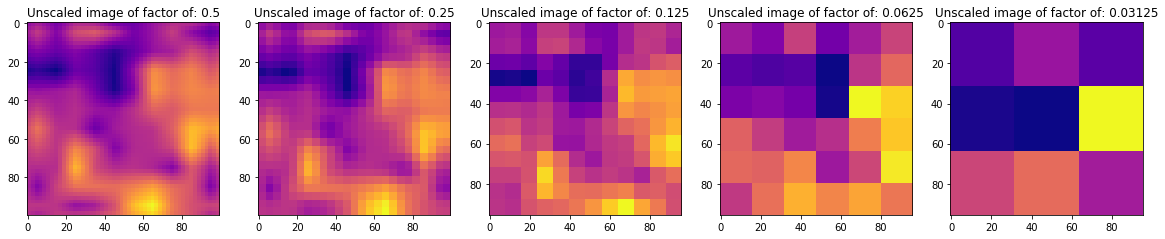

MS-SSIM=0.911


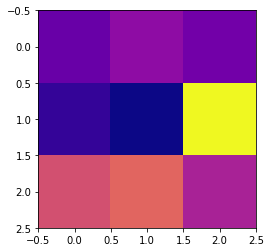

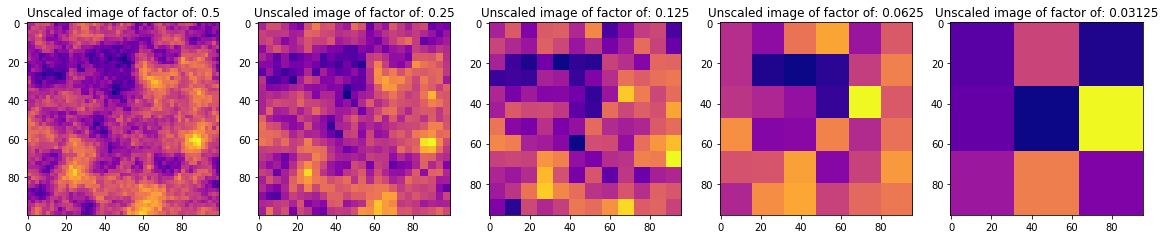

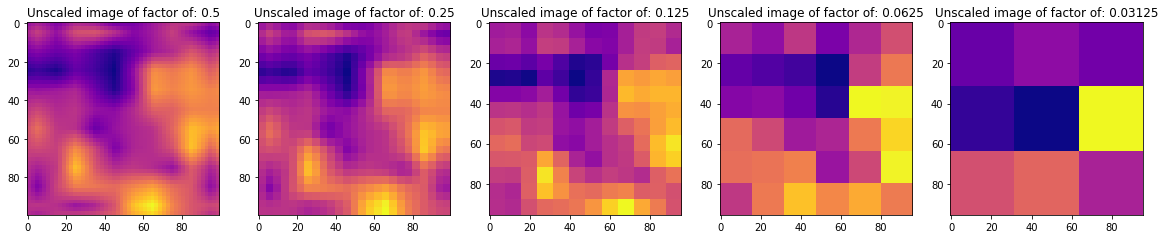

MS-SSIM=0.927


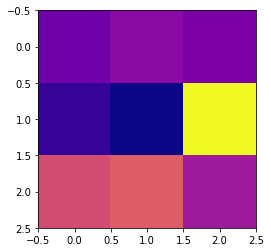

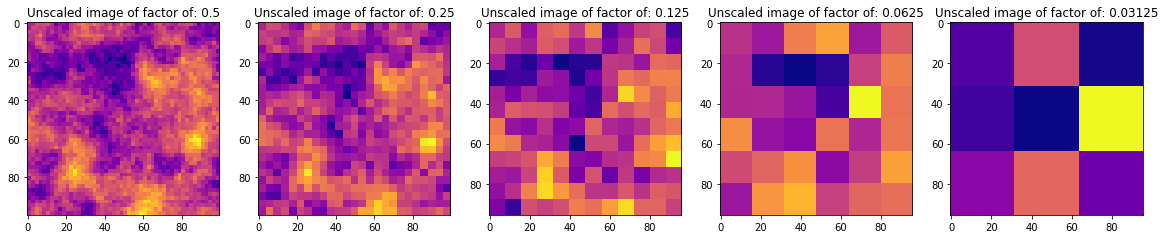

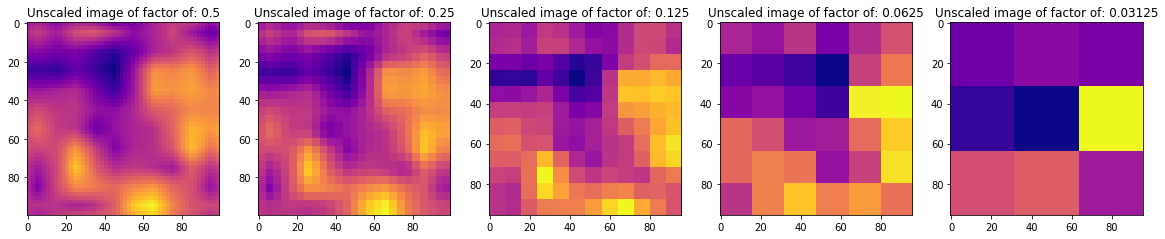

MS-SSIM=0.937


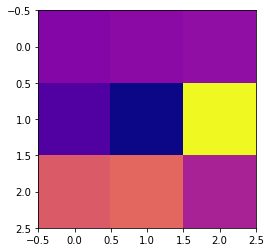

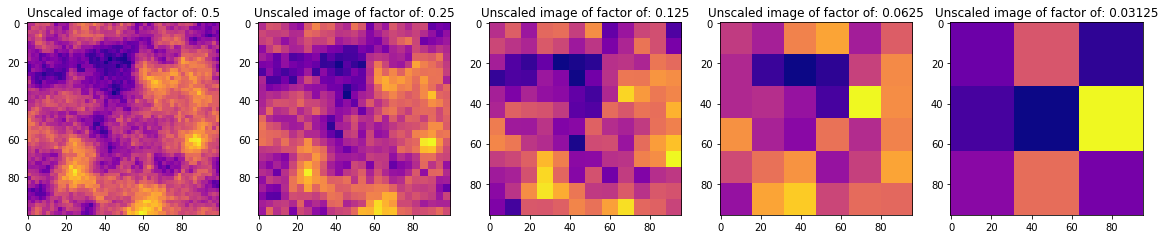

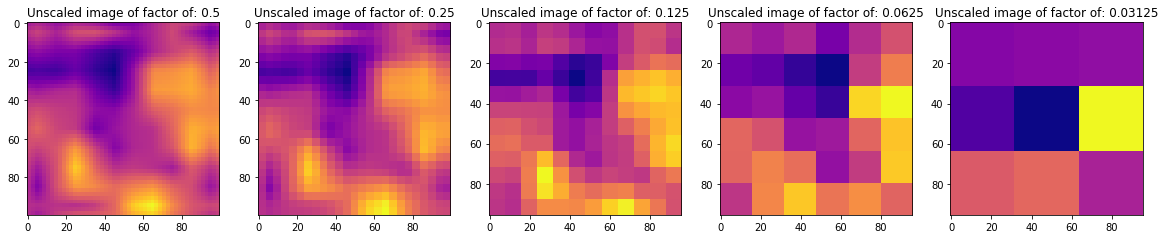

MS-SSIM=0.944


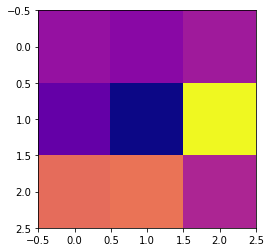

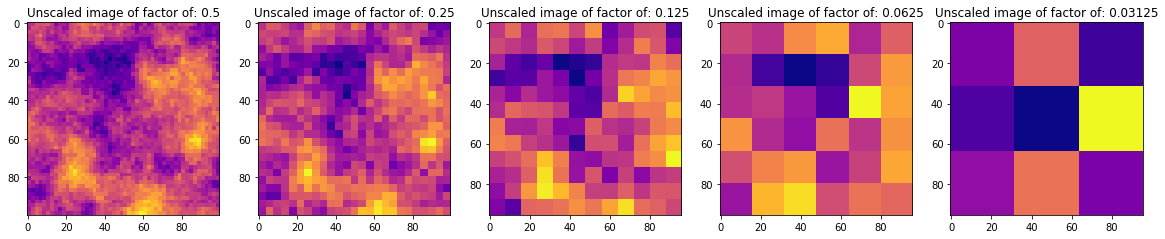

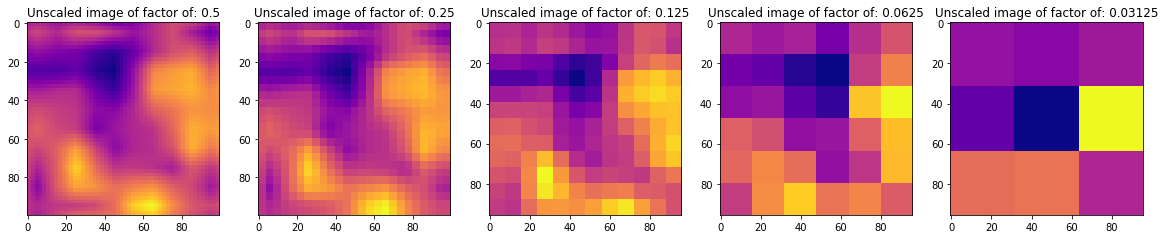

MS-SSIM=0.949


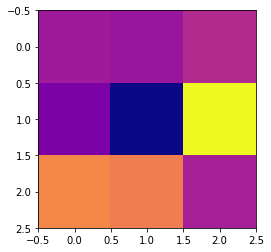

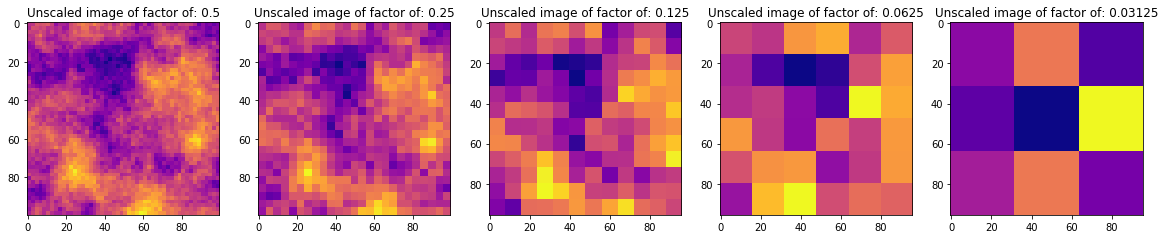

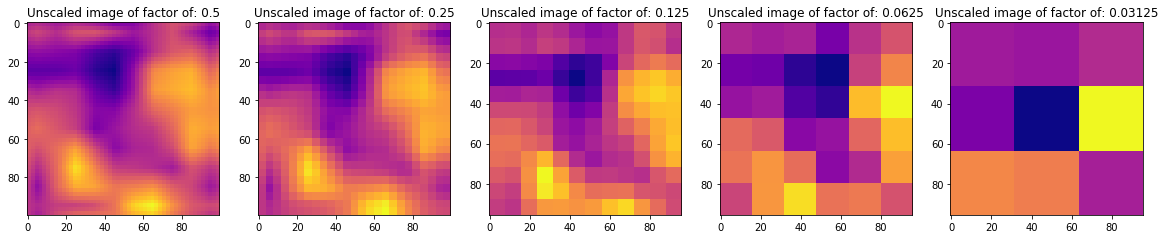

MS-SSIM=0.952


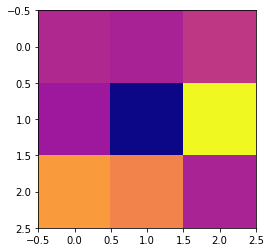

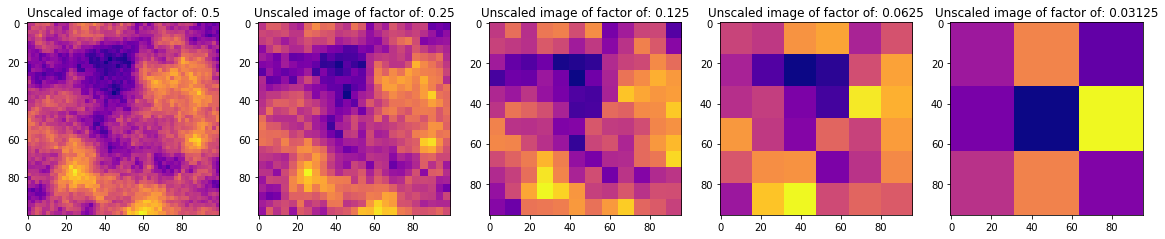

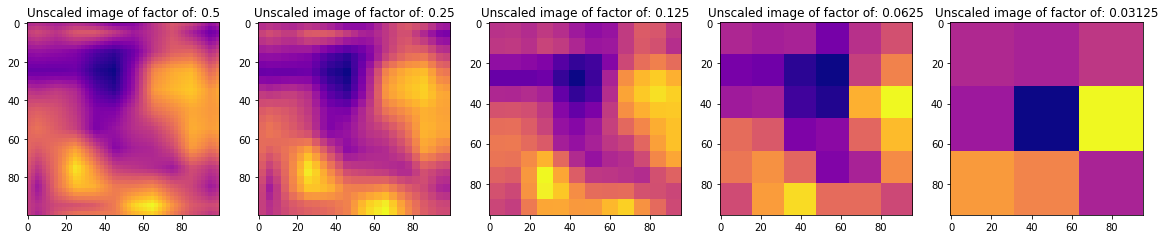

MS-SSIM=0.955


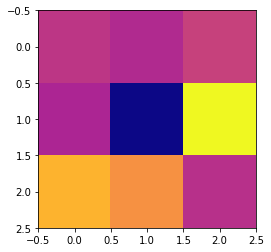

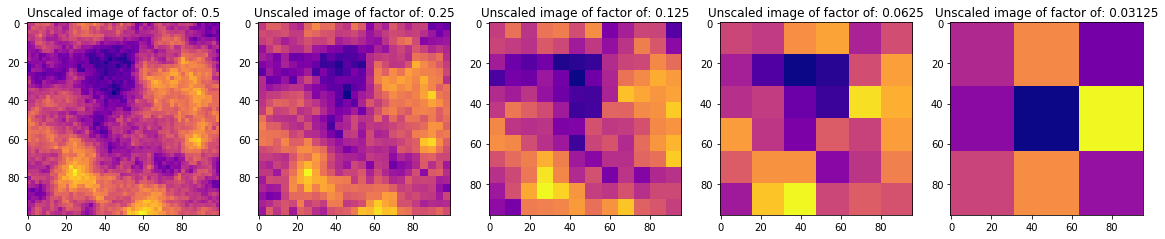

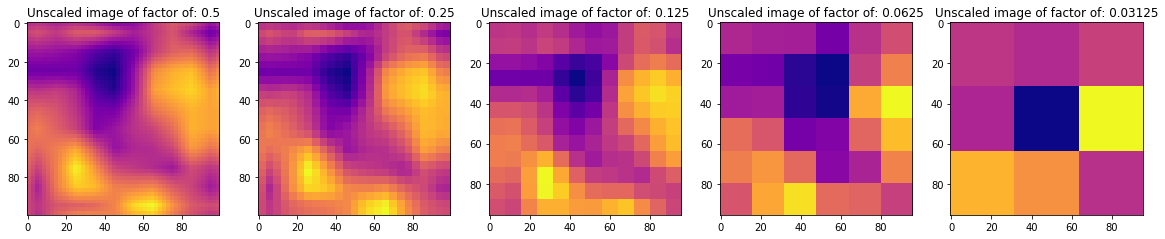

MS-SSIM=0.957


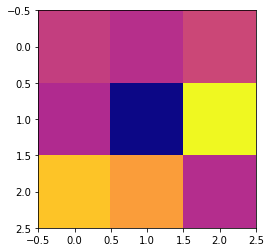

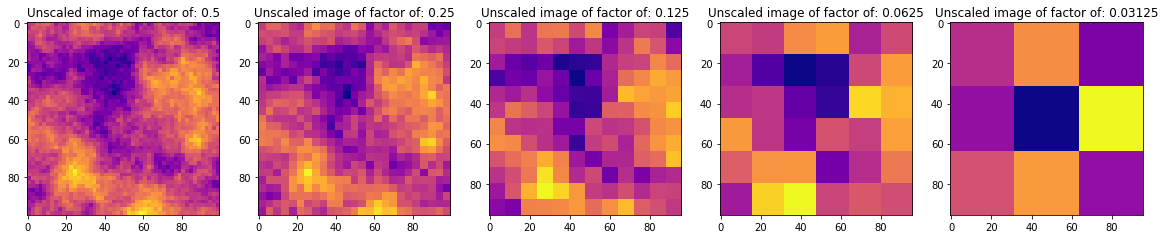

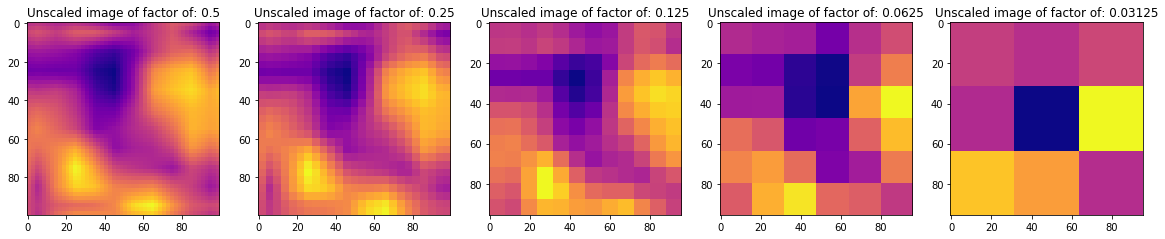

MS-SSIM=0.958


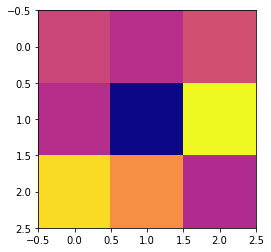

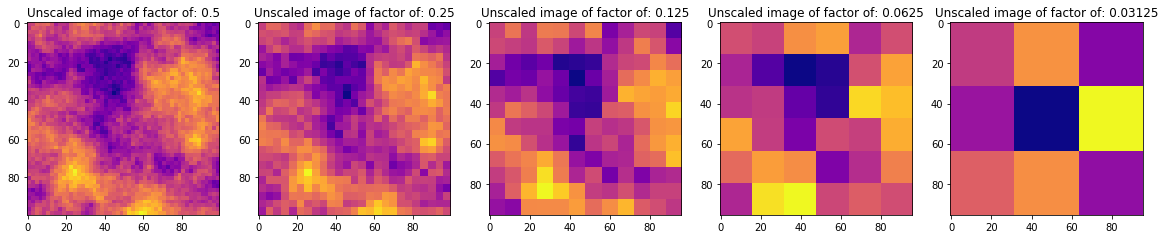

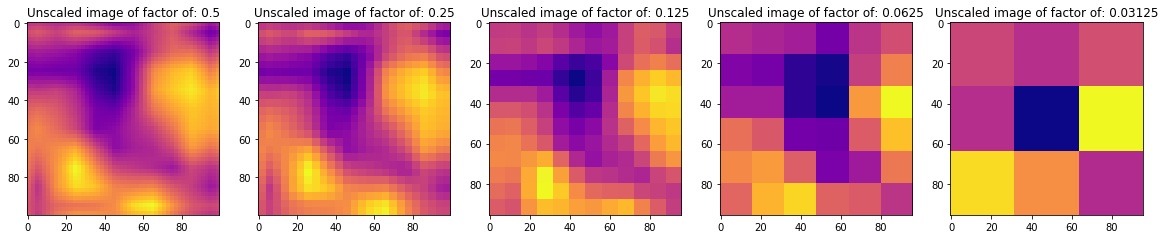

MS-SSIM=0.960


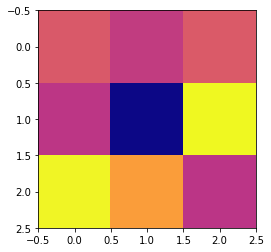

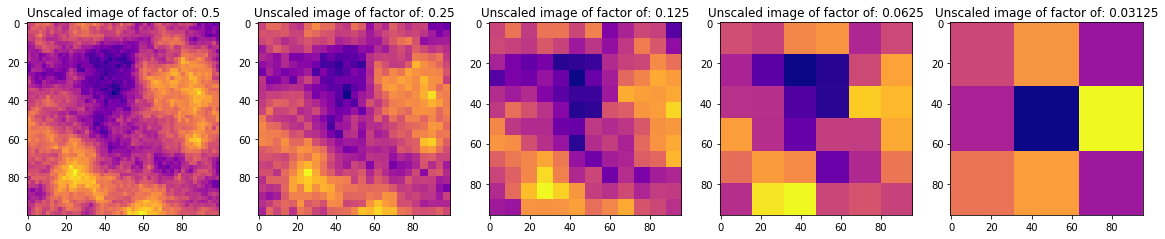

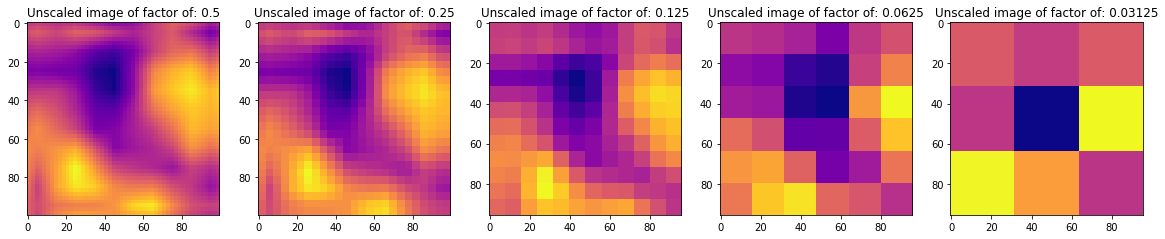

MS-SSIM=0.963


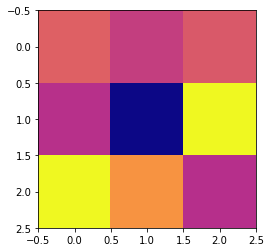

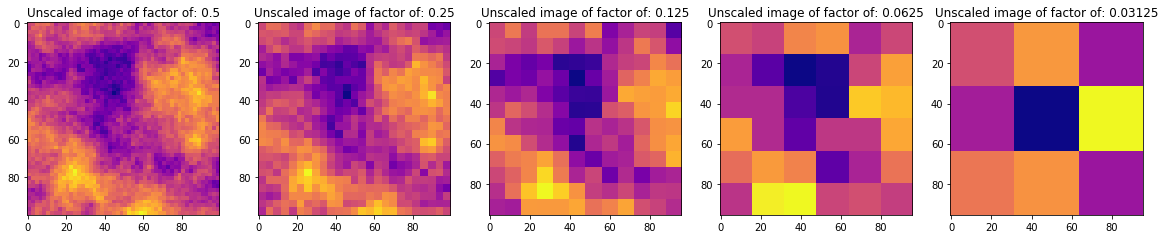

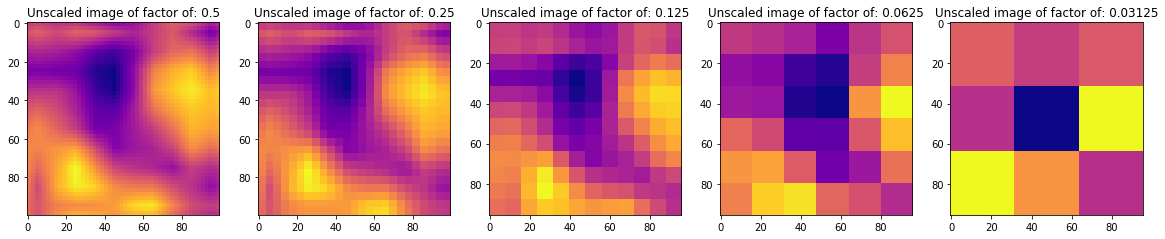

MS-SSIM=0.964


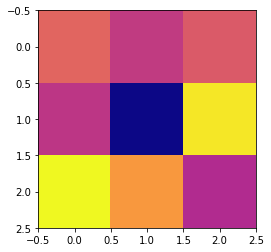

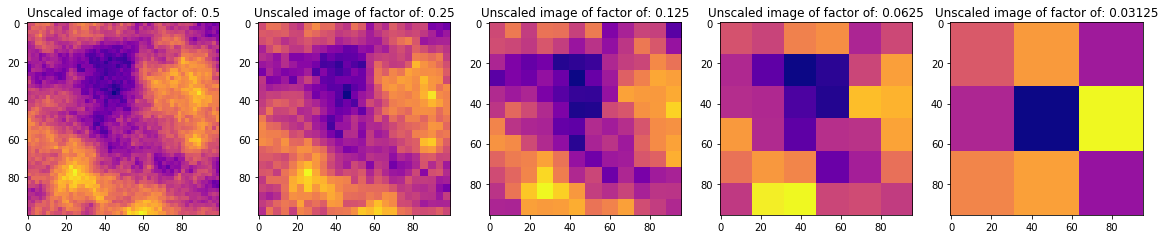

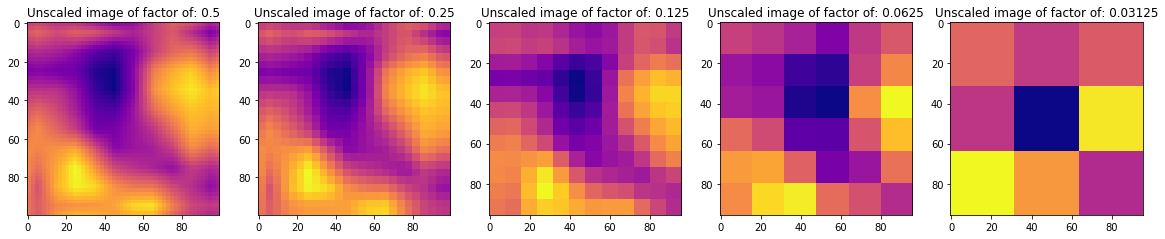

MS-SSIM=0.965


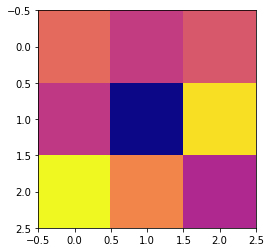

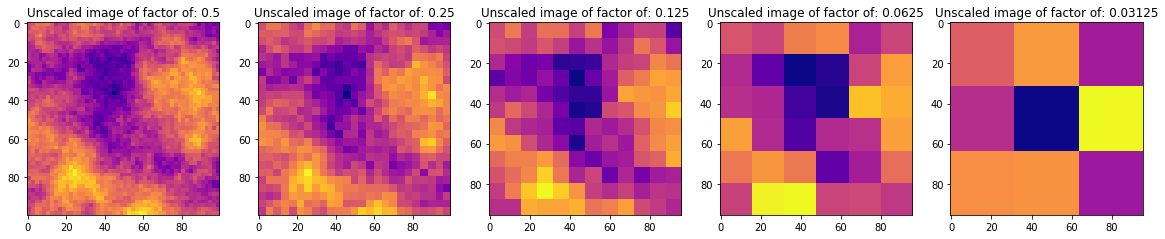

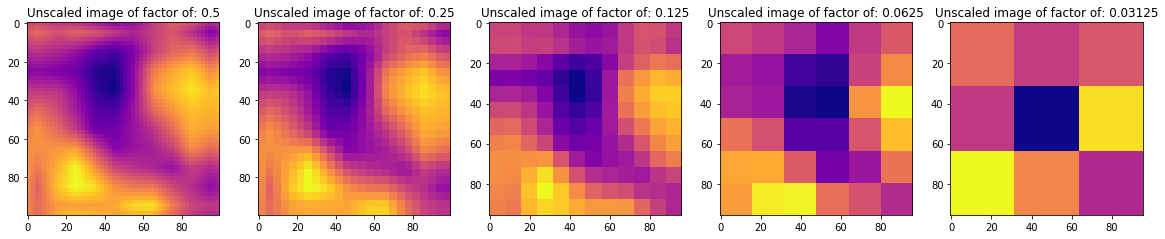

MS-SSIM=0.966


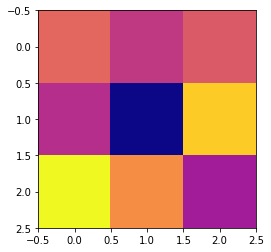

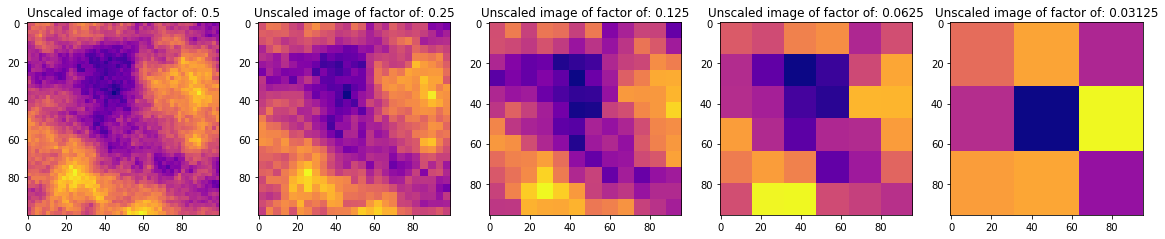

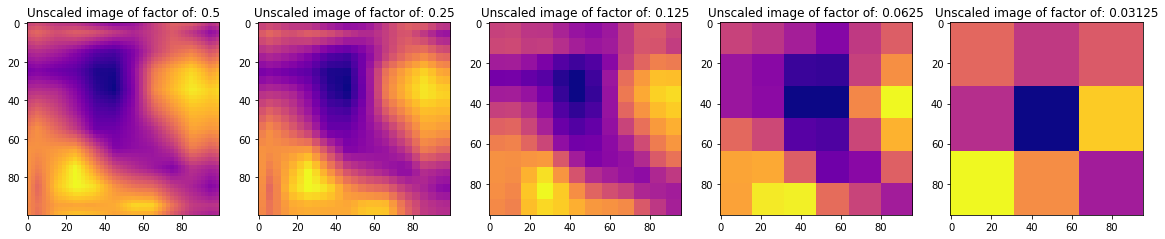

MS-SSIM=0.969


In [86]:
MS_SSIM_var_up = np.zeros(len(simulations))
SSIM_var_up = np.zeros(len(simulations))
mse_var_up = np.zeros(len(simulations))
for i in range(len(simulations)):
    MS_SSIM_var_up[i] = MSSSIM_ww(simulations[i], sim_upscale[i])
    SSIM_var_up[i] = SSIM_ww(simulations[i],sim_upscale[i])
    mse_var_up[i] = mean_squared_error(simulations[i], sim_upscale[i])


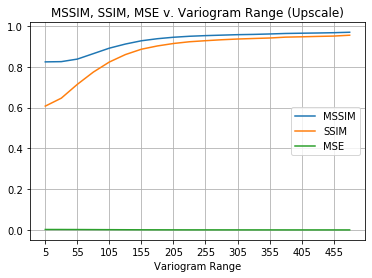

In [87]:
plt.figure()
plt.plot(MS_SSIM_var_up, label='MSSIM')
plt.plot(SSIM_var_up, label='SSIM')
plt.plot(mse_var_up, label='MSE')
plt.xticks(range(0, len(ranges_maj),2), ranges_maj[::2])

plt.xlabel('Variogram Range')
plt.title('MSSIM, SSIM, MSE v. Variogram Range (Upscale)')
plt.legend(); plt.grid('on')


## Variogram with nugget effect

In [88]:
#Start with initial model.
model_nug = make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=500.0,hmin1=250.0)
                                                                                                  
#Set ranges to update model with
ranges_maj = [5, 50, 100, 200, 1000]
ranges_min = [5, 50, 100, 200, 1000]


print('Ranges Major: {} | Ranges Minor: {} '.format(len(ranges_maj), len(ranges_min)))

Ranges Major: 5 | Ranges Minor: 5 


In [89]:
nugget_values = [i/20 for i in range(1,20)]  # Define a list of nugget values to loop through
sim_nug = np.zeros((len(nugget_values),100,100))
simulations_nug = np.zeros((len(nugget_values),100,100))

for i in range(len(nugget_values)):
    model_nug[i] = GSLIB.make_variogram(nug=nugget_values[i], nst=1, it1=1, cc1=1-nugget_values[i], azi1=45.0, hmaj1=1000, hmin1=1000)
    sim_nug[i,:,:] = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed=73073, var=model_nug[i], output_file="simulation")
    simulations_nug[i,:,:] = GSLIB.affine(sim_nug[i,:,:], por_mean, por_stdev)
print('Simulations shape:', simulations_nug.shape)

Simulations shape: (19, 100, 100)


Text(0.5, 1.0, 'Nugget of: 0.95')

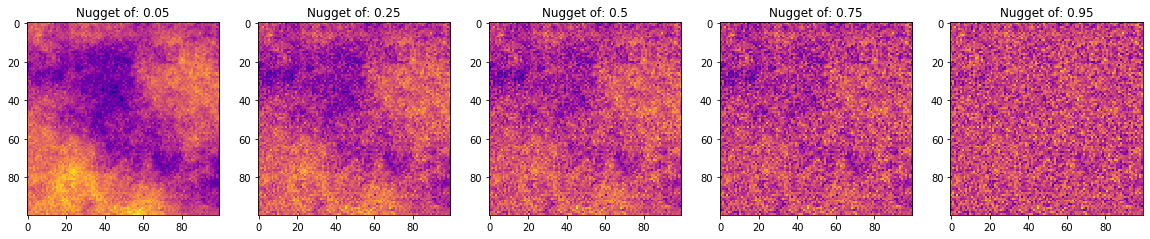

In [90]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.imshow(simulations_nug[0], cmap=cmap)
plt.title('Nugget of: {}'.format(nugget_values[0]))

plt.subplot(152)
plt.imshow(simulations_nug[4], cmap=cmap)
plt.title('Nugget of: {}'.format(nugget_values[4]))

plt.subplot(153)
plt.imshow(simulations_nug[9], cmap=cmap)
plt.title('Nugget of: {}'.format(nugget_values[9]))

plt.subplot(154)
plt.imshow(simulations_nug[14], cmap=cmap)
plt.title('Nugget of: {}'.format(nugget_values[14]))

plt.subplot(155)
plt.imshow(simulations_nug[18], cmap=cmap)
plt.title('Nugget of: {}'.format(nugget_values[18]))

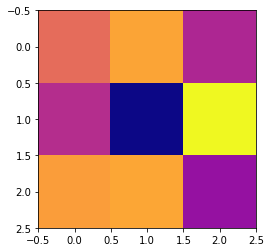

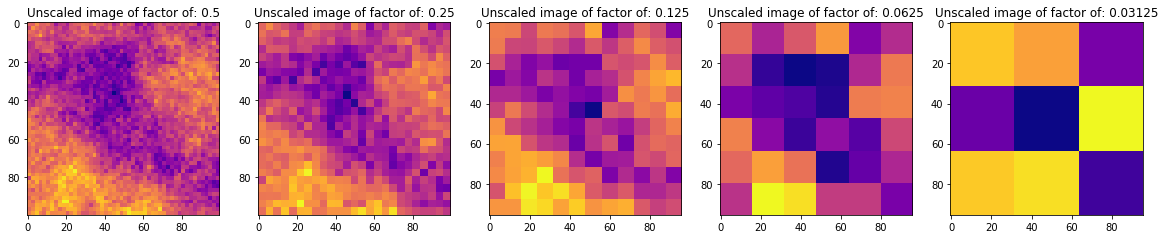

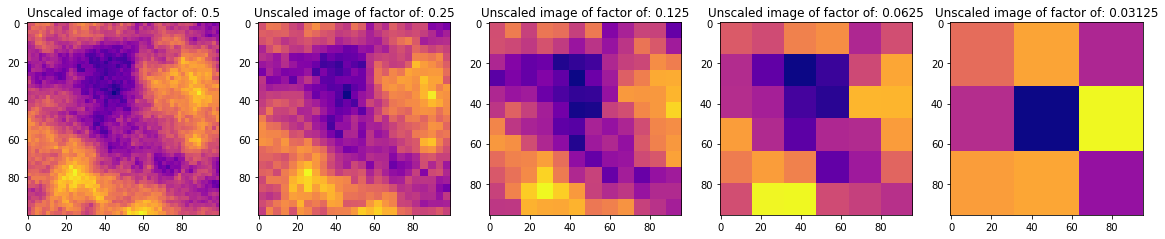

MS-SSIM=0.987


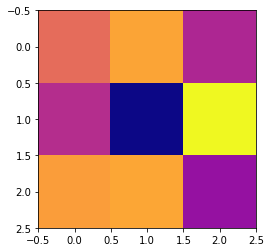

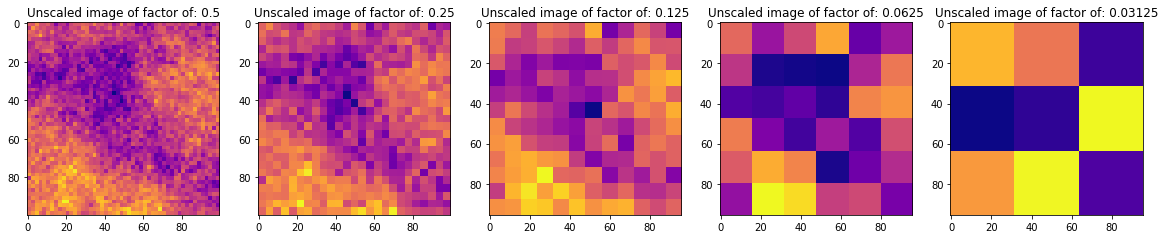

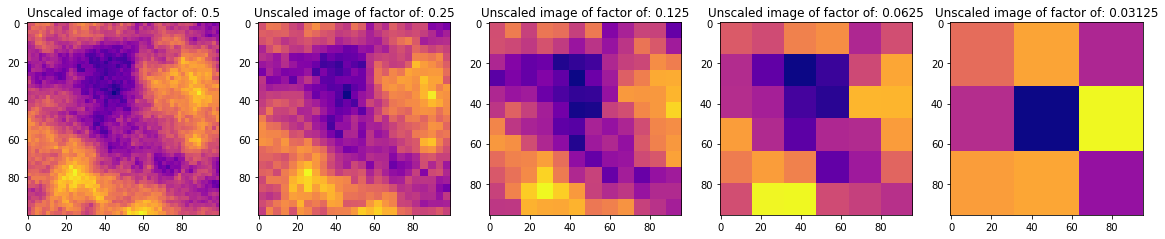

MS-SSIM=0.973


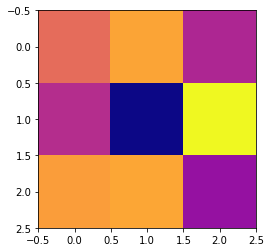

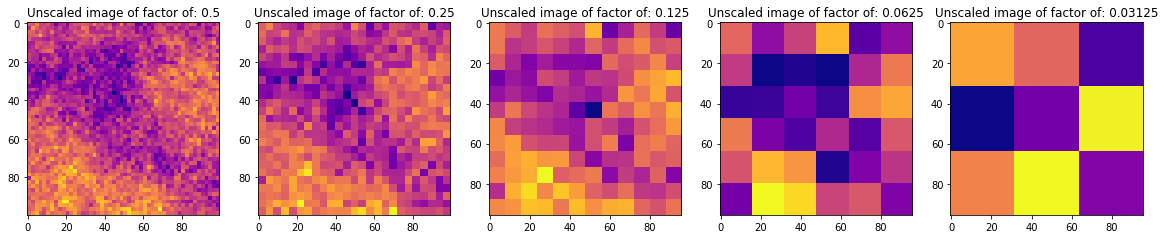

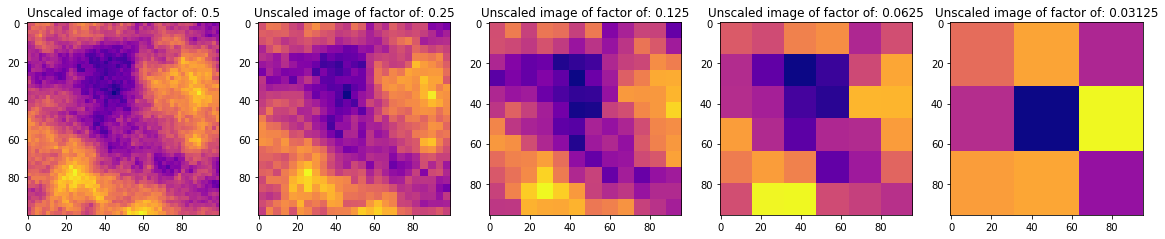

MS-SSIM=0.961


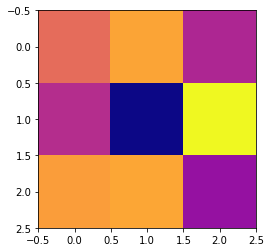

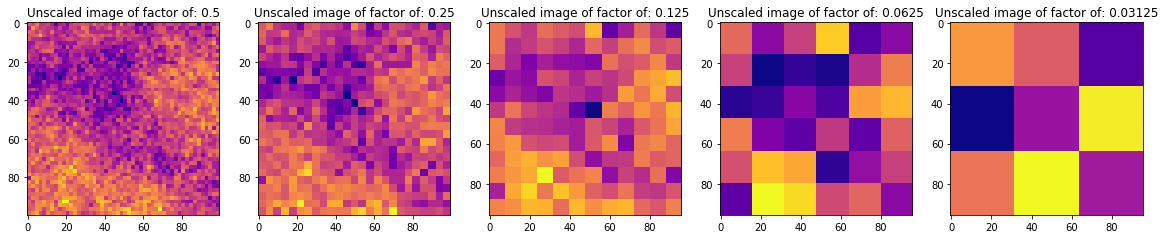

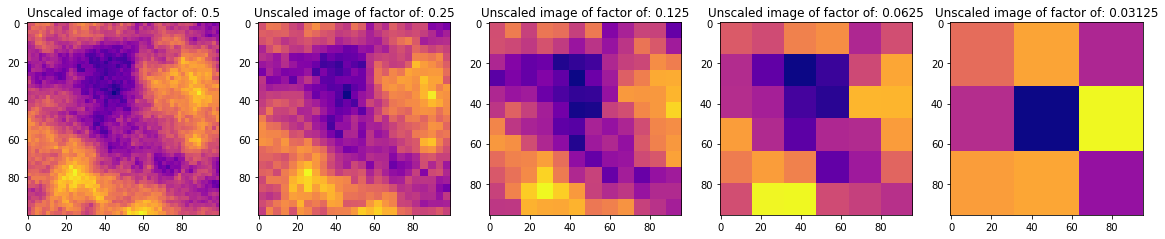

MS-SSIM=0.951


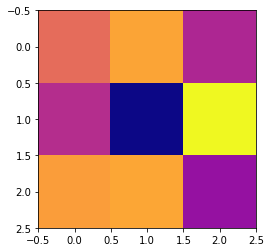

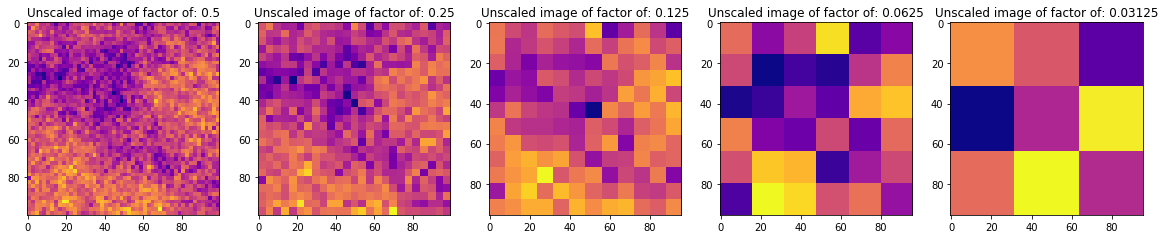

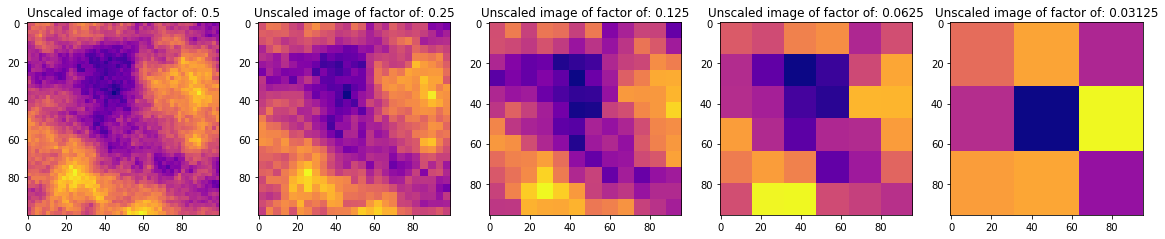

MS-SSIM=0.942


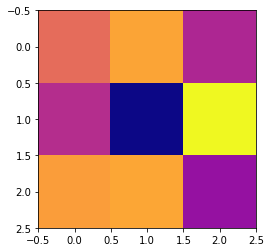

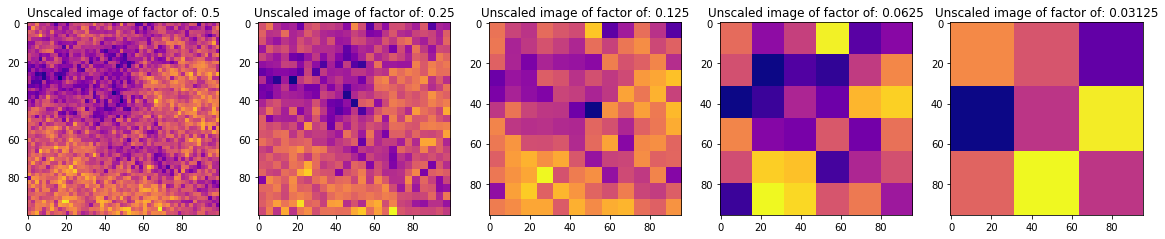

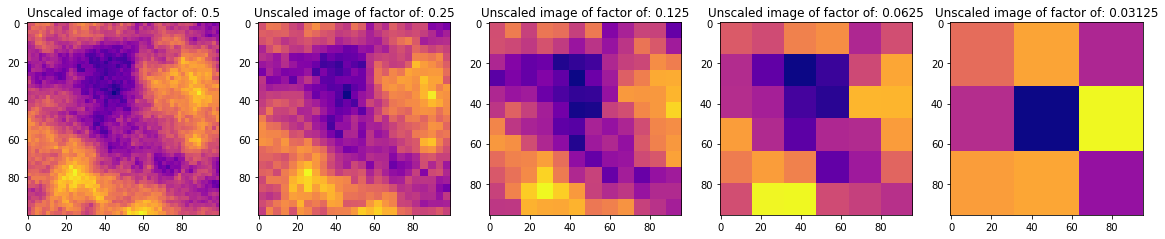

MS-SSIM=0.934


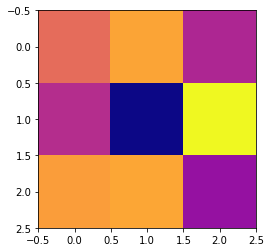

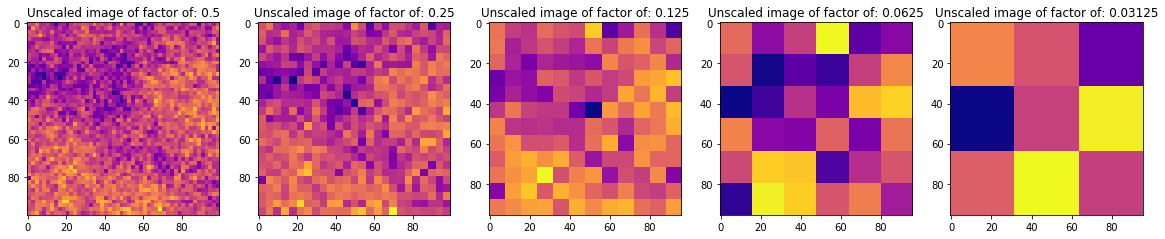

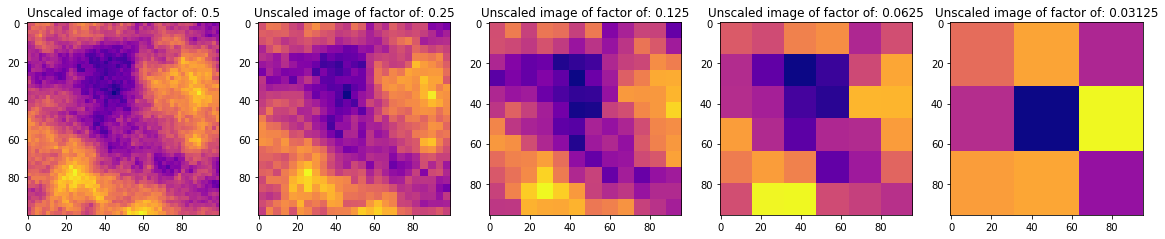

MS-SSIM=0.928


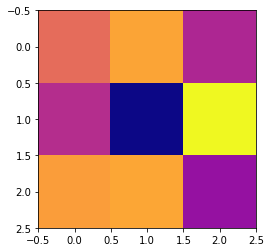

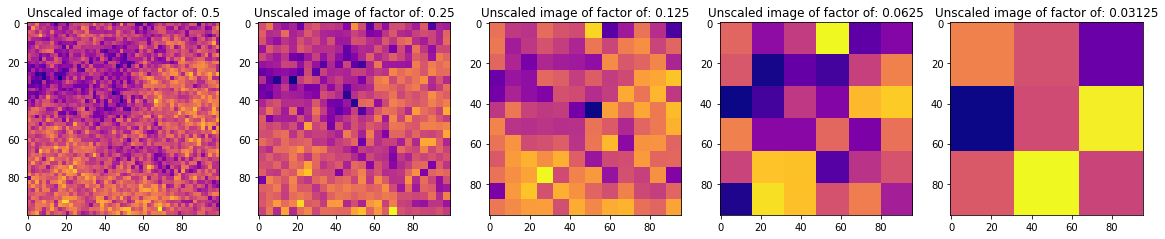

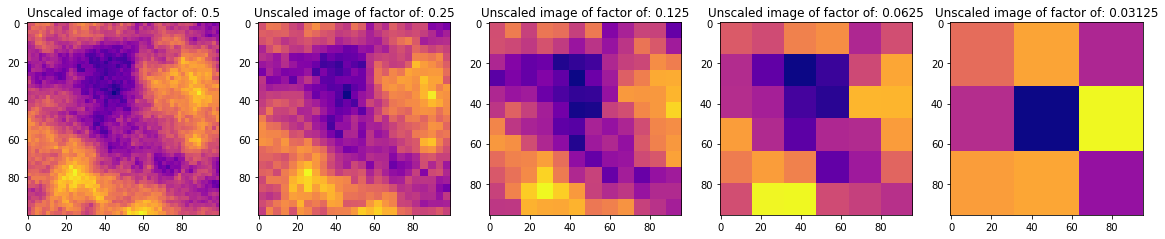

MS-SSIM=0.922


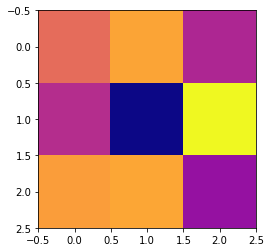

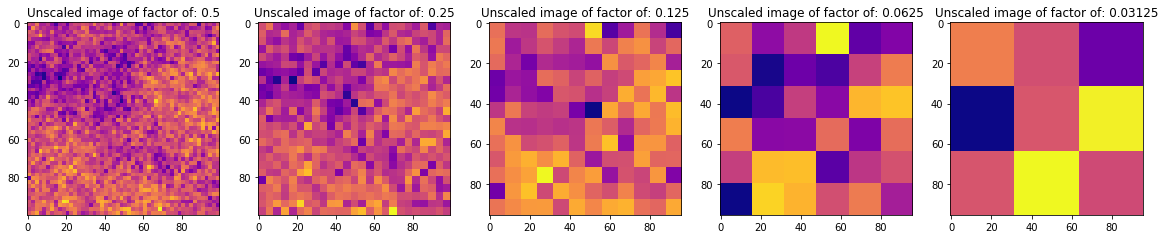

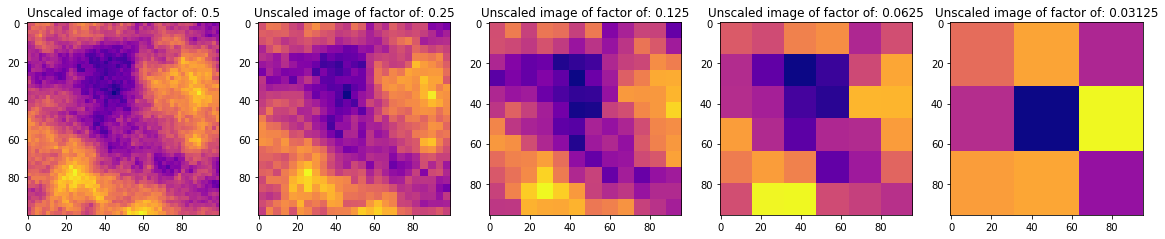

MS-SSIM=0.916


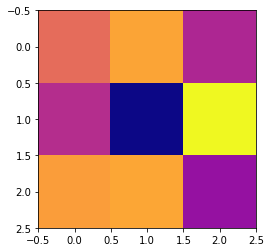

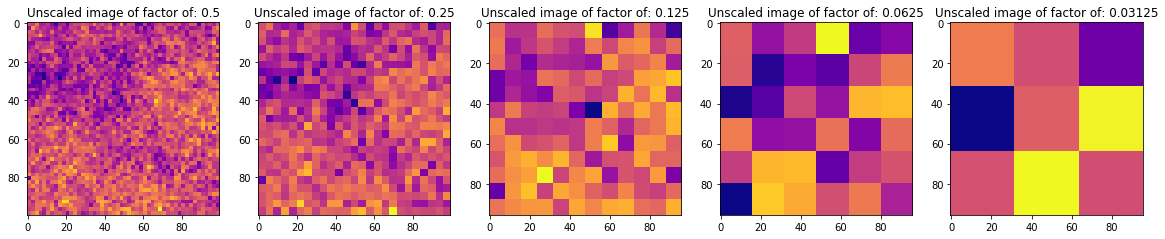

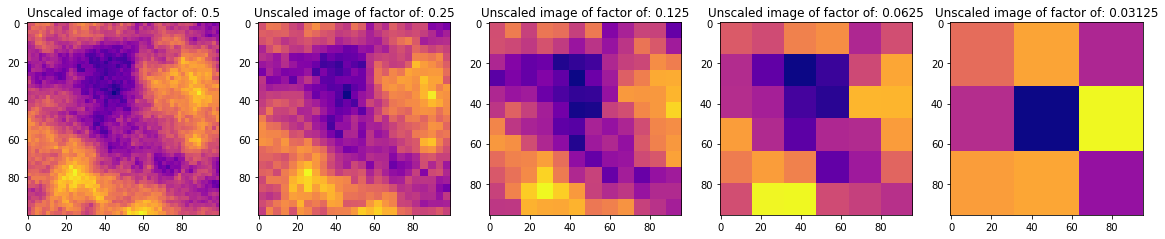

MS-SSIM=0.911


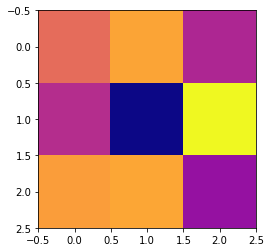

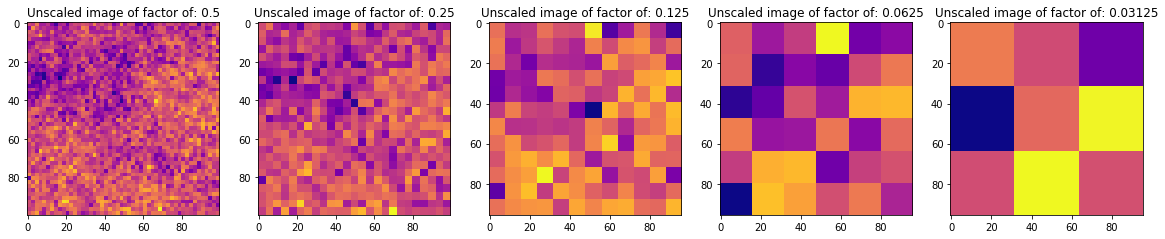

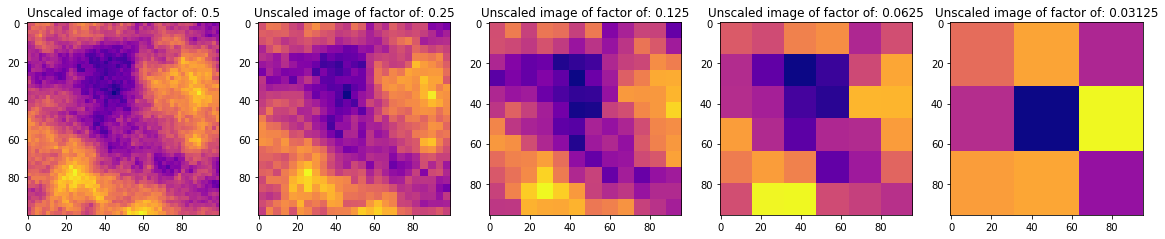

MS-SSIM=0.905


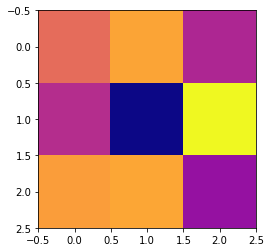

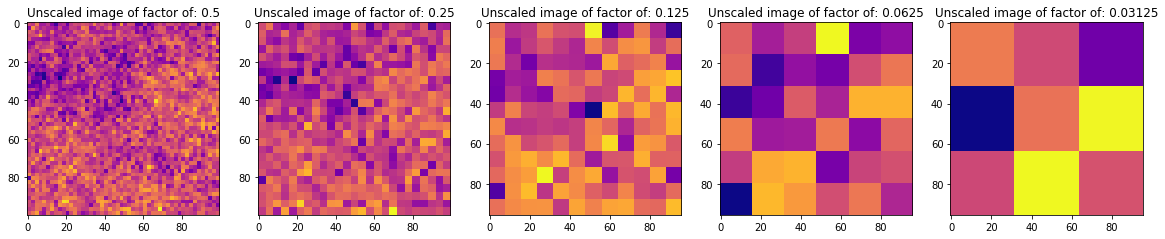

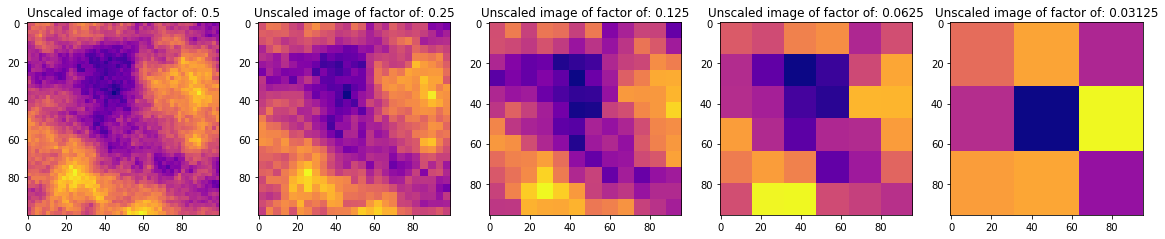

MS-SSIM=0.900


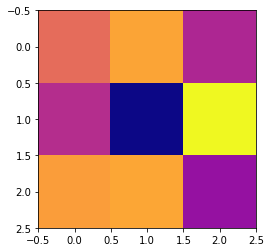

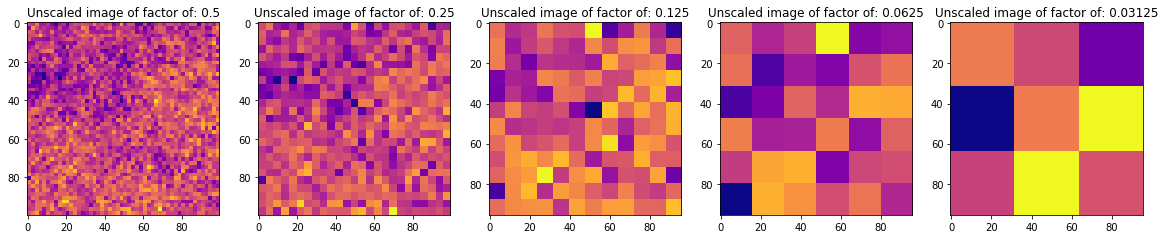

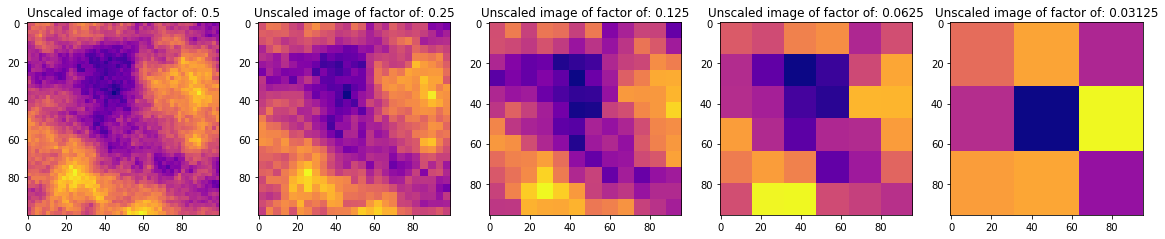

MS-SSIM=0.894


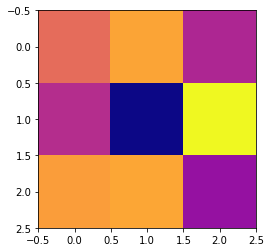

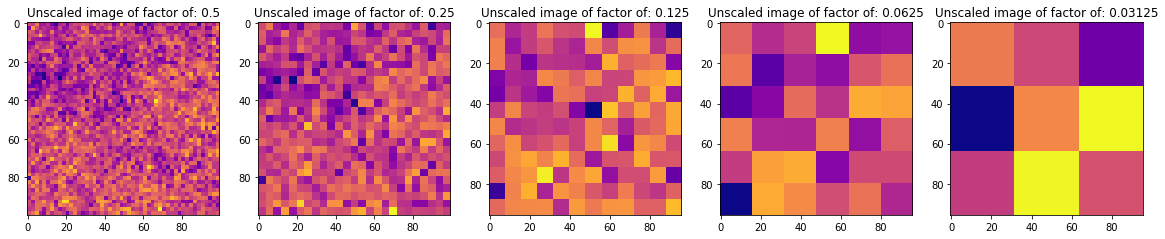

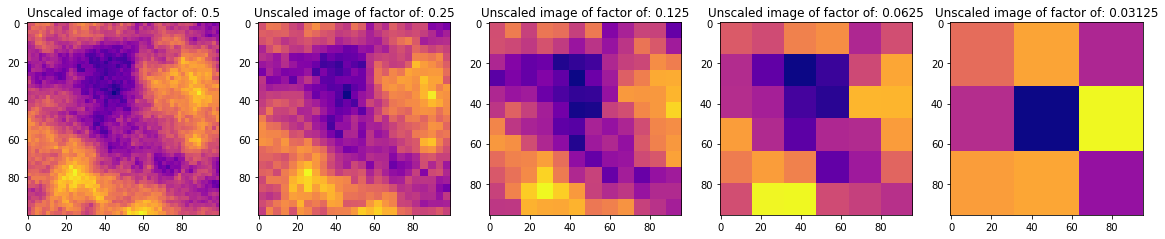

MS-SSIM=0.888


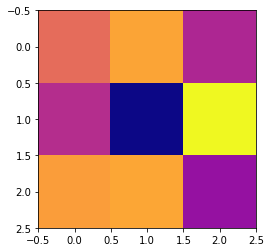

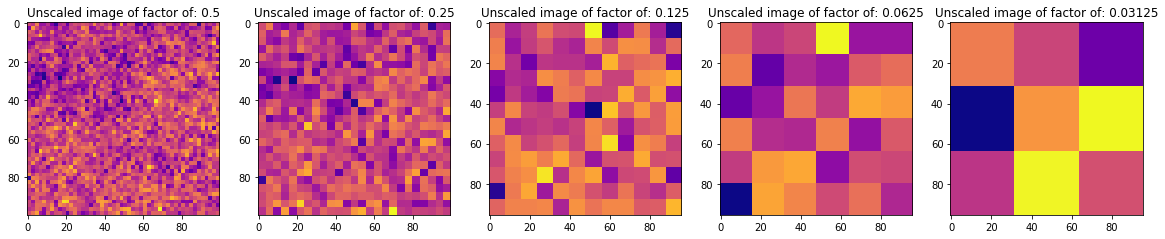

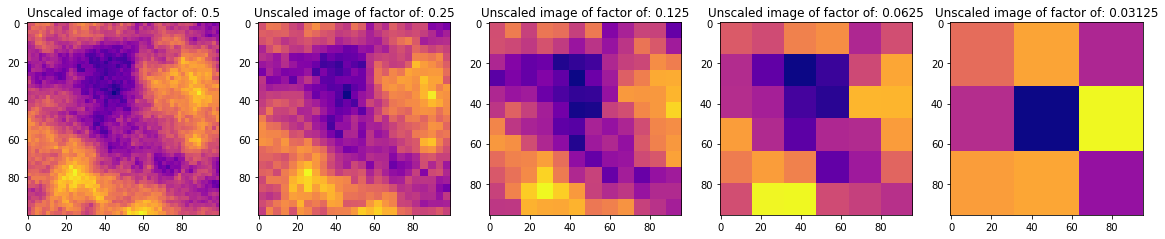

MS-SSIM=0.882


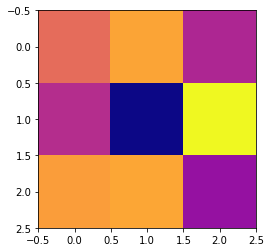

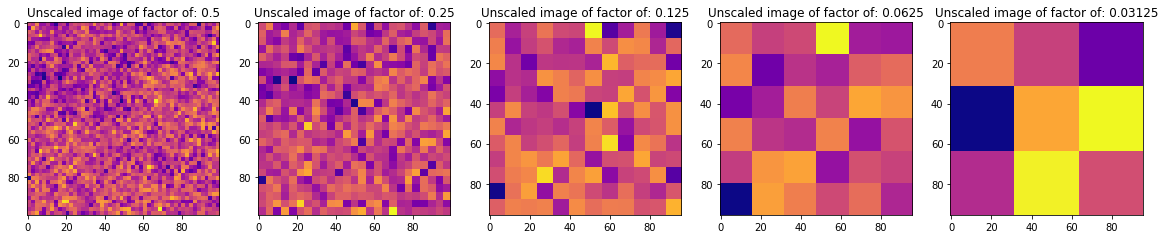

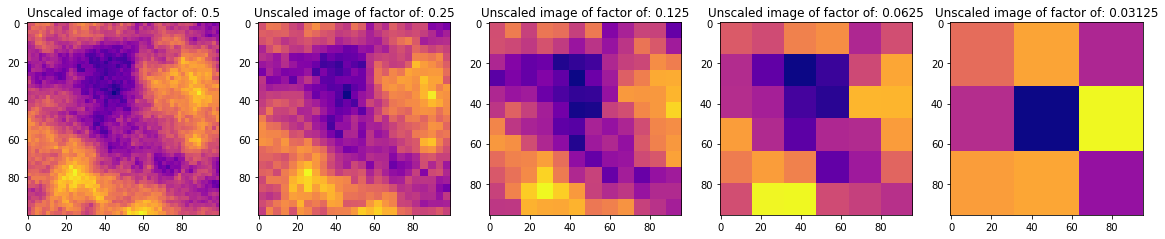

MS-SSIM=0.876


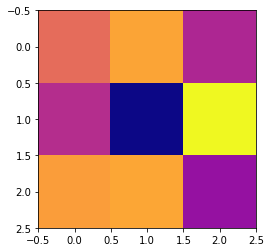

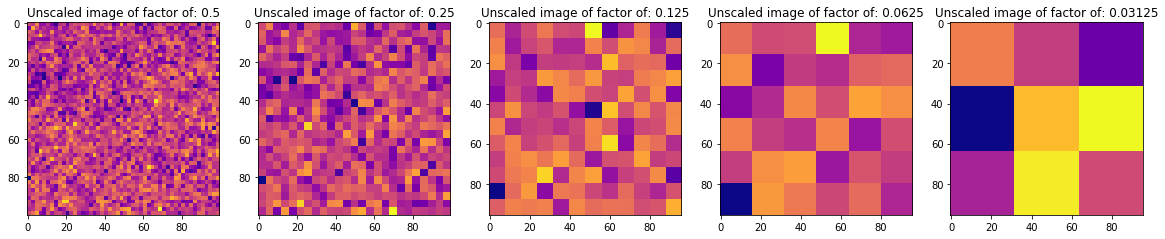

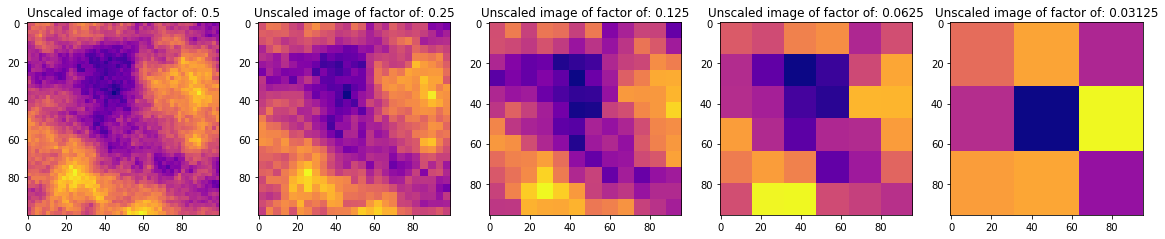

MS-SSIM=0.869


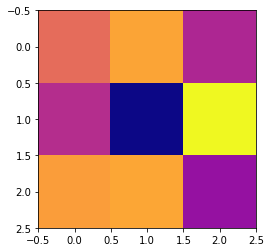

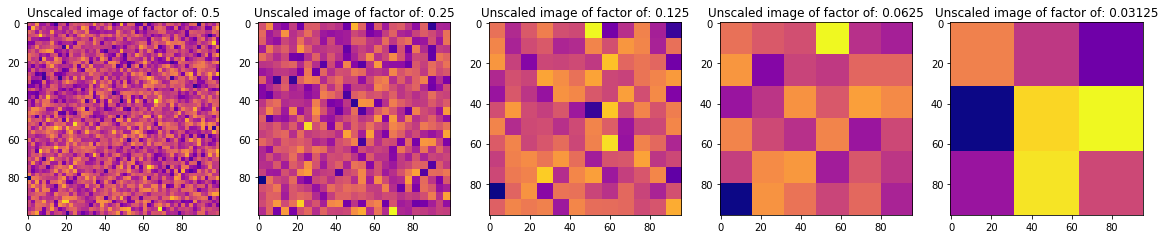

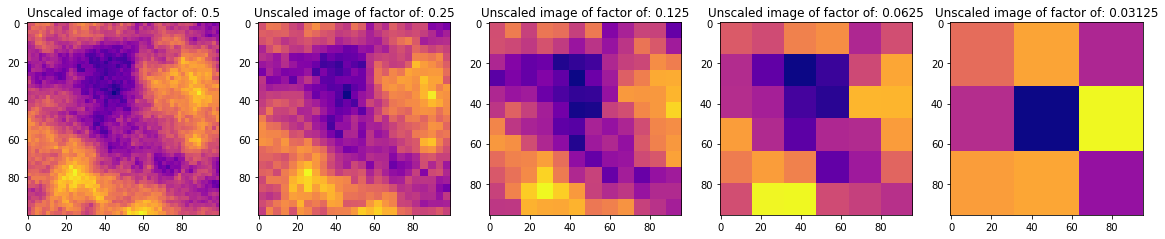

MS-SSIM=0.863


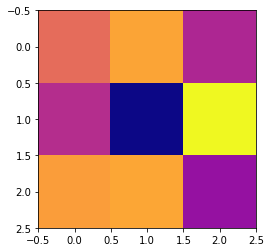

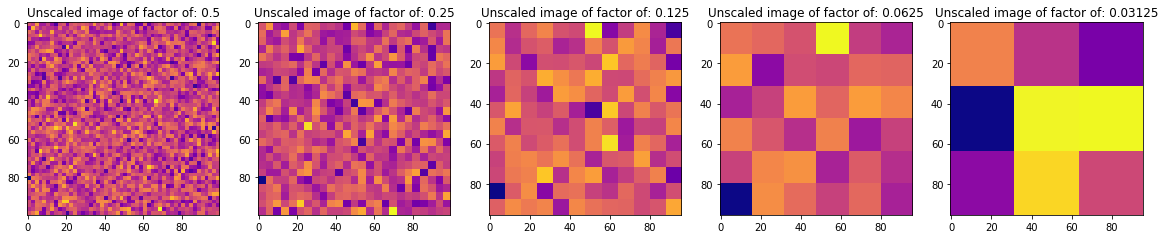

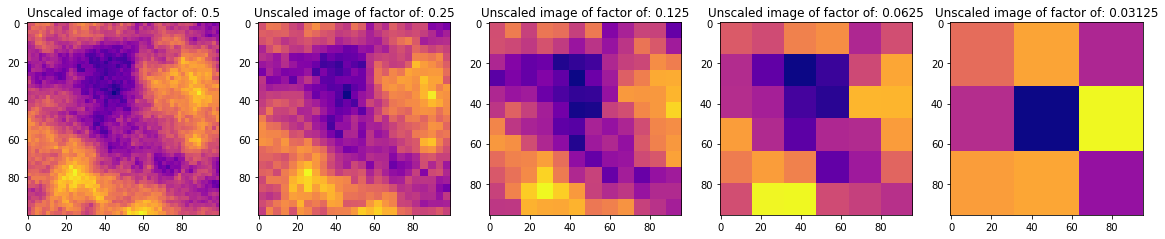

MS-SSIM=0.856


In [91]:
MS_SSIM_var_nug = np.zeros(len(simulations_nug))
SSIM_var_nug = np.zeros(len(simulations_nug))
mse_var_nug = np.zeros(len(simulations_nug))
for i in range(len(simulations_nug)):
    MS_SSIM_var_nug[i] = MSSSIM_ww(simulations_nug[i], simulations[-1])
    SSIM_var_nug[i] = SSIM_ww(simulations_nug[i],simulations[-1])
    mse_var_nug[i] = mean_squared_error(simulations_nug[i], simulations[-1])


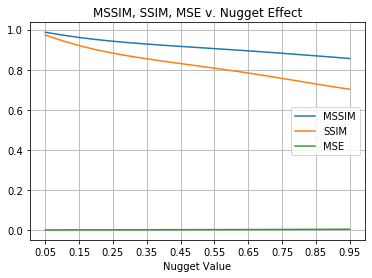

In [92]:
plt.figure()
plt.plot(MS_SSIM_var_nug, label='MSSIM')
plt.plot(SSIM_var_nug, label='SSIM')
plt.plot(mse_var_nug, label='MSE')
plt.xticks(range(0, len(nugget_values), 2), nugget_values[::2])
plt.xlabel('Nugget Value')
plt.title('MSSIM, SSIM, MSE v. Nugget Effect')
plt.legend(); plt.grid('on')


We compared the performance of MSE, SSIM, and multi-scale SSIM on a wide range of variogram ranges for rotation and translation of the image. We see that at small variogram ranges, the MS-SSIM and SSIM were lower comapred to the larger variogram ranges and at a significantly large variogram range, the metrics remained constant. When we compared the translated to the original image, we witness a similar pattern, however, the metrics reach a maximum value at a much smaller variogram range compared to the rotation of orginal image. Additionally, we tested the metrics when comparing the original image with a range of nugget values. At small nugget effects (0), the MS-SSIM and SSIM are the same, but as the nugget effect increases, the similarity decreases and the difference between the two metrics increases. This suggests that, the choice of image quality metrics should depend on the level of transformation of the images, as well as the presence of a nugget effect. 

 #### Comments
While MS-SSIM is a widely used and popular metric for evaluating image similarity and quality, there are several considerations and limitations to keep in mind when using it for machine learning model checking. One key limitation is that MS-SSIM requires a reference image to calculate the similarity score. In practice, this means that MS-SSIM may not always be applicable when working with large datasets, where it may be impractical or impossible to manually generate reference images for all samples.

Another consideration is that MS-SSIM assumes that the image is spatially stationary, which may not be true in all cases. Therefore, if the image is subject to certain degrees of rotation, translation or scaling, the MS-SSIM may not accurately reflect the image quality. It is important to take into account any transformations that may have been applied to the image when using MS-SSIM as a metric for model evaluation. 

In conclusion, while MS-SSIM is a useful metric for evaluating the perceptual quality of images, it should be used in conjunction with other metrics and validation techniques to ensure that the model is performing optimally.
  
#### The Authors:

### Blazej Ksiazek, Graduate Research Assistant, University of Texas at Austin 

[Github] (to be linked) [LinkedIn] (to be linked)

Blazej is currently pursuing an M.S in Petroleum Engineering at the University of Texas at Austin in the Hildebrand Department of Petroleum and Geosystems Engineering. He graduated with his B.S. in Petroleum Engineering and a minor in Spanish from the University of Tulsa in May 2021. Blazej has an interest in spatial data analytics, machine learning and uncertainty modeling. He is also a member of the University of Texas at Austin Petrobowl Team.    

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  